In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import environment
import job_distribution
import slow_down_cdf
import RL_brain
import parameters
from gurobipy import *

/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/tensorf

Instructions for updating:
non-resource variables are not supported in the long term


/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/11yunyi/opt/anaconda3/lib/python3.7/

In [2]:
def discount(x, gamma):
    """
    Given vector x, computes a vector y such that
    y[i] = x[i] + gamma * x[i+1] + gamma^2 x[i+2] + ...
    """
    out = np.zeros(len(x))
    out[-1] = x[-1]
    for i in reversed(range(len(x)-1)):
        out[i] = x[i] + gamma*out[i+1]
    assert x.ndim >= 1
    # More efficient version:
    # scipy.signal.lfilter([1],[1,-gamma],x[::-1], axis=0)[::-1]
    return out

In [3]:
def get_traj(agent, env, episode_max_length):
    """
    Run agent-environment loop for one whole episode (trajectory)
    Return dictionary of results
    """
    env.reset()
    obs = []
    acts = []
    rews = []
    info = []

    ob = env.observe()

    for _ in range(episode_max_length):
    #for _ in range(5):

        loss = 0
        #print('ob_len:',len(ob[0]))
        a = agent.choose_action(ob)

        obs.append(ob)  # store the ob at current decision making step
        acts.append(a)

        ob_, rew, done, info = env.step(a, repeat=True)

        # agent.store_transition(ob, a, rew)

        rews.append(rew)

        if done:

            # loss = agent.learn()
            break

        ob = ob_

    # loss = agent.learn()

    return {'reward': np.array(rews),
            'ob': np.array(obs),
            'action': np.array(acts),
            'info': info,
            # 'loss': loss
            }

In [4]:
def concatenate_all_ob(trajs, pa):

    timesteps_total = 0
    for i in range(len(trajs)):
        timesteps_total += len(trajs[i]['reward'])

    all_ob = np.zeros(
        (timesteps_total, pa.network_input_height*pa.network_input_width),
        dtype=np.float64)

    timesteps = 0
    for i in range(len(trajs)):
        for j in range(len(trajs[i]['reward'])):
            all_ob[timesteps, :] = trajs[i]['ob'][j]
            timesteps += 1

    return all_ob

In [5]:
def process_all_info(trajs):
    enter_time = []
    finish_time = []
    job_len = []

    for traj in trajs:
        enter_time.append(np.array([traj['info'].record[i].enter_time for i in range(len(traj['info'].record))]))
        finish_time.append(np.array([traj['info'].record[i].finish_time for i in range(len(traj['info'].record))]))
        job_len.append(np.array([traj['info'].record[i].len for i in range(len(traj['info'].record))]))

    enter_time = np.concatenate(enter_time)
    finish_time = np.concatenate(finish_time)
    job_len = np.concatenate(job_len)

    return enter_time, finish_time, job_len

In [6]:
def plot_lr_curve(output_file_prefix, max_rew_lr_curve, mean_rew_lr_curve, slow_down_lr_curve,
                  ref_discount_rews, ref_slow_down,ref_lr_gurobi=None):
    num_colors = len(ref_discount_rews) + 2
    cm = plt.get_cmap('gist_rainbow')

    fig = plt.figure(figsize=(12, 5))

    ax = fig.add_subplot(121)
    #ax.set_prop_cycle([cm(1. * i / num_colors) for i in range(num_colors)])
    ax.set_prop_cycle(color=['blue', 'green', 'orange', 'red','yellow','gray'])
    ax.plot(mean_rew_lr_curve, linewidth=2, label='PG mean')
    ax.plot(max_rew_lr_curve, linewidth=2, label='PG max')
    for k in ref_discount_rews:
        ax.plot(np.tile(np.average(ref_discount_rews[k]), len(mean_rew_lr_curve)), linewidth=2, label=k)
    plt.legend(loc=4)
    plt.xlabel("Iteration", fontsize=20)
    plt.ylabel("Discounted Total Reward", fontsize=20)

    
    
    ax = fig.add_subplot(122)
    ax.set_prop_cycle(color=['blue', 'green', 'orange', 'red','yellow','gray'])
    #ax.set_color_cycle([cm(1. * i / num_colors) for i in range(num_colors)])

    ax.plot(slow_down_lr_curve, linewidth=2, label='PG mean')
    #######todo：添加gurobi计算结果####
    #ax.plot(ref_lr_gurobi, linewidth=2, label='Gurobi')
    ###########################
    for k in ref_discount_rews:
        ax.plot(np.tile(np.average(np.concatenate(ref_slow_down[k])), len(slow_down_lr_curve)), linewidth=2, label=k)

    plt.legend(loc=1)
    plt.xlabel("Iteration", fontsize=20)
    plt.ylabel("Completion time", fontsize=20)

    plt.savefig(output_file_prefix + "_lr_curve" + ".pdf")


In [7]:
def get_traj_worker(rl, env, pa):

    trajs = []

    for i in range(pa.num_seq_per_batch):
        traj = get_traj(rl, env, pa.episode_max_length)
        trajs.append(traj)

    all_ob = concatenate_all_ob(trajs, pa)

    # Compute discounted sums of rewards
    rets = [discount(traj["reward"], pa.discount) for traj in trajs]
    maxlen = max(len(ret) for ret in rets)
    padded_rets = [np.concatenate([ret, np.zeros(maxlen - len(ret))]) for ret in rets]

    # Compute time-dependent baseline
    baseline = np.mean(padded_rets, axis=0)

    # Compute advantage function
    advs = [ret - baseline[:len(ret)] for ret in rets]
    all_action = np.concatenate([traj["action"] for traj in trajs])
    all_adv = np.concatenate(advs)

    all_eprews = np.array([discount(traj["reward"], pa.discount)[0] for traj in trajs])  # episode total rewards
    all_eplens = np.array([len(traj["reward"]) for traj in trajs])  # episode lengths
    # all_loss = np.array([traj["loss"] for traj in trajs])

    # All Job Stat
    enter_time, finish_time, job_len = process_all_info(trajs)
    finished_idx = (finish_time >= 0)
    completion_time = finish_time[finished_idx] - enter_time[finished_idx]

    return all_eprews, all_eplens, completion_time, all_ob, all_action, all_adv

Preparing for workers...
-prepare for env- 0
-prepare for env- 1
-prepare for env- 2
-prepare for env- 3
-prepare for env- 4
-prepare for env- 5
-prepare for env- 6
-prepare for env- 7
-prepare for env- 8
-prepare for env- 9
-prepare for worker-
Preparing for reference data...
Load on # 0 resource dimension is 2.820666666666667
Load on # 1 resource dimension is 3.3366666666666664



=============== 0 ===============
---------- Tetris -----------
total discount reward : 	 -1736.0
---------- SJF -----------
total discount reward : 	 -860.0
---------- packer -----------
total discount reward : 	 -1694.0
---------- Random -----------
total discount reward : 	 -1351.0



=============== 1 ===============
---------- Tetris -----------
total discount reward : 	 -1655.0
---------- SJF -----------
total discount reward : 	 -790.0
---------- packer -----------
total discount reward : 	 -1605.0
---------- Random -----------
total discount reward : 	 -1504.0



=============== 2 ===============
--

INFO:tensorflow:Restoring parameters from data/tmp_10.ckpt
---------- PG -----------
total discount reward : 	 -1169.0
---------- Tetris -----------
total discount reward : 	 -632.0
---------- SJF -----------
total discount reward : 	 -421.0
---------- packer -----------
total discount reward : 	 -604.0
---------- Random -----------
total discount reward : 	 -1080.0



=============== 5 ===============
INFO:tensorflow:Restoring parameters from data/tmp_10.ckpt
---------- PG -----------
total discount reward : 	 -1774.0
---------- Tetris -----------
total discount reward : 	 -1361.0
---------- SJF -----------
total discount reward : 	 -574.0
---------- packer -----------
total discount reward : 	 -1319.0
---------- Random -----------
total discount reward : 	 -1050.0



=============== 6 ===============
INFO:tensorflow:Restoring parameters from data/tmp_10.ckpt
---------- PG -----------
total discount reward : 	 -1478.0
---------- Tetris -----------
total discount reward : 	 -1358.0
---

INFO:tensorflow:Restoring parameters from data/tmp_20.ckpt
---------- PG -----------
total discount reward : 	 -1316.0
---------- Tetris -----------
total discount reward : 	 -1285.0
---------- SJF -----------
total discount reward : 	 -525.0
---------- packer -----------
total discount reward : 	 -1247.0
---------- Random -----------
total discount reward : 	 -1148.0



=============== 8 ===============
INFO:tensorflow:Restoring parameters from data/tmp_20.ckpt
---------- PG -----------
total discount reward : 	 -1577.0
---------- Tetris -----------
total discount reward : 	 -1669.0
---------- SJF -----------
total discount reward : 	 -652.0
---------- packer -----------
total discount reward : 	 -1517.0
---------- Random -----------
total discount reward : 	 -1351.0



=============== 9 ===============
INFO:tensorflow:Restoring parameters from data/tmp_20.ckpt
---------- PG -----------
total discount reward : 	 -1073.0
---------- Tetris -----------
total discount reward : 	 -699.0
--




-----------------
Iteration: 	 31
NumTrajs: 	 10
NumTimesteps: 	 17274
Loss:     	 -10.551562
MaxRew: 	 -831.5
MeanRew: 	 -964.29 +- 231.97126093548744
MeanSlowdown: 	 32.10966666666667
MeanLen: 	 172.74 +- 48.3660252656759
Elapsed time	 47.732146978378296 seconds
-----------------



-----------------
Iteration: 	 32
NumTrajs: 	 10
NumTimesteps: 	 17433
Loss:     	 -9.559197
MaxRew: 	 -833.9
MeanRew: 	 -961.38 +- 235.81377313464964
MeanSlowdown: 	 32.01366666666667
MeanLen: 	 174.33 +- 46.38341406149401
Elapsed time	 40.344679832458496 seconds
-----------------



-----------------
Iteration: 	 33
NumTrajs: 	 10
NumTimesteps: 	 16831
Loss:     	 -10.075548
MaxRew: 	 -794.3
MeanRew: 	 -932.47 +- 235.4276302815793
MeanSlowdown: 	 31.044333333333327
MeanLen: 	 168.31 +- 43.71056965998041
Elapsed time	 41.72667598724365 seconds
-----------------



-----------------
Iteration: 	 34
NumTrajs: 	 10
NumTimesteps: 	 17042
Loss:     	 -6.8129983
MaxRew: 	 -804.8
MeanRew: 	 -931.39 +- 210.02




-----------------
Iteration: 	 45
NumTrajs: 	 10
NumTimesteps: 	 15227
Loss:     	 -1.4715483
MaxRew: 	 -753.3
MeanRew: 	 -862.31 +- 204.19381454882515
MeanSlowdown: 	 28.71
MeanLen: 	 152.27 +- 30.867411618080318
Elapsed time	 35.95023965835571 seconds
-----------------



-----------------
Iteration: 	 46
NumTrajs: 	 10
NumTimesteps: 	 15375
Loss:     	 -3.564653
MaxRew: 	 -761.3
MeanRew: 	 -860.7 +- 206.84416839737108
MeanSlowdown: 	 28.654000000000003
MeanLen: 	 153.75 +- 31.567823808428734
Elapsed time	 36.44934010505676 seconds
-----------------



-----------------
Iteration: 	 47
NumTrajs: 	 10
NumTimesteps: 	 15336
Loss:     	 -1.8364357
MaxRew: 	 -767.2
MeanRew: 	 -861.98 +- 210.3058239802217
MeanSlowdown: 	 28.69766666666667
MeanLen: 	 153.36 +- 31.731536363687148
Elapsed time	 36.24601411819458 seconds
-----------------



-----------------
Iteration: 	 48
NumTrajs: 	 10
NumTimesteps: 	 15494
Loss:     	 -3.5887978
MaxRew: 	 -757.9
MeanRew: 	 -852.74 +- 199.9119616231105




-----------------
Iteration: 	 60
NumTrajs: 	 10
NumTimesteps: 	 14879
Loss:     	 -1.2560164
MaxRew: 	 -745.9
MeanRew: 	 -823.49 +- 190.4752737233891
MeanSlowdown: 	 27.406666666666666
MeanLen: 	 148.79 +- 28.490803779465402
Elapsed time	 35.59346413612366 seconds
-----------------
Instructions for updating:
Use standard file APIs to delete files with this prefix.
['PG', 'Tetris', 'SJF', 'packer', 'Random']
Load on # 0 resource dimension is 2.5453333333333332
Load on # 1 resource dimension is 2.9183333333333334



=============== 0 ===============
INFO:tensorflow:Restoring parameters from data/tmp_60.ckpt
---------- PG -----------
total discount reward : 	 -1256.0
---------- Tetris -----------
total discount reward : 	 -826.0
---------- SJF -----------
total discount reward : 	 -435.0
---------- packer -----------
total discount reward : 	 -603.0
---------- Random -----------
total discount reward : 	 -1059.0



=============== 1 ===============
INFO:tensorflow:Restoring parameters

INFO:tensorflow:Restoring parameters from data/tmp_70.ckpt
---------- PG -----------
total discount reward : 	 -867.0
---------- Tetris -----------
total discount reward : 	 -642.0
---------- SJF -----------
total discount reward : 	 -312.0
---------- packer -----------
total discount reward : 	 -684.0
---------- Random -----------
total discount reward : 	 -729.0



=============== 2 ===============
INFO:tensorflow:Restoring parameters from data/tmp_70.ckpt
---------- PG -----------
total discount reward : 	 -2085.0
---------- Tetris -----------
total discount reward : 	 -1429.0
---------- SJF -----------
total discount reward : 	 -802.0
---------- packer -----------
total discount reward : 	 -1370.0
---------- Random -----------
total discount reward : 	 -1406.0



=============== 3 ===============
INFO:tensorflow:Restoring parameters from data/tmp_70.ckpt
---------- PG -----------
total discount reward : 	 -1437.0
---------- Tetris -----------
total discount reward : 	 -1053.0
-----

INFO:tensorflow:Restoring parameters from data/tmp_80.ckpt
---------- PG -----------
total discount reward : 	 -1169.0
---------- Tetris -----------
total discount reward : 	 -632.0
---------- SJF -----------
total discount reward : 	 -421.0
---------- packer -----------
total discount reward : 	 -604.0
---------- Random -----------
total discount reward : 	 -1080.0



=============== 5 ===============
INFO:tensorflow:Restoring parameters from data/tmp_80.ckpt
---------- PG -----------
total discount reward : 	 -1774.0
---------- Tetris -----------
total discount reward : 	 -1361.0
---------- SJF -----------
total discount reward : 	 -574.0
---------- packer -----------
total discount reward : 	 -1319.0
---------- Random -----------
total discount reward : 	 -1050.0



=============== 6 ===============
INFO:tensorflow:Restoring parameters from data/tmp_80.ckpt
---------- PG -----------
total discount reward : 	 -1478.0
---------- Tetris -----------
total discount reward : 	 -1358.0
---

INFO:tensorflow:Restoring parameters from data/tmp_90.ckpt
---------- PG -----------
total discount reward : 	 -1316.0
---------- Tetris -----------
total discount reward : 	 -1285.0
---------- SJF -----------
total discount reward : 	 -525.0
---------- packer -----------
total discount reward : 	 -1247.0
---------- Random -----------
total discount reward : 	 -1148.0



=============== 8 ===============
INFO:tensorflow:Restoring parameters from data/tmp_90.ckpt
---------- PG -----------
total discount reward : 	 -1577.0
---------- Tetris -----------
total discount reward : 	 -1669.0
---------- SJF -----------
total discount reward : 	 -652.0
---------- packer -----------
total discount reward : 	 -1517.0
---------- Random -----------
total discount reward : 	 -1351.0



=============== 9 ===============
INFO:tensorflow:Restoring parameters from data/tmp_90.ckpt
---------- PG -----------
total discount reward : 	 -1073.0
---------- Tetris -----------
total discount reward : 	 -699.0
--




-----------------
Iteration: 	 101
NumTrajs: 	 10
NumTimesteps: 	 14805
Loss:     	 -2.4565232
MaxRew: 	 -683.4
MeanRew: 	 -755.12 +- 189.06465983890274
MeanSlowdown: 	 25.131999999999998
MeanLen: 	 148.05 +- 27.435515304072567
Elapsed time	 46.14895796775818 seconds
-----------------



-----------------
Iteration: 	 102
NumTrajs: 	 10
NumTimesteps: 	 14635
Loss:     	 -1.925972
MaxRew: 	 -677.3
MeanRew: 	 -758.81 +- 183.75830294166303
MeanSlowdown: 	 25.256999999999998
MeanLen: 	 146.35 +- 26.8720579785025
Elapsed time	 35.78746008872986 seconds
-----------------



-----------------
Iteration: 	 103
NumTrajs: 	 10
NumTimesteps: 	 14820
Loss:     	 -1.9251797
MaxRew: 	 -673.5
MeanRew: 	 -752.64 +- 193.85868667666145
MeanSlowdown: 	 25.050333333333334
MeanLen: 	 148.2 +- 28.42147075715822
Elapsed time	 38.27674317359924 seconds
-----------------



-----------------
Iteration: 	 104
NumTrajs: 	 10
NumTimesteps: 	 14854
Loss:     	 -2.6013682
MaxRew: 	 -664.5
MeanRew: 	 -750.24 +- 1

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 111
NumTrajs: 	 10
NumTimesteps: 	 14851
Loss:     	 -1.6230911
MaxRew: 	 -664.0
MeanRew: 	 -744.97 +- 174.63392883400405
MeanSlowdown: 	 24.789333333333335
MeanLen: 	 148.51 +- 27.852287159226265
Elapsed time	 44.48439693450928 seconds
-----------------



-----------------
Iteration: 	 112
NumTrajs: 	 10
NumTimesteps: 	 14770
Loss:     	 -0.5181941
MaxRew: 	 -643.4
MeanRew: 	 -735.92 +- 190.76266301349435
MeanSlowdown: 	 24.492
MeanLen: 	 147.7 +- 28.61345837189206
Elapsed time	 35.55981492996216 seconds
-----------------



-----------------
Iteration: 	 113
NumTrajs: 	 10
NumTimesteps: 	 15020
Loss:     	 -1.8046192
MaxRew: 	 -669.7
MeanRew: 	 -745.72 +- 193.8301359438207
MeanSlowdown: 	 24.826333333333334
MeanLen: 	 150.2 +- 29.39625826529628
Elapsed time	 35.673754930496216 seconds
-----------------



-----------------
Iteration: 	 114
NumTrajs: 	 10
NumTimesteps: 	 15414
Loss:     	 -1.6007831
MaxRew: 	 -685.9
MeanRew: 	 -755.0 +- 201.100124316

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 121
NumTrajs: 	 10
NumTimesteps: 	 14873
Loss:     	 -2.172373
MaxRew: 	 -647.5
MeanRew: 	 -731.99 +- 195.53687606178022
MeanSlowdown: 	 24.365333333333332
MeanLen: 	 148.73 +- 27.744136317427508
Elapsed time	 42.97681212425232 seconds
-----------------



-----------------
Iteration: 	 122
NumTrajs: 	 10
NumTimesteps: 	 14596
Loss:     	 -1.0068527
MaxRew: 	 -648.9
MeanRew: 	 -715.86 +- 176.75491619754175
MeanSlowdown: 	 23.827666666666666
MeanLen: 	 145.96 +- 25.158664511456088
Elapsed time	 34.77072095870972 seconds
-----------------



-----------------
Iteration: 	 123
NumTrajs: 	 10
NumTimesteps: 	 14545
Loss:     	 -1.0005481
MaxRew: 	 -643.5
MeanRew: 	 -714.47 +- 191.01279826231539
MeanSlowdown: 	 23.781666666666666
MeanLen: 	 145.45 +- 25.264748168149236
Elapsed time	 36.448652029037476 seconds
-----------------



-----------------
Iteration: 	 124
NumTrajs: 	 10
NumTimesteps: 	 14535
Loss:     	 -0.29877064
MaxRew: 	 -641.2
MeanRew: 	 -720.0

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 131
NumTrajs: 	 10
NumTimesteps: 	 14852
Loss:     	 -1.9302355
MaxRew: 	 -645.2
MeanRew: 	 -724.39 +- 190.5176577118247
MeanSlowdown: 	 24.109666666666666
MeanLen: 	 148.52 +- 27.049391860077005
Elapsed time	 41.5054771900177 seconds
-----------------



-----------------
Iteration: 	 132
NumTrajs: 	 10
NumTimesteps: 	 14775
Loss:     	 -1.9698279
MaxRew: 	 -641.6
MeanRew: 	 -714.42 +- 178.42433578410765
MeanSlowdown: 	 23.774
MeanLen: 	 147.75 +- 27.882745560650946
Elapsed time	 35.23256015777588 seconds
-----------------



-----------------
Iteration: 	 133
NumTrajs: 	 10
NumTimesteps: 	 14769
Loss:     	 -1.9908564
MaxRew: 	 -627.6
MeanRew: 	 -702.28 +- 179.51668891777166
MeanSlowdown: 	 23.375666666666667
MeanLen: 	 147.69 +- 27.582855182159804
Elapsed time	 36.88947677612305 seconds
-----------------



-----------------
Iteration: 	 134
NumTrajs: 	 10
NumTimesteps: 	 14741
Loss:     	 -1.8059908
MaxRew: 	 -628.1
MeanRew: 	 -701.43 +- 172.042509

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 141
NumTrajs: 	 10
NumTimesteps: 	 14676
Loss:     	 -1.3419439
MaxRew: 	 -624.1
MeanRew: 	 -677.18 +- 164.94801484104013
MeanSlowdown: 	 22.541333333333334
MeanLen: 	 146.76 +- 26.384889615080823
Elapsed time	 41.43836212158203 seconds
-----------------



-----------------
Iteration: 	 142
NumTrajs: 	 10
NumTimesteps: 	 14540
Loss:     	 -0.87565935
MaxRew: 	 -625.6
MeanRew: 	 -692.53 +- 173.60515286131343
MeanSlowdown: 	 23.05466666666667
MeanLen: 	 145.4 +- 23.862941981239448
Elapsed time	 35.52422285079956 seconds
-----------------



-----------------
Iteration: 	 143
NumTrajs: 	 10
NumTimesteps: 	 14548
Loss:     	 -1.2322819
MaxRew: 	 -625.7
MeanRew: 	 -699.61 +- 185.447507128028
MeanSlowdown: 	 23.295333333333335
MeanLen: 	 145.48 +- 24.840885652488318
Elapsed time	 35.40068984031677 seconds
-----------------



-----------------
Iteration: 	 144
NumTrajs: 	 10
NumTimesteps: 	 14560
Loss:     	 -0.77543265
MaxRew: 	 -632.0
MeanRew: 	 -699.91 +

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 151
NumTrajs: 	 10
NumTimesteps: 	 14550
Loss:     	 -1.6959696
MaxRew: 	 -629.3
MeanRew: 	 -694.06 +- 183.59530604021444
MeanSlowdown: 	 23.10666666666667
MeanLen: 	 145.5 +- 25.66573591385994
Elapsed time	 43.92176604270935 seconds
-----------------



-----------------
Iteration: 	 152
NumTrajs: 	 10
NumTimesteps: 	 14483
Loss:     	 -1.1170652
MaxRew: 	 -630.5
MeanRew: 	 -680.81 +- 170.2902049443831
MeanSlowdown: 	 22.668333333333333
MeanLen: 	 144.83 +- 27.130077404976195
Elapsed time	 34.21645522117615 seconds
-----------------



-----------------
Iteration: 	 153
NumTrajs: 	 10
NumTimesteps: 	 14492
Loss:     	 -0.82032716
MaxRew: 	 -627.4
MeanRew: 	 -689.35 +- 173.753525144096
MeanSlowdown: 	 22.945666666666664
MeanLen: 	 144.92 +- 25.240316955220667
Elapsed time	 35.59588980674744 seconds
-----------------



-----------------
Iteration: 	 154
NumTrajs: 	 10
NumTimesteps: 	 14566
Loss:     	 -1.3607872
MaxRew: 	 -624.8
MeanRew: 	 -682.41 +- 1

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 161
NumTrajs: 	 10
NumTimesteps: 	 14546
Loss:     	 -0.9944371
MaxRew: 	 -621.9
MeanRew: 	 -678.92 +- 171.37675921781226
MeanSlowdown: 	 22.600666666666665
MeanLen: 	 145.46 +- 26.7695423942958
Elapsed time	 44.84080386161804 seconds
-----------------



-----------------
Iteration: 	 162
NumTrajs: 	 10
NumTimesteps: 	 14579
Loss:     	 -0.83623064
MaxRew: 	 -620.0
MeanRew: 	 -669.2 +- 170.59859319466852
MeanSlowdown: 	 22.272666666666666
MeanLen: 	 145.79 +- 26.671818460689927
Elapsed time	 36.25818181037903 seconds
-----------------



-----------------
Iteration: 	 163
NumTrajs: 	 10
NumTimesteps: 	 14580
Loss:     	 -1.1476916
MaxRew: 	 -612.9
MeanRew: 	 -663.6 +- 165.63345072780436
MeanSlowdown: 	 22.090666666666667
MeanLen: 	 145.8 +- 26.491885550107604
Elapsed time	 37.2437469959259 seconds
-----------------



-----------------
Iteration: 	 164
NumTrajs: 	 10
NumTimesteps: 	 14546
Loss:     	 -0.8437686
MaxRew: 	 -616.5
MeanRew: 	 -664.85 +- 1

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 171
NumTrajs: 	 10
NumTimesteps: 	 14423
Loss:     	 -0.20650096
MaxRew: 	 -619.1
MeanRew: 	 -669.07 +- 163.4873851402609
MeanSlowdown: 	 22.27166666666667
MeanLen: 	 144.23 +- 26.755132217950262
Elapsed time	 42.87517833709717 seconds
-----------------



-----------------
Iteration: 	 172
NumTrajs: 	 10
NumTimesteps: 	 14445
Loss:     	 -0.5571145
MaxRew: 	 -624.4
MeanRew: 	 -676.65 +- 171.8491998817568
MeanSlowdown: 	 22.523
MeanLen: 	 144.45 +- 26.225321733012166
Elapsed time	 35.25398898124695 seconds
-----------------



-----------------
Iteration: 	 173
NumTrajs: 	 10
NumTimesteps: 	 14394
Loss:     	 -0.9114335
MaxRew: 	 -631.2
MeanRew: 	 -698.02 +- 179.05993298334502
MeanSlowdown: 	 23.238333333333337
MeanLen: 	 143.94 +- 26.25216943416296
Elapsed time	 35.91105604171753 seconds
-----------------



-----------------
Iteration: 	 174
NumTrajs: 	 10
NumTimesteps: 	 14313
Loss:     	 -0.7204586
MaxRew: 	 -623.2
MeanRew: 	 -691.53 +- 172.5217931

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 181
NumTrajs: 	 10
NumTimesteps: 	 14818
Loss:     	 -0.7921756
MaxRew: 	 -619.3
MeanRew: 	 -661.25 +- 168.8586020906249
MeanSlowdown: 	 22.019666666666666
MeanLen: 	 148.18 +- 28.11063144079122
Elapsed time	 42.91511869430542 seconds
-----------------



-----------------
Iteration: 	 182
NumTrajs: 	 10
NumTimesteps: 	 14781
Loss:     	 -2.2490788
MaxRew: 	 -606.2
MeanRew: 	 -659.64 +- 170.64603833666928
MeanSlowdown: 	 21.960666666666665
MeanLen: 	 147.81 +- 28.16156778306208
Elapsed time	 36.36171889305115 seconds
-----------------



-----------------
Iteration: 	 183
NumTrajs: 	 10
NumTimesteps: 	 15041
Loss:     	 -1.911739
MaxRew: 	 -621.5
MeanRew: 	 -668.0 +- 170.72609642348178
MeanSlowdown: 	 22.241666666666667
MeanLen: 	 150.41 +- 26.83136038295487
Elapsed time	 40.290549993515015 seconds
-----------------



-----------------
Iteration: 	 184
NumTrajs: 	 10
NumTimesteps: 	 14760
Loss:     	 -0.943841
MaxRew: 	 -614.6
MeanRew: 	 -653.38 +- 16

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 191
NumTrajs: 	 10
NumTimesteps: 	 14542
Loss:     	 -0.33678776
MaxRew: 	 -614.1
MeanRew: 	 -657.28 +- 166.65779789736814
MeanSlowdown: 	 21.881333333333334
MeanLen: 	 145.42 +- 26.43791973662073
Elapsed time	 42.84390091896057 seconds
-----------------



-----------------
Iteration: 	 192
NumTrajs: 	 10
NumTimesteps: 	 14497
Loss:     	 -0.9609169
MaxRew: 	 -614.9
MeanRew: 	 -663.85 +- 165.15691780848903
MeanSlowdown: 	 22.099
MeanLen: 	 144.97 +- 27.099614388400436
Elapsed time	 36.46108078956604 seconds
-----------------



-----------------
Iteration: 	 193
NumTrajs: 	 10
NumTimesteps: 	 14628
Loss:     	 -0.9287546
MaxRew: 	 -617.4
MeanRew: 	 -662.39 +- 163.27056654522886
MeanSlowdown: 	 22.053
MeanLen: 	 146.28 +- 27.065505722228803
Elapsed time	 38.53823375701904 seconds
-----------------



-----------------
Iteration: 	 194
NumTrajs: 	 10
NumTimesteps: 	 14705
Loss:     	 -0.98196524
MaxRew: 	 -612.7
MeanRew: 	 -658.78 +- 168.20520681596037


/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 201
NumTrajs: 	 10
NumTimesteps: 	 14231
Loss:     	 -0.5153609
MaxRew: 	 -605.4
MeanRew: 	 -638.9 +- 157.87757915549628
MeanSlowdown: 	 21.272666666666666
MeanLen: 	 142.31 +- 25.172880248394303
Elapsed time	 41.2039532661438 seconds
-----------------



-----------------
Iteration: 	 202
NumTrajs: 	 10
NumTimesteps: 	 14221
Loss:     	 -0.763502
MaxRew: 	 -606.8
MeanRew: 	 -643.87 +- 156.37587122059466
MeanSlowdown: 	 21.435000000000002
MeanLen: 	 142.21 +- 25.40641454436261
Elapsed time	 34.27425169944763 seconds
-----------------



-----------------
Iteration: 	 203
NumTrajs: 	 10
NumTimesteps: 	 14204
Loss:     	 -0.36477718
MaxRew: 	 -603.5
MeanRew: 	 -638.84 +- 157.88658714406364
MeanSlowdown: 	 21.268
MeanLen: 	 142.04 +- 25.10534604421935
Elapsed time	 34.85196304321289 seconds
-----------------



-----------------
Iteration: 	 204
NumTrajs: 	 10
NumTimesteps: 	 14331
Loss:     	 -0.99943286
MaxRew: 	 -609.6
MeanRew: 	 -648.16 +- 163.2333127

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 211
NumTrajs: 	 10
NumTimesteps: 	 14299
Loss:     	 -0.50535154
MaxRew: 	 -598.8
MeanRew: 	 -640.7 +- 159.933705015547
MeanSlowdown: 	 21.325666666666663
MeanLen: 	 142.99 +- 25.60488039417486
Elapsed time	 41.49658393859863 seconds
-----------------



-----------------
Iteration: 	 212
NumTrajs: 	 10
NumTimesteps: 	 14274
Loss:     	 -1.0866721
MaxRew: 	 -614.6
MeanRew: 	 -650.02 +- 163.09628935080036
MeanSlowdown: 	 21.63866666666667
MeanLen: 	 142.74 +- 24.819597095843438
Elapsed time	 34.33569097518921 seconds
-----------------



-----------------
Iteration: 	 213
NumTrajs: 	 10
NumTimesteps: 	 14222
Loss:     	 -0.40807185
MaxRew: 	 -607.3
MeanRew: 	 -644.66 +- 173.77878006246908
MeanSlowdown: 	 21.456333333333333
MeanLen: 	 142.22 +- 25.756777748779058
Elapsed time	 35.27494502067566 seconds
-----------------



-----------------
Iteration: 	 214
NumTrajs: 	 10
NumTimesteps: 	 14160
Loss:     	 -1.0077847
MaxRew: 	 -605.8
MeanRew: 	 -641.19 +-

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 221
NumTrajs: 	 10
NumTimesteps: 	 14245
Loss:     	 -0.73259497
MaxRew: 	 -605.1
MeanRew: 	 -633.5 +- 153.61012336431477
MeanSlowdown: 	 21.091
MeanLen: 	 142.45 +- 26.366029280117246
Elapsed time	 40.43999886512756 seconds
-----------------



-----------------
Iteration: 	 222
NumTrajs: 	 10
NumTimesteps: 	 14202
Loss:     	 -0.3897497
MaxRew: 	 -602.4
MeanRew: 	 -633.18 +- 155.54262309733627
MeanSlowdown: 	 21.077333333333335
MeanLen: 	 142.02 +- 25.64838396468674
Elapsed time	 35.02789306640625 seconds
-----------------



-----------------
Iteration: 	 223
NumTrajs: 	 10
NumTimesteps: 	 14125
Loss:     	 -0.3500558
MaxRew: 	 -601.9
MeanRew: 	 -634.68 +- 151.65750096846511
MeanSlowdown: 	 21.128333333333334
MeanLen: 	 141.25 +- 25.2461383185627
Elapsed time	 34.72625684738159 seconds
-----------------



-----------------
Iteration: 	 224
NumTrajs: 	 10
NumTimesteps: 	 14211
Loss:     	 0.12672658
MaxRew: 	 -595.5
MeanRew: 	 -636.48 +- 153.2562220

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 231
NumTrajs: 	 10
NumTimesteps: 	 14468
Loss:     	 -0.98892945
MaxRew: 	 -600.1
MeanRew: 	 -629.76 +- 153.14810609341535
MeanSlowdown: 	 20.958333333333336
MeanLen: 	 144.68 +- 25.166994258353537
Elapsed time	 40.07022476196289 seconds
-----------------



-----------------
Iteration: 	 232
NumTrajs: 	 10
NumTimesteps: 	 14305
Loss:     	 -0.18772812
MaxRew: 	 -595.5
MeanRew: 	 -629.72 +- 152.86425873957586
MeanSlowdown: 	 20.964333333333332
MeanLen: 	 143.05 +- 25.099153372175728
Elapsed time	 33.426334381103516 seconds
-----------------



-----------------
Iteration: 	 233
NumTrajs: 	 10
NumTimesteps: 	 14263
Loss:     	 -0.575187
MaxRew: 	 -606.8
MeanRew: 	 -641.82 +- 161.90264852682304
MeanSlowdown: 	 21.365000000000002
MeanLen: 	 142.63 +- 25.078937377807698
Elapsed time	 33.742393016815186 seconds
-----------------



-----------------
Iteration: 	 234
NumTrajs: 	 10
NumTimesteps: 	 14229
Loss:     	 -0.67400527
MaxRew: 	 -595.9
MeanRew: 	 -63

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 241
NumTrajs: 	 10
NumTimesteps: 	 14035
Loss:     	 -0.15723592
MaxRew: 	 -593.3
MeanRew: 	 -627.36 +- 156.24944927902948
MeanSlowdown: 	 20.878666666666668
MeanLen: 	 140.35 +- 25.150497012981674
Elapsed time	 39.64351201057434 seconds
-----------------



-----------------
Iteration: 	 242
NumTrajs: 	 10
NumTimesteps: 	 14138
Loss:     	 -0.6503341
MaxRew: 	 -600.5
MeanRew: 	 -633.57 +- 153.07163388427
MeanSlowdown: 	 21.096666666666668
MeanLen: 	 141.38 +- 25.11126440464518
Elapsed time	 33.394912004470825 seconds
-----------------



-----------------
Iteration: 	 243
NumTrajs: 	 10
NumTimesteps: 	 14095
Loss:     	 -0.015971145
MaxRew: 	 -595.8
MeanRew: 	 -624.47 +- 155.9445064758615
MeanSlowdown: 	 20.79
MeanLen: 	 140.95 +- 24.905571665793982
Elapsed time	 33.307708740234375 seconds
-----------------



-----------------
Iteration: 	 244
NumTrajs: 	 10
NumTimesteps: 	 14120
Loss:     	 -0.2960645
MaxRew: 	 -603.5
MeanRew: 	 -630.54 +- 156.73662

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 251
NumTrajs: 	 10
NumTimesteps: 	 14014
Loss:     	 -0.20869653
MaxRew: 	 -598.6
MeanRew: 	 -623.7 +- 153.2659453368556
MeanSlowdown: 	 20.762666666666668
MeanLen: 	 140.14 +- 25.381891182494655
Elapsed time	 39.34287905693054 seconds
-----------------



-----------------
Iteration: 	 252
NumTrajs: 	 10
NumTimesteps: 	 14188
Loss:     	 -0.32682562
MaxRew: 	 -599.4
MeanRew: 	 -627.89 +- 154.97902406454884
MeanSlowdown: 	 20.897000000000002
MeanLen: 	 141.88 +- 25.488146264489306
Elapsed time	 33.504117250442505 seconds
-----------------



-----------------
Iteration: 	 253
NumTrajs: 	 10
NumTimesteps: 	 14154
Loss:     	 -0.37263817
MaxRew: 	 -592.4
MeanRew: 	 -624.66 +- 149.65007317071382
MeanSlowdown: 	 20.790333333333333
MeanLen: 	 141.54 +- 25.932766917550467
Elapsed time	 33.16730809211731 seconds
-----------------



-----------------
Iteration: 	 254
NumTrajs: 	 10
NumTimesteps: 	 14248
Loss:     	 -0.43468398
MaxRew: 	 -594.6
MeanRew: 	 -627

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 261
NumTrajs: 	 10
NumTimesteps: 	 14243
Loss:     	 0.3380087
MaxRew: 	 -592.1
MeanRew: 	 -624.52 +- 154.0892260996855
MeanSlowdown: 	 20.78466666666667
MeanLen: 	 142.43 +- 26.243953589350824
Elapsed time	 40.02261304855347 seconds
-----------------



-----------------
Iteration: 	 262
NumTrajs: 	 10
NumTimesteps: 	 14178
Loss:     	 -0.17409195
MaxRew: 	 -598.0
MeanRew: 	 -622.96 +- 149.69662120435453
MeanSlowdown: 	 20.739666666666665
MeanLen: 	 141.78 +- 25.658363159016982
Elapsed time	 33.35481405258179 seconds
-----------------



-----------------
Iteration: 	 263
NumTrajs: 	 10
NumTimesteps: 	 14133
Loss:     	 -0.6174077
MaxRew: 	 -597.8
MeanRew: 	 -627.13 +- 153.57764518314508
MeanSlowdown: 	 20.877333333333333
MeanLen: 	 141.33 +- 25.461757598406283
Elapsed time	 33.25473403930664 seconds
-----------------



-----------------
Iteration: 	 264
NumTrajs: 	 10
NumTimesteps: 	 14159
Loss:     	 -0.26166454
MaxRew: 	 -599.4
MeanRew: 	 -630.02 

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 271
NumTrajs: 	 10
NumTimesteps: 	 14209
Loss:     	 -0.5570203
MaxRew: 	 -588.1
MeanRew: 	 -626.46 +- 157.14702797062372
MeanSlowdown: 	 20.845
MeanLen: 	 142.09 +- 25.315250344407023
Elapsed time	 40.153154134750366 seconds
-----------------



-----------------
Iteration: 	 272
NumTrajs: 	 10
NumTimesteps: 	 14253
Loss:     	 -0.48324576
MaxRew: 	 -594.1
MeanRew: 	 -627.3 +- 157.402509509855
MeanSlowdown: 	 20.881333333333334
MeanLen: 	 142.53 +- 25.280607192075113
Elapsed time	 33.74441695213318 seconds
-----------------



-----------------
Iteration: 	 273
NumTrajs: 	 10
NumTimesteps: 	 14174
Loss:     	 -0.6001558
MaxRew: 	 -592.3
MeanRew: 	 -621.52 +- 154.38707717940642
MeanSlowdown: 	 20.688333333333333
MeanLen: 	 141.74 +- 25.32019747158383
Elapsed time	 33.6171600818634 seconds
-----------------



-----------------
Iteration: 	 274
NumTrajs: 	 10
NumTimesteps: 	 14209
Loss:     	 -0.3643655
MaxRew: 	 -589.0
MeanRew: 	 -620.34 +- 155.9012649

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 281
NumTrajs: 	 10
NumTimesteps: 	 14107
Loss:     	 -0.44309074
MaxRew: 	 -593.3
MeanRew: 	 -626.39 +- 158.7778255928705
MeanSlowdown: 	 20.85033333333333
MeanLen: 	 141.07 +- 25.302274601308078
Elapsed time	 39.67185592651367 seconds
-----------------



-----------------
Iteration: 	 282
NumTrajs: 	 10
NumTimesteps: 	 14115
Loss:     	 -0.758228
MaxRew: 	 -592.6
MeanRew: 	 -624.69 +- 161.91292073210215
MeanSlowdown: 	 20.79266666666667
MeanLen: 	 141.15 +- 25.56613971642962
Elapsed time	 33.05803108215332 seconds
-----------------



-----------------
Iteration: 	 283
NumTrajs: 	 10
NumTimesteps: 	 14132
Loss:     	 -0.57287586
MaxRew: 	 -593.2
MeanRew: 	 -618.97 +- 154.65525888245767
MeanSlowdown: 	 20.602
MeanLen: 	 141.32 +- 25.881220991290196
Elapsed time	 33.4067587852478 seconds
-----------------



-----------------
Iteration: 	 284
NumTrajs: 	 10
NumTimesteps: 	 14176
Loss:     	 -0.89345676
MaxRew: 	 -591.8
MeanRew: 	 -621.07 +- 155.4860286

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 291
NumTrajs: 	 10
NumTimesteps: 	 14152
Loss:     	 -0.82391644
MaxRew: 	 -588.4
MeanRew: 	 -615.78 +- 153.64098281383127
MeanSlowdown: 	 20.499333333333333
MeanLen: 	 141.52 +- 25.522335316345956
Elapsed time	 41.83901786804199 seconds
-----------------



-----------------
Iteration: 	 292
NumTrajs: 	 10
NumTimesteps: 	 14152
Loss:     	 -0.65757865
MaxRew: 	 -591.5
MeanRew: 	 -616.87 +- 157.39896155947156
MeanSlowdown: 	 20.535666666666668
MeanLen: 	 141.52 +- 25.371038607041694
Elapsed time	 34.87766456604004 seconds
-----------------



-----------------
Iteration: 	 293
NumTrajs: 	 10
NumTimesteps: 	 14163
Loss:     	 -0.44931036
MaxRew: 	 -591.7
MeanRew: 	 -610.28 +- 154.32673650408086
MeanSlowdown: 	 20.314
MeanLen: 	 141.63 +- 25.22366151057376
Elapsed time	 34.24263405799866 seconds
-----------------



-----------------
Iteration: 	 294
NumTrajs: 	 10
NumTimesteps: 	 14257
Loss:     	 -0.07442029
MaxRew: 	 -591.8
MeanRew: 	 -618.26 +- 153.9

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 301
NumTrajs: 	 10
NumTimesteps: 	 14200
Loss:     	 -0.47663125
MaxRew: 	 -591.9
MeanRew: 	 -619.09 +- 160.62852143999834
MeanSlowdown: 	 20.600666666666665
MeanLen: 	 142.0 +- 25.581634036941423
Elapsed time	 42.0891649723053 seconds
-----------------



-----------------
Iteration: 	 302
NumTrajs: 	 10
NumTimesteps: 	 14194
Loss:     	 -0.37949994
MaxRew: 	 -595.8
MeanRew: 	 -621.27 +- 160.04867103478244
MeanSlowdown: 	 20.674
MeanLen: 	 141.94 +- 25.789850716900236
Elapsed time	 33.490153074264526 seconds
-----------------



-----------------
Iteration: 	 303
NumTrajs: 	 10
NumTimesteps: 	 14216
Loss:     	 -0.17966965
MaxRew: 	 -587.9
MeanRew: 	 -617.71 +- 157.5771744257397
MeanSlowdown: 	 20.560333333333332
MeanLen: 	 142.16 +- 25.26013459979974
Elapsed time	 34.10526180267334 seconds
-----------------



-----------------
Iteration: 	 304
NumTrajs: 	 10
NumTimesteps: 	 14170
Loss:     	 -0.40979806
MaxRew: 	 -590.1
MeanRew: 	 -616.81 +- 156.192

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 311
NumTrajs: 	 10
NumTimesteps: 	 14190
Loss:     	 -0.58620524
MaxRew: 	 -590.2
MeanRew: 	 -617.78 +- 151.00679322467582
MeanSlowdown: 	 20.566333333333333
MeanLen: 	 141.9 +- 25.306718475535305
Elapsed time	 41.33014416694641 seconds
-----------------



-----------------
Iteration: 	 312
NumTrajs: 	 10
NumTimesteps: 	 14159
Loss:     	 -0.10373994
MaxRew: 	 -587.6
MeanRew: 	 -615.88 +- 157.8652133942117
MeanSlowdown: 	 20.498666666666665
MeanLen: 	 141.59 +- 26.578598533406538
Elapsed time	 33.90220904350281 seconds
-----------------



-----------------
Iteration: 	 313
NumTrajs: 	 10
NumTimesteps: 	 14149
Loss:     	 -0.26967174
MaxRew: 	 -589.9
MeanRew: 	 -613.49 +- 157.95160619632838
MeanSlowdown: 	 20.416000000000004
MeanLen: 	 141.49 +- 25.85478485696603
Elapsed time	 34.126497983932495 seconds
-----------------



-----------------
Iteration: 	 314
NumTrajs: 	 10
NumTimesteps: 	 14142
Loss:     	 -0.1045496
MaxRew: 	 -590.3
MeanRew: 	 -612.9

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 321
NumTrajs: 	 10
NumTimesteps: 	 14176
Loss:     	 -0.47682196
MaxRew: 	 -588.6
MeanRew: 	 -614.11 +- 158.21528971625972
MeanSlowdown: 	 20.437333333333335
MeanLen: 	 141.76 +- 26.451132300905382
Elapsed time	 39.98648715019226 seconds
-----------------



-----------------
Iteration: 	 322
NumTrajs: 	 10
NumTimesteps: 	 14095
Loss:     	 -0.3449032
MaxRew: 	 -587.4
MeanRew: 	 -611.94 +- 155.6886521233966
MeanSlowdown: 	 20.36866666666667
MeanLen: 	 140.95 +- 25.335893510985557
Elapsed time	 34.52642583847046 seconds
-----------------



-----------------
Iteration: 	 323
NumTrajs: 	 10
NumTimesteps: 	 14063
Loss:     	 -0.70778143
MaxRew: 	 -587.0
MeanRew: 	 -612.81 +- 156.33091153063748
MeanSlowdown: 	 20.395
MeanLen: 	 140.63 +- 25.151005944096948
Elapsed time	 34.13915801048279 seconds
-----------------



-----------------
Iteration: 	 324
NumTrajs: 	 10
NumTimesteps: 	 14146
Loss:     	 -0.20959887
MaxRew: 	 -587.1
MeanRew: 	 -611.76 +- 153.729

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 331
NumTrajs: 	 10
NumTimesteps: 	 14075
Loss:     	 -0.46460938
MaxRew: 	 -584.4
MeanRew: 	 -610.18 +- 156.25244830081866
MeanSlowdown: 	 20.311
MeanLen: 	 140.75 +- 25.06885517928571
Elapsed time	 40.99466109275818 seconds
-----------------



-----------------
Iteration: 	 332
NumTrajs: 	 10
NumTimesteps: 	 14022
Loss:     	 -0.1540298
MaxRew: 	 -586.4
MeanRew: 	 -608.28 +- 160.2135499887572
MeanSlowdown: 	 20.247999999999998
MeanLen: 	 140.22 +- 25.537259054174157
Elapsed time	 35.95398211479187 seconds
-----------------



-----------------
Iteration: 	 333
NumTrajs: 	 10
NumTimesteps: 	 14067
Loss:     	 -0.4160019
MaxRew: 	 -591.1
MeanRew: 	 -610.71 +- 157.92639393084363
MeanSlowdown: 	 20.327999999999996
MeanLen: 	 140.67 +- 25.612518423614652
Elapsed time	 34.70421576499939 seconds
-----------------



-----------------
Iteration: 	 334
NumTrajs: 	 10
NumTimesteps: 	 14040
Loss:     	 -0.6348301
MaxRew: 	 -587.3
MeanRew: 	 -614.31 +- 155.43363

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 341
NumTrajs: 	 10
NumTimesteps: 	 14131
Loss:     	 -1.0055273
MaxRew: 	 -584.1
MeanRew: 	 -613.92 +- 156.72279221606536
MeanSlowdown: 	 20.432
MeanLen: 	 141.31 +- 25.35298601742998
Elapsed time	 49.40982508659363 seconds
-----------------



-----------------
Iteration: 	 342
NumTrajs: 	 10
NumTimesteps: 	 14065
Loss:     	 -0.37748414
MaxRew: 	 -588.4
MeanRew: 	 -611.09 +- 154.47395217317384
MeanSlowdown: 	 20.344
MeanLen: 	 140.65 +- 25.095168857770215
Elapsed time	 33.47926902770996 seconds
-----------------



-----------------
Iteration: 	 343
NumTrajs: 	 10
NumTimesteps: 	 14135
Loss:     	 -0.68620867
MaxRew: 	 -587.7
MeanRew: 	 -613.76 +- 155.90626158047664
MeanSlowdown: 	 20.43333333333333
MeanLen: 	 141.35 +- 24.991348503032007
Elapsed time	 35.17858839035034 seconds
-----------------



-----------------
Iteration: 	 344
NumTrajs: 	 10
NumTimesteps: 	 14088
Loss:     	 -0.4756411
MaxRew: 	 -587.3
MeanRew: 	 -610.03 +- 153.01519238297877
M

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 351
NumTrajs: 	 10
NumTimesteps: 	 14139
Loss:     	 -0.160567
MaxRew: 	 -588.5
MeanRew: 	 -608.32 +- 156.0724754721344
MeanSlowdown: 	 20.246333333333336
MeanLen: 	 141.39 +- 25.55343225478722
Elapsed time	 42.18264865875244 seconds
-----------------



-----------------
Iteration: 	 352
NumTrajs: 	 10
NumTimesteps: 	 14189
Loss:     	 -0.76439905
MaxRew: 	 -589.9
MeanRew: 	 -609.93 +- 155.5575941572767
MeanSlowdown: 	 20.303
MeanLen: 	 141.89 +- 25.442049838800333
Elapsed time	 35.18845582008362 seconds
-----------------



-----------------
Iteration: 	 353
NumTrajs: 	 10
NumTimesteps: 	 14180
Loss:     	 -0.10661306
MaxRew: 	 -587.2
MeanRew: 	 -608.36 +- 156.225511360981
MeanSlowdown: 	 20.248333333333335
MeanLen: 	 141.8 +- 25.475478405713996
Elapsed time	 35.51960325241089 seconds
-----------------



-----------------
Iteration: 	 354
NumTrajs: 	 10
NumTimesteps: 	 14213
Loss:     	 -0.31917244
MaxRew: 	 -591.4
MeanRew: 	 -609.96 +- 154.04148272

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 361
NumTrajs: 	 10
NumTimesteps: 	 14072
Loss:     	 0.033972695
MaxRew: 	 -591.7
MeanRew: 	 -606.0 +- 154.18761299144623
MeanSlowdown: 	 20.166
MeanLen: 	 140.72 +- 25.292718319706168
Elapsed time	 46.87235116958618 seconds
-----------------



-----------------
Iteration: 	 362
NumTrajs: 	 10
NumTimesteps: 	 14102
Loss:     	 -0.16092896
MaxRew: 	 -588.1
MeanRew: 	 -607.28 +- 154.64514735354615
MeanSlowdown: 	 20.216
MeanLen: 	 141.02 +- 25.900571422267888
Elapsed time	 39.45436191558838 seconds
-----------------



-----------------
Iteration: 	 363
NumTrajs: 	 10
NumTimesteps: 	 14059
Loss:     	 -0.122690424
MaxRew: 	 -584.7
MeanRew: 	 -605.85 +- 155.05020960966158
MeanSlowdown: 	 20.163333333333334
MeanLen: 	 140.59 +- 25.48611190432938
Elapsed time	 37.57463002204895 seconds
-----------------



-----------------
Iteration: 	 364
NumTrajs: 	 10
NumTimesteps: 	 14071
Loss:     	 -0.62654394
MaxRew: 	 -588.9
MeanRew: 	 -605.38 +- 149.6888626451547

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 371
NumTrajs: 	 10
NumTimesteps: 	 14180
Loss:     	 -0.40090808
MaxRew: 	 -587.2
MeanRew: 	 -606.14 +- 153.65448382653855
MeanSlowdown: 	 20.175
MeanLen: 	 141.8 +- 25.360599362002468
Elapsed time	 41.520013093948364 seconds
-----------------



-----------------
Iteration: 	 372
NumTrajs: 	 10
NumTimesteps: 	 14119
Loss:     	 -0.65756285
MaxRew: 	 -588.6
MeanRew: 	 -607.89 +- 155.01515377536484
MeanSlowdown: 	 20.230666666666668
MeanLen: 	 141.19 +- 25.790577736840252
Elapsed time	 33.4616539478302 seconds
-----------------



-----------------
Iteration: 	 373
NumTrajs: 	 10
NumTimesteps: 	 14033
Loss:     	 -0.88726187
MaxRew: 	 -587.2
MeanRew: 	 -604.4 +- 152.59442978038223
MeanSlowdown: 	 20.115
MeanLen: 	 140.33 +- 25.51864220525849
Elapsed time	 34.15856099128723 seconds
-----------------



-----------------
Iteration: 	 374
NumTrajs: 	 10
NumTimesteps: 	 13965
Loss:     	 -0.45268327
MaxRew: 	 -586.2
MeanRew: 	 -602.06 +- 154.8440389553308
M

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 381
NumTrajs: 	 10
NumTimesteps: 	 14065
Loss:     	 -0.3200317
MaxRew: 	 -587.0
MeanRew: 	 -605.36 +- 156.607504290184
MeanSlowdown: 	 20.146
MeanLen: 	 140.65 +- 25.638008893047836
Elapsed time	 41.64524292945862 seconds
-----------------



-----------------
Iteration: 	 382
NumTrajs: 	 10
NumTimesteps: 	 14083
Loss:     	 -0.22146742
MaxRew: 	 -589.2
MeanRew: 	 -604.11 +- 154.53943800855495
MeanSlowdown: 	 20.107333333333333
MeanLen: 	 140.83 +- 25.234521988735988
Elapsed time	 35.22437381744385 seconds
-----------------



-----------------
Iteration: 	 383
NumTrajs: 	 10
NumTimesteps: 	 14161
Loss:     	 -0.4088521
MaxRew: 	 -589.1
MeanRew: 	 -609.84 +- 154.22955099461325
MeanSlowdown: 	 20.295333333333335
MeanLen: 	 141.61 +- 25.745638465573155
Elapsed time	 34.55254077911377 seconds
-----------------



-----------------
Iteration: 	 384
NumTrajs: 	 10
NumTimesteps: 	 14114
Loss:     	 -0.46013698
MaxRew: 	 -588.7
MeanRew: 	 -611.12 +- 159.2643

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 391
NumTrajs: 	 10
NumTimesteps: 	 14014
Loss:     	 -0.27780002
MaxRew: 	 -586.4
MeanRew: 	 -601.26 +- 152.60076146599008
MeanSlowdown: 	 20.009333333333338
MeanLen: 	 140.14 +- 25.092636370058845
Elapsed time	 41.84772992134094 seconds
-----------------



-----------------
Iteration: 	 392
NumTrajs: 	 10
NumTimesteps: 	 14076
Loss:     	 -0.33251983
MaxRew: 	 -586.8
MeanRew: 	 -602.27 +- 153.13189445703333
MeanSlowdown: 	 20.040666666666667
MeanLen: 	 140.76 +- 25.486514080980157
Elapsed time	 33.50458598136902 seconds
-----------------



-----------------
Iteration: 	 393
NumTrajs: 	 10
NumTimesteps: 	 13987
Loss:     	 -0.1756967
MaxRew: 	 -582.8
MeanRew: 	 -598.04 +- 152.8448180345019
MeanSlowdown: 	 19.899666666666665
MeanLen: 	 139.87 +- 25.28661899107906
Elapsed time	 33.80975413322449 seconds
-----------------



-----------------
Iteration: 	 394
NumTrajs: 	 10
NumTimesteps: 	 14007
Loss:     	 -0.4222679
MaxRew: 	 -589.4
MeanRew: 	 -604.9 

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 401
NumTrajs: 	 10
NumTimesteps: 	 13980
Loss:     	 -0.54721344
MaxRew: 	 -586.0
MeanRew: 	 -601.29 +- 152.03823828234792
MeanSlowdown: 	 20.011
MeanLen: 	 139.8 +- 25.13523423403888
Elapsed time	 41.873098850250244 seconds
-----------------



-----------------
Iteration: 	 402
NumTrajs: 	 10
NumTimesteps: 	 14035
Loss:     	 -0.37650758
MaxRew: 	 -585.0
MeanRew: 	 -601.42 +- 157.06184641726327
MeanSlowdown: 	 20.018333333333334
MeanLen: 	 140.35 +- 25.139361567072463
Elapsed time	 34.48599195480347 seconds
-----------------



-----------------
Iteration: 	 403
NumTrajs: 	 10
NumTimesteps: 	 14068
Loss:     	 -0.016790152
MaxRew: 	 -587.6
MeanRew: 	 -601.99 +- 154.45941182071098
MeanSlowdown: 	 20.03166666666667
MeanLen: 	 140.68 +- 25.218199777145077
Elapsed time	 34.70800018310547 seconds
-----------------



-----------------
Iteration: 	 404
NumTrajs: 	 10
NumTimesteps: 	 14017
Loss:     	 -0.42461962
MaxRew: 	 -588.1
MeanRew: 	 -603.03 +- 155.6

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 411
NumTrajs: 	 10
NumTimesteps: 	 14058
Loss:     	 -0.46862215
MaxRew: 	 -587.3
MeanRew: 	 -604.52 +- 152.9396273043713
MeanSlowdown: 	 20.118333333333336
MeanLen: 	 140.58 +- 25.330684949286308
Elapsed time	 41.01416325569153 seconds
-----------------



-----------------
Iteration: 	 412
NumTrajs: 	 10
NumTimesteps: 	 13982
Loss:     	 -0.444132
MaxRew: 	 -585.3
MeanRew: 	 -601.65 +- 154.27542740177387
MeanSlowdown: 	 20.025333333333332
MeanLen: 	 139.82 +- 25.37927500934571
Elapsed time	 33.78169012069702 seconds
-----------------



-----------------
Iteration: 	 413
NumTrajs: 	 10
NumTimesteps: 	 14047
Loss:     	 -0.25972563
MaxRew: 	 -585.1
MeanRew: 	 -600.61 +- 150.97886573954648
MeanSlowdown: 	 19.990666666666666
MeanLen: 	 140.47 +- 25.128253023240593
Elapsed time	 34.09366583824158 seconds
-----------------



-----------------
Iteration: 	 414
NumTrajs: 	 10
NumTimesteps: 	 14058
Loss:     	 -0.8194504
MaxRew: 	 -588.0
MeanRew: 	 -607.09 

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 421
NumTrajs: 	 10
NumTimesteps: 	 14099
Loss:     	 0.084491715
MaxRew: 	 -587.8
MeanRew: 	 -604.51 +- 152.02772740523355
MeanSlowdown: 	 20.118
MeanLen: 	 140.99 +- 25.37537980011334
Elapsed time	 40.673829078674316 seconds
-----------------



-----------------
Iteration: 	 422
NumTrajs: 	 10
NumTimesteps: 	 14012
Loss:     	 -0.35030776
MaxRew: 	 -587.7
MeanRew: 	 -605.11 +- 154.08490484145423
MeanSlowdown: 	 20.140333333333334
MeanLen: 	 140.12 +- 25.227080687229744
Elapsed time	 33.530004024505615 seconds
-----------------



-----------------
Iteration: 	 423
NumTrajs: 	 10
NumTimesteps: 	 14004
Loss:     	 -0.25309166
MaxRew: 	 -589.2
MeanRew: 	 -606.71 +- 151.00531745604192
MeanSlowdown: 	 20.194
MeanLen: 	 140.04 +- 25.120875780911778
Elapsed time	 34.32593011856079 seconds
-----------------



-----------------
Iteration: 	 424
NumTrajs: 	 10
NumTimesteps: 	 13990
Loss:     	 -0.31017646
MaxRew: 	 -591.2
MeanRew: 	 -608.22 +- 154.72721673965

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 431
NumTrajs: 	 10
NumTimesteps: 	 14098
Loss:     	 -0.7507745
MaxRew: 	 -589.6
MeanRew: 	 -604.56 +- 154.01930528346116
MeanSlowdown: 	 20.119333333333334
MeanLen: 	 140.98 +- 26.476397035850624
Elapsed time	 41.93515872955322 seconds
-----------------



-----------------
Iteration: 	 432
NumTrajs: 	 10
NumTimesteps: 	 14358
Loss:     	 -2.5851417
MaxRew: 	 -588.9
MeanRew: 	 -609.23 +- 163.2648066792106
MeanSlowdown: 	 20.276666666666664
MeanLen: 	 143.58 +- 37.071870737797944
Elapsed time	 34.45917105674744 seconds
-----------------



-----------------
Iteration: 	 433
NumTrajs: 	 10
NumTimesteps: 	 14103
Loss:     	 -0.5154017
MaxRew: 	 -587.8
MeanRew: 	 -604.21 +- 157.33907937953626
MeanSlowdown: 	 20.106666666666666
MeanLen: 	 141.03 +- 26.27411463779513
Elapsed time	 34.45523405075073 seconds
-----------------



-----------------
Iteration: 	 434
NumTrajs: 	 10
NumTimesteps: 	 14163
Loss:     	 -0.6639565
MaxRew: 	 -590.6
MeanRew: 	 -606.57 +

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 441
NumTrajs: 	 10
NumTimesteps: 	 14090
Loss:     	 -0.80475414
MaxRew: 	 -587.6
MeanRew: 	 -607.33 +- 159.03144689022986
MeanSlowdown: 	 20.209666666666667
MeanLen: 	 140.9 +- 25.959776578391423
Elapsed time	 42.03660702705383 seconds
-----------------



-----------------
Iteration: 	 442
NumTrajs: 	 10
NumTimesteps: 	 14033
Loss:     	 -0.31984836
MaxRew: 	 -587.2
MeanRew: 	 -603.23 +- 157.73324665396322
MeanSlowdown: 	 20.072666666666667
MeanLen: 	 140.33 +- 25.64451403321966
Elapsed time	 32.97819685935974 seconds
-----------------



-----------------
Iteration: 	 443
NumTrajs: 	 10
NumTimesteps: 	 14013
Loss:     	 0.106070265
MaxRew: 	 -584.9
MeanRew: 	 -600.87 +- 159.19520438756942
MeanSlowdown: 	 19.997
MeanLen: 	 140.13 +- 25.948662778648156
Elapsed time	 34.352133989334106 seconds
-----------------



-----------------
Iteration: 	 444
NumTrajs: 	 10
NumTimesteps: 	 14070
Loss:     	 -0.18767002
MaxRew: 	 -591.1
MeanRew: 	 -606.51 +- 160.7

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 451
NumTrajs: 	 10
NumTimesteps: 	 14053
Loss:     	 -0.3396155
MaxRew: 	 -587.3
MeanRew: 	 -601.24 +- 154.22659433444028
MeanSlowdown: 	 20.009333333333334
MeanLen: 	 140.53 +- 25.401753876455068
Elapsed time	 41.71339225769043 seconds
-----------------



-----------------
Iteration: 	 452
NumTrajs: 	 10
NumTimesteps: 	 14083
Loss:     	 -0.08379727
MaxRew: 	 -587.4
MeanRew: 	 -601.47 +- 156.29494265650442
MeanSlowdown: 	 20.014333333333333
MeanLen: 	 140.83 +- 25.496688020211565
Elapsed time	 34.30134391784668 seconds
-----------------



-----------------
Iteration: 	 453
NumTrajs: 	 10
NumTimesteps: 	 14058
Loss:     	 -0.018226469
MaxRew: 	 -586.2
MeanRew: 	 -600.55 +- 154.88068795043492
MeanSlowdown: 	 19.984666666666666
MeanLen: 	 140.58 +- 25.354754978110122
Elapsed time	 33.88893103599548 seconds
-----------------



-----------------
Iteration: 	 454
NumTrajs: 	 10
NumTimesteps: 	 14041
Loss:     	 -0.3805384
MaxRew: 	 -585.3
MeanRew: 	 -601

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 461
NumTrajs: 	 10
NumTimesteps: 	 13941
Loss:     	 -0.0074384883
MaxRew: 	 -585.1
MeanRew: 	 -596.35 +- 155.70230409342054
MeanSlowdown: 	 19.843333333333334
MeanLen: 	 139.41 +- 25.482972746522332
Elapsed time	 42.78821802139282 seconds
-----------------



-----------------
Iteration: 	 462
NumTrajs: 	 10
NumTimesteps: 	 13944
Loss:     	 -0.3199585
MaxRew: 	 -584.8
MeanRew: 	 -597.48 +- 154.9581543514248
MeanSlowdown: 	 19.881666666666668
MeanLen: 	 139.44 +- 25.544596297455946
Elapsed time	 33.563278913497925 seconds
-----------------



-----------------
Iteration: 	 463
NumTrajs: 	 10
NumTimesteps: 	 13954
Loss:     	 -0.34192577
MaxRew: 	 -583.5
MeanRew: 	 -597.3 +- 153.81830190195183
MeanSlowdown: 	 19.87633333333333
MeanLen: 	 139.54 +- 25.825731354600588
Elapsed time	 42.37836408615112 seconds
-----------------



-----------------
Iteration: 	 464
NumTrajs: 	 10
NumTimesteps: 	 13974
Loss:     	 -0.34125316
MaxRew: 	 -584.9
MeanRew: 	 -597

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 471
NumTrajs: 	 10
NumTimesteps: 	 14022
Loss:     	 -0.35293114
MaxRew: 	 -589.1
MeanRew: 	 -606.1 +- 153.8434593994818
MeanSlowdown: 	 20.17
MeanLen: 	 140.22 +- 25.43878141735567
Elapsed time	 41.14280962944031 seconds
-----------------



-----------------
Iteration: 	 472
NumTrajs: 	 10
NumTimesteps: 	 14009
Loss:     	 -0.27203077
MaxRew: 	 -586.8
MeanRew: 	 -603.31 +- 152.64420689957416
MeanSlowdown: 	 20.076666666666668
MeanLen: 	 140.09 +- 25.562509657699884
Elapsed time	 34.00165104866028 seconds
-----------------



-----------------
Iteration: 	 473
NumTrajs: 	 10
NumTimesteps: 	 14066
Loss:     	 -0.17393999
MaxRew: 	 -589.2
MeanRew: 	 -604.97 +- 158.41783075146563
MeanSlowdown: 	 20.13266666666667
MeanLen: 	 140.66 +- 25.90066408415043
Elapsed time	 34.65794396400452 seconds
-----------------



-----------------
Iteration: 	 474
NumTrajs: 	 10
NumTimesteps: 	 14175
Loss:     	 0.8149047
MaxRew: 	 -586.6
MeanRew: 	 -606.44 +- 166.28946569

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 481
NumTrajs: 	 10
NumTimesteps: 	 14013
Loss:     	 -0.31172252
MaxRew: 	 -588.9
MeanRew: 	 -602.81 +- 156.8655918294385
MeanSlowdown: 	 20.057000000000002
MeanLen: 	 140.13 +- 25.703562009962745
Elapsed time	 41.930930852890015 seconds
-----------------



-----------------
Iteration: 	 482
NumTrajs: 	 10
NumTimesteps: 	 14060
Loss:     	 -0.33802143
MaxRew: 	 -586.9
MeanRew: 	 -605.52 +- 156.27920399080614
MeanSlowdown: 	 20.14966666666667
MeanLen: 	 140.6 +- 25.529982373671942
Elapsed time	 34.2005832195282 seconds
-----------------



-----------------
Iteration: 	 483
NumTrajs: 	 10
NumTimesteps: 	 14028
Loss:     	 -0.4957673
MaxRew: 	 -585.9
MeanRew: 	 -602.77 +- 153.47467901904864
MeanSlowdown: 	 20.056666666666665
MeanLen: 	 140.28 +- 25.822889071519473
Elapsed time	 35.24086308479309 seconds
-----------------



-----------------
Iteration: 	 484
NumTrajs: 	 10
NumTimesteps: 	 14112
Loss:     	 -0.3850768
MaxRew: 	 -588.0
MeanRew: 	 -606.56 

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 491
NumTrajs: 	 10
NumTimesteps: 	 14037
Loss:     	 -0.63841957
MaxRew: 	 -583.8
MeanRew: 	 -603.48 +- 152.20338235400686
MeanSlowdown: 	 20.081333333333333
MeanLen: 	 140.37 +- 25.38450511631062
Elapsed time	 43.922576904296875 seconds
-----------------



-----------------
Iteration: 	 492
NumTrajs: 	 10
NumTimesteps: 	 14004
Loss:     	 -0.14875294
MaxRew: 	 -585.1
MeanRew: 	 -596.58 +- 151.72192854033986
MeanSlowdown: 	 19.85
MeanLen: 	 140.04 +- 25.397999921253643
Elapsed time	 33.53313374519348 seconds
-----------------



-----------------
Iteration: 	 493
NumTrajs: 	 10
NumTimesteps: 	 13992
Loss:     	 -1.0198972
MaxRew: 	 -584.6
MeanRew: 	 -600.75 +- 159.18947044324256
MeanSlowdown: 	 19.991
MeanLen: 	 139.92 +- 25.39042339150728
Elapsed time	 33.56090497970581 seconds
-----------------



-----------------
Iteration: 	 494
NumTrajs: 	 10
NumTimesteps: 	 14004
Loss:     	 -0.2861484
MaxRew: 	 -584.4
MeanRew: 	 -594.88 +- 152.91522357175563
M

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 501
NumTrajs: 	 10
NumTimesteps: 	 13961
Loss:     	 -0.13099162
MaxRew: 	 -586.2
MeanRew: 	 -596.56 +- 152.50346356722525
MeanSlowdown: 	 19.849333333333334
MeanLen: 	 139.61 +- 25.34556963258076
Elapsed time	 40.65424108505249 seconds
-----------------



-----------------
Iteration: 	 502
NumTrajs: 	 10
NumTimesteps: 	 13966
Loss:     	 -0.21513943
MaxRew: 	 -586.4
MeanRew: 	 -596.93 +- 153.4489657834161
MeanSlowdown: 	 19.865000000000002
MeanLen: 	 139.66 +- 25.415829712995798
Elapsed time	 32.95595407485962 seconds
-----------------



-----------------
Iteration: 	 503
NumTrajs: 	 10
NumTimesteps: 	 13980
Loss:     	 -0.38797143
MaxRew: 	 -583.6
MeanRew: 	 -600.55 +- 151.29708358061632
MeanSlowdown: 	 19.984666666666666
MeanLen: 	 139.8 +- 25.360205046489664
Elapsed time	 33.25264525413513 seconds
-----------------



-----------------
Iteration: 	 504
NumTrajs: 	 10
NumTimesteps: 	 13915
Loss:     	 -0.15060371
MaxRew: 	 -583.2
MeanRew: 	 -594.9

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 511
NumTrajs: 	 10
NumTimesteps: 	 14037
Loss:     	 -0.24543914
MaxRew: 	 -586.4
MeanRew: 	 -602.33 +- 153.55442390240668
MeanSlowdown: 	 20.045
MeanLen: 	 140.37 +- 25.191925293633275
Elapsed time	 42.532520055770874 seconds
-----------------



-----------------
Iteration: 	 512
NumTrajs: 	 10
NumTimesteps: 	 14019
Loss:     	 -0.23323777
MaxRew: 	 -585.7
MeanRew: 	 -597.37 +- 151.76868286968823
MeanSlowdown: 	 19.879
MeanLen: 	 140.19 +- 25.240719086428577
Elapsed time	 34.78484916687012 seconds
-----------------



-----------------
Iteration: 	 513
NumTrajs: 	 10
NumTimesteps: 	 13980
Loss:     	 -0.07494074
MaxRew: 	 -586.9
MeanRew: 	 -595.08 +- 151.5338694813803
MeanSlowdown: 	 19.80466666666667
MeanLen: 	 139.8 +- 25.089838580588758
Elapsed time	 35.32859492301941 seconds
-----------------



-----------------
Iteration: 	 514
NumTrajs: 	 10
NumTimesteps: 	 14022
Loss:     	 -0.33468086
MaxRew: 	 -585.7
MeanRew: 	 -597.36 +- 153.39312370507358

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 521
NumTrajs: 	 10
NumTimesteps: 	 13970
Loss:     	 -0.13222873
MaxRew: 	 -585.4
MeanRew: 	 -596.73 +- 153.30374131116307
MeanSlowdown: 	 19.855666666666668
MeanLen: 	 139.7 +- 25.383656159032725
Elapsed time	 39.623419761657715 seconds
-----------------



-----------------
Iteration: 	 522
NumTrajs: 	 10
NumTimesteps: 	 14016
Loss:     	 -0.47606748
MaxRew: 	 -586.8
MeanRew: 	 -599.75 +- 152.0846721402259
MeanSlowdown: 	 19.958000000000002
MeanLen: 	 140.16 +- 25.366402977166473
Elapsed time	 32.67029786109924 seconds
-----------------



-----------------
Iteration: 	 523
NumTrajs: 	 10
NumTimesteps: 	 13982
Loss:     	 -0.08139815
MaxRew: 	 -583.9
MeanRew: 	 -595.79 +- 154.21448018911843
MeanSlowdown: 	 19.826666666666664
MeanLen: 	 139.82 +- 25.286114766804328
Elapsed time	 32.818849086761475 seconds
-----------------



-----------------
Iteration: 	 524
NumTrajs: 	 10
NumTimesteps: 	 14014
Loss:     	 -0.16715288
MaxRew: 	 -588.5
MeanRew: 	 -59

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 531
NumTrajs: 	 10
NumTimesteps: 	 14022
Loss:     	 -0.39889604
MaxRew: 	 -585.4
MeanRew: 	 -596.99 +- 153.87147201479553
MeanSlowdown: 	 19.864000000000004
MeanLen: 	 140.22 +- 26.257029534964538
Elapsed time	 39.20613479614258 seconds
-----------------



-----------------
Iteration: 	 532
NumTrajs: 	 10
NumTimesteps: 	 13961
Loss:     	 -0.18763655
MaxRew: 	 -585.4
MeanRew: 	 -594.47 +- 153.31897827731567
MeanSlowdown: 	 19.781
MeanLen: 	 139.61 +- 25.823591926763402
Elapsed time	 32.279764890670776 seconds
-----------------



-----------------
Iteration: 	 533
NumTrajs: 	 10
NumTimesteps: 	 13956
Loss:     	 -0.3840797
MaxRew: 	 -586.6
MeanRew: 	 -594.94 +- 154.10417385651826
MeanSlowdown: 	 19.799
MeanLen: 	 139.56 +- 25.601296842152355
Elapsed time	 32.6406569480896 seconds
-----------------



-----------------
Iteration: 	 534
NumTrajs: 	 10
NumTimesteps: 	 13965
Loss:     	 -0.8339071
MaxRew: 	 -583.5
MeanRew: 	 -598.97 +- 153.66375337079333

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 541
NumTrajs: 	 10
NumTimesteps: 	 13943
Loss:     	 -0.22335267
MaxRew: 	 -585.2
MeanRew: 	 -596.99 +- 153.48631828277072
MeanSlowdown: 	 19.865000000000002
MeanLen: 	 139.43 +- 25.64849118369344
Elapsed time	 38.83574199676514 seconds
-----------------



-----------------
Iteration: 	 542
NumTrajs: 	 10
NumTimesteps: 	 13928
Loss:     	 -0.25387394
MaxRew: 	 -585.1
MeanRew: 	 -594.22 +- 154.07378621946043
MeanSlowdown: 	 19.77366666666667
MeanLen: 	 139.28 +- 25.536671670364562
Elapsed time	 32.144524812698364 seconds
-----------------



-----------------
Iteration: 	 543
NumTrajs: 	 10
NumTimesteps: 	 13959
Loss:     	 -0.2442694
MaxRew: 	 -583.3
MeanRew: 	 -596.02 +- 150.1814222865132
MeanSlowdown: 	 19.83533333333333
MeanLen: 	 139.59 +- 25.472767811920246
Elapsed time	 32.59745121002197 seconds
-----------------



-----------------
Iteration: 	 544
NumTrajs: 	 10
NumTimesteps: 	 13946
Loss:     	 -0.36150146
MaxRew: 	 -587.2
MeanRew: 	 -595.83

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 551
NumTrajs: 	 10
NumTimesteps: 	 13964
Loss:     	 -0.45480818
MaxRew: 	 -587.4
MeanRew: 	 -598.92 +- 150.5695639895394
MeanSlowdown: 	 19.928666666666665
MeanLen: 	 139.64 +- 25.25055246920352
Elapsed time	 39.58810591697693 seconds
-----------------



-----------------
Iteration: 	 552
NumTrajs: 	 10
NumTimesteps: 	 13963
Loss:     	 -0.076375365
MaxRew: 	 -585.6
MeanRew: 	 -597.62 +- 152.2440002101889
MeanSlowdown: 	 19.887666666666668
MeanLen: 	 139.63 +- 25.312706295455648
Elapsed time	 32.93393301963806 seconds
-----------------



-----------------
Iteration: 	 553
NumTrajs: 	 10
NumTimesteps: 	 13957
Loss:     	 -0.23854098
MaxRew: 	 -587.9
MeanRew: 	 -599.53 +- 152.42345324785157
MeanSlowdown: 	 19.952000000000005
MeanLen: 	 139.57 +- 25.326371631167383
Elapsed time	 33.12155795097351 seconds
-----------------



-----------------
Iteration: 	 554
NumTrajs: 	 10
NumTimesteps: 	 14007
Loss:     	 -0.3126874
MaxRew: 	 -587.2
MeanRew: 	 -601.0

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 561
NumTrajs: 	 10
NumTimesteps: 	 13957
Loss:     	 -0.5309671
MaxRew: 	 -585.4
MeanRew: 	 -598.98 +- 150.90573083882535
MeanSlowdown: 	 19.933666666666664
MeanLen: 	 139.57 +- 25.43157682881657
Elapsed time	 39.319754123687744 seconds
-----------------



-----------------
Iteration: 	 562
NumTrajs: 	 10
NumTimesteps: 	 14015
Loss:     	 -0.012751448
MaxRew: 	 -585.4
MeanRew: 	 -599.71 +- 155.1145573439192
MeanSlowdown: 	 19.961333333333336
MeanLen: 	 140.15 +- 25.458348336056684
Elapsed time	 32.741400957107544 seconds
-----------------



-----------------
Iteration: 	 563
NumTrajs: 	 10
NumTimesteps: 	 14023
Loss:     	 -0.098220855
MaxRew: 	 -586.4
MeanRew: 	 -596.76 +- 152.37684338507606
MeanSlowdown: 	 19.859666666666666
MeanLen: 	 140.23 +- 25.35265469334523
Elapsed time	 32.57377600669861 seconds
-----------------



-----------------
Iteration: 	 564
NumTrajs: 	 10
NumTimesteps: 	 14026
Loss:     	 -0.16201967
MaxRew: 	 -586.3
MeanRew: 	 -59

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 571
NumTrajs: 	 10
NumTimesteps: 	 13967
Loss:     	 -0.061707355
MaxRew: 	 -586.4
MeanRew: 	 -593.95 +- 152.37882891005563
MeanSlowdown: 	 19.764333333333333
MeanLen: 	 139.67 +- 25.358255066151536
Elapsed time	 39.513928174972534 seconds
-----------------



-----------------
Iteration: 	 572
NumTrajs: 	 10
NumTimesteps: 	 13956
Loss:     	 -0.13479647
MaxRew: 	 -586.8
MeanRew: 	 -593.46 +- 152.56575107146426
MeanSlowdown: 	 19.749000000000002
MeanLen: 	 139.56 +- 25.470893192033923
Elapsed time	 32.70410203933716 seconds
-----------------



-----------------
Iteration: 	 573
NumTrajs: 	 10
NumTimesteps: 	 13961
Loss:     	 -0.24843948
MaxRew: 	 -586.0
MeanRew: 	 -594.17 +- 153.00346760776372
MeanSlowdown: 	 19.770666666666667
MeanLen: 	 139.61 +- 25.450302552229115
Elapsed time	 33.23067283630371 seconds
-----------------



-----------------
Iteration: 	 574
NumTrajs: 	 10
NumTimesteps: 	 13985
Loss:     	 -0.3951219
MaxRew: 	 -585.0
MeanRew: 	 -5

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 581
NumTrajs: 	 10
NumTimesteps: 	 13939
Loss:     	 -0.31060725
MaxRew: 	 -585.1
MeanRew: 	 -593.57 +- 150.22711173420063
MeanSlowdown: 	 19.750666666666667
MeanLen: 	 139.39 +- 25.266537158858945
Elapsed time	 42.40772724151611 seconds
-----------------



-----------------
Iteration: 	 582
NumTrajs: 	 10
NumTimesteps: 	 13970
Loss:     	 -0.033270247
MaxRew: 	 -586.5
MeanRew: 	 -596.25 +- 155.56255172759285
MeanSlowdown: 	 19.840666666666667
MeanLen: 	 139.7 +- 25.52978652476358
Elapsed time	 34.611040115356445 seconds
-----------------



-----------------
Iteration: 	 583
NumTrajs: 	 10
NumTimesteps: 	 13964
Loss:     	 0.07519476
MaxRew: 	 -586.6
MeanRew: 	 -595.77 +- 154.4741308439701
MeanSlowdown: 	 19.823
MeanLen: 	 139.64 +- 25.49412481337612
Elapsed time	 35.21215796470642 seconds
-----------------



-----------------
Iteration: 	 584
NumTrajs: 	 10
NumTimesteps: 	 13947
Loss:     	 -0.2976397
MaxRew: 	 -585.0
MeanRew: 	 -595.65 +- 151.5665

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 591
NumTrajs: 	 10
NumTimesteps: 	 13982
Loss:     	 -0.099862956
MaxRew: 	 -584.7
MeanRew: 	 -597.23 +- 153.95173626822142
MeanSlowdown: 	 19.87366666666667
MeanLen: 	 139.82 +- 25.67075378714073
Elapsed time	 40.375319719314575 seconds
-----------------



-----------------
Iteration: 	 592
NumTrajs: 	 10
NumTimesteps: 	 14013
Loss:     	 0.010691297
MaxRew: 	 -585.5
MeanRew: 	 -598.45 +- 154.61800509643115
MeanSlowdown: 	 19.916666666666664
MeanLen: 	 140.13 +- 25.79909106926056
Elapsed time	 32.292808055877686 seconds
-----------------



-----------------
Iteration: 	 593
NumTrajs: 	 10
NumTimesteps: 	 14047
Loss:     	 -0.53299105
MaxRew: 	 -586.0
MeanRew: 	 -599.83 +- 155.6586685668357
MeanSlowdown: 	 19.961333333333336
MeanLen: 	 140.47 +- 25.87757909851692
Elapsed time	 33.281999826431274 seconds
-----------------



-----------------
Iteration: 	 594
NumTrajs: 	 10
NumTimesteps: 	 13975
Loss:     	 -0.23057456
MaxRew: 	 -585.6
MeanRew: 	 -595

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 601
NumTrajs: 	 10
NumTimesteps: 	 13987
Loss:     	 -0.14382306
MaxRew: 	 -586.3
MeanRew: 	 -594.88 +- 153.0954787052838
MeanSlowdown: 	 19.793333333333333
MeanLen: 	 139.87 +- 25.438024687463454
Elapsed time	 41.89963698387146 seconds
-----------------



-----------------
Iteration: 	 602
NumTrajs: 	 10
NumTimesteps: 	 13973
Loss:     	 -0.14888182
MaxRew: 	 -585.7
MeanRew: 	 -596.03 +- 153.83136578734522
MeanSlowdown: 	 19.836666666666666
MeanLen: 	 139.73 +- 25.528358740819982
Elapsed time	 33.76606273651123 seconds
-----------------



-----------------
Iteration: 	 603
NumTrajs: 	 10
NumTimesteps: 	 14020
Loss:     	 -0.20277393
MaxRew: 	 -585.4
MeanRew: 	 -597.13 +- 153.45648601476577
MeanSlowdown: 	 19.868000000000002
MeanLen: 	 140.2 +- 25.633961847517835
Elapsed time	 34.901856899261475 seconds
-----------------



-----------------
Iteration: 	 604
NumTrajs: 	 10
NumTimesteps: 	 13972
Loss:     	 -0.28651997
MaxRew: 	 -585.0
MeanRew: 	 -595

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 611
NumTrajs: 	 10
NumTimesteps: 	 14302
Loss:     	 -5.0753036
MaxRew: 	 -585.6
MeanRew: 	 -601.05 +- 161.92580862851975
MeanSlowdown: 	 20.003
MeanLen: 	 143.02 +- 40.89327084007833
Elapsed time	 41.409584760665894 seconds
-----------------



-----------------
Iteration: 	 612
NumTrajs: 	 10
NumTimesteps: 	 14181
Loss:     	 -0.18512855
MaxRew: 	 -590.1
MeanRew: 	 -603.83 +- 160.03649927438428
MeanSlowdown: 	 20.092999999999996
MeanLen: 	 141.81 +- 26.54456441533746
Elapsed time	 34.01073598861694 seconds
-----------------



-----------------
Iteration: 	 613
NumTrajs: 	 10
NumTimesteps: 	 14252
Loss:     	 0.6273245
MaxRew: 	 -588.7
MeanRew: 	 -608.3 +- 172.81177621909913
MeanSlowdown: 	 20.24266666666667
MeanLen: 	 142.52 +- 28.816134369481276
Elapsed time	 33.393771171569824 seconds
-----------------



-----------------
Iteration: 	 614
NumTrajs: 	 10
NumTimesteps: 	 14139
Loss:     	 -0.34002537
MaxRew: 	 -590.7
MeanRew: 	 -604.36 +- 158.80299

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 621
NumTrajs: 	 10
NumTimesteps: 	 13993
Loss:     	 0.002501734
MaxRew: 	 -586.9
MeanRew: 	 -596.43 +- 154.9185111598998
MeanSlowdown: 	 19.847333333333335
MeanLen: 	 139.93 +- 25.72246294583782
Elapsed time	 40.43869614601135 seconds
-----------------



-----------------
Iteration: 	 622
NumTrajs: 	 10
NumTimesteps: 	 14115
Loss:     	 -0.22210932
MaxRew: 	 -587.3
MeanRew: 	 -601.73 +- 158.80011681355907
MeanSlowdown: 	 20.023000000000003
MeanLen: 	 141.15 +- 26.49617896980619
Elapsed time	 34.15192794799805 seconds
-----------------



-----------------
Iteration: 	 623
NumTrajs: 	 10
NumTimesteps: 	 14068
Loss:     	 -0.45749825
MaxRew: 	 -587.2
MeanRew: 	 -598.19 +- 154.61809046809498
MeanSlowdown: 	 19.908333333333335
MeanLen: 	 140.68 +- 25.922530740651073
Elapsed time	 35.63761591911316 seconds
-----------------



-----------------
Iteration: 	 624
NumTrajs: 	 10
NumTimesteps: 	 14009
Loss:     	 0.07997452
MaxRew: 	 -585.1
MeanRew: 	 -596.9 

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 631
NumTrajs: 	 10
NumTimesteps: 	 13952
Loss:     	 -0.11015357
MaxRew: 	 -585.8
MeanRew: 	 -595.47 +- 153.76511015181563
MeanSlowdown: 	 19.81433333333333
MeanLen: 	 139.52 +- 25.557574219788542
Elapsed time	 40.40618276596069 seconds
-----------------



-----------------
Iteration: 	 632
NumTrajs: 	 10
NumTimesteps: 	 13962
Loss:     	 -0.4938539
MaxRew: 	 -585.9
MeanRew: 	 -596.79 +- 152.28744498480495
MeanSlowdown: 	 19.856999999999996
MeanLen: 	 139.62 +- 25.514223484166628
Elapsed time	 33.238675117492676 seconds
-----------------



-----------------
Iteration: 	 633
NumTrajs: 	 10
NumTimesteps: 	 13984
Loss:     	 -0.30031553
MaxRew: 	 -583.0
MeanRew: 	 -599.19 +- 154.45780621257057
MeanSlowdown: 	 19.94033333333333
MeanLen: 	 139.84 +- 25.464767817516027
Elapsed time	 32.6692910194397 seconds
-----------------



-----------------
Iteration: 	 634
NumTrajs: 	 10
NumTimesteps: 	 13984
Loss:     	 -0.19769464
MaxRew: 	 -586.8
MeanRew: 	 -598.2

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 641
NumTrajs: 	 10
NumTimesteps: 	 14025
Loss:     	 -0.08127134
MaxRew: 	 -588.0
MeanRew: 	 -604.57 +- 156.3351691079138
MeanSlowdown: 	 20.119333333333334
MeanLen: 	 140.25 +- 25.481512906419038
Elapsed time	 42.27158308029175 seconds
-----------------



-----------------
Iteration: 	 642
NumTrajs: 	 10
NumTimesteps: 	 13991
Loss:     	 -0.33448562
MaxRew: 	 -589.7
MeanRew: 	 -605.37 +- 157.30801982098689
MeanSlowdown: 	 20.14566666666667
MeanLen: 	 139.91 +- 25.45431004761276
Elapsed time	 38.056577920913696 seconds
-----------------



-----------------
Iteration: 	 643
NumTrajs: 	 10
NumTimesteps: 	 14035
Loss:     	 -0.4357882
MaxRew: 	 -588.1
MeanRew: 	 -604.45 +- 156.31451468113895
MeanSlowdown: 	 20.117
MeanLen: 	 140.35 +- 25.641909055294615
Elapsed time	 33.85175013542175 seconds
-----------------



-----------------
Iteration: 	 644
NumTrajs: 	 10
NumTimesteps: 	 14046
Loss:     	 0.047648177
MaxRew: 	 -587.8
MeanRew: 	 -601.86 +- 157.532

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 651
NumTrajs: 	 10
NumTimesteps: 	 14018
Loss:     	 -0.25214478
MaxRew: 	 -586.0
MeanRew: 	 -599.08 +- 159.45335869777094
MeanSlowdown: 	 19.939333333333334
MeanLen: 	 140.18 +- 26.699955056141953
Elapsed time	 39.93908190727234 seconds
-----------------



-----------------
Iteration: 	 652
NumTrajs: 	 10
NumTimesteps: 	 13986
Loss:     	 -0.03657984
MaxRew: 	 -587.7
MeanRew: 	 -598.69 +- 156.86718554241995
MeanSlowdown: 	 19.922333333333334
MeanLen: 	 139.86 +- 25.569520918468534
Elapsed time	 32.56939482688904 seconds
-----------------



-----------------
Iteration: 	 653
NumTrajs: 	 10
NumTimesteps: 	 14030
Loss:     	 -0.12182923
MaxRew: 	 -588.0
MeanRew: 	 -602.19 +- 159.0177156797317
MeanSlowdown: 	 20.039666666666665
MeanLen: 	 140.3 +- 25.694941136340436
Elapsed time	 32.84323692321777 seconds
-----------------



-----------------
Iteration: 	 654
NumTrajs: 	 10
NumTimesteps: 	 14000
Loss:     	 -0.20610389
MaxRew: 	 -587.6
MeanRew: 	 -601.

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 661
NumTrajs: 	 10
NumTimesteps: 	 14043
Loss:     	 -0.26567486
MaxRew: 	 -586.6
MeanRew: 	 -601.71 +- 160.20126684892352
MeanSlowdown: 	 20.023666666666664
MeanLen: 	 140.43 +- 26.086492673412423
Elapsed time	 39.66644835472107 seconds
-----------------



-----------------
Iteration: 	 662
NumTrajs: 	 10
NumTimesteps: 	 14291
Loss:     	 -0.6517155
MaxRew: 	 -585.4
MeanRew: 	 -604.8 +- 154.45601315584966
MeanSlowdown: 	 20.128
MeanLen: 	 142.91 +- 28.289961116975753
Elapsed time	 33.465996980667114 seconds
-----------------



-----------------
Iteration: 	 663
NumTrajs: 	 10
NumTimesteps: 	 14300
Loss:     	 0.110214315
MaxRew: 	 -589.9
MeanRew: 	 -605.99 +- 165.2933449961008
MeanSlowdown: 	 20.168
MeanLen: 	 143.0 +- 30.96223506144219
Elapsed time	 33.26621723175049 seconds
-----------------



-----------------
Iteration: 	 664
NumTrajs: 	 10
NumTimesteps: 	 14186
Loss:     	 0.090655126
MaxRew: 	 -590.5
MeanRew: 	 -610.4 +- 165.73496915255993
Me

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 671
NumTrajs: 	 10
NumTimesteps: 	 14489
Loss:     	 -10.566977
MaxRew: 	 -591.3
MeanRew: 	 -635.22 +- 211.93445118715363
MeanSlowdown: 	 21.14
MeanLen: 	 144.89 +- 38.73806784030407
Elapsed time	 40.6185040473938 seconds
-----------------



-----------------
Iteration: 	 672
NumTrajs: 	 10
NumTimesteps: 	 14896
Loss:     	 -2.6290412
MaxRew: 	 -594.7
MeanRew: 	 -640.77 +- 170.66937950317862
MeanSlowdown: 	 21.316
MeanLen: 	 148.96 +- 45.217899110860955
Elapsed time	 34.46029496192932 seconds
-----------------



-----------------
Iteration: 	 673
NumTrajs: 	 10
NumTimesteps: 	 14479
Loss:     	 0.0643817
MaxRew: 	 -603.3
MeanRew: 	 -657.6 +- 199.77076863245034
MeanSlowdown: 	 21.889
MeanLen: 	 144.79 +- 31.855704355735096
Elapsed time	 34.11378002166748 seconds
-----------------



-----------------
Iteration: 	 674
NumTrajs: 	 10
NumTimesteps: 	 14482
Loss:     	 0.52349573
MaxRew: 	 -602.9
MeanRew: 	 -669.9 +- 208.03146396639136
MeanSlowdown: 	 22.

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 681
NumTrajs: 	 10
NumTimesteps: 	 14290
Loss:     	 -0.63445383
MaxRew: 	 -596.7
MeanRew: 	 -624.57 +- 166.72625797995948
MeanSlowdown: 	 20.785000000000004
MeanLen: 	 142.9 +- 26.78787038941319
Elapsed time	 41.071228981018066 seconds
-----------------



-----------------
Iteration: 	 682
NumTrajs: 	 10
NumTimesteps: 	 14212
Loss:     	 -0.9638856
MaxRew: 	 -601.5
MeanRew: 	 -626.38 +- 159.4512953851426
MeanSlowdown: 	 20.846
MeanLen: 	 142.12 +- 25.812508595640214
Elapsed time	 34.61078500747681 seconds
-----------------



-----------------
Iteration: 	 683
NumTrajs: 	 10
NumTimesteps: 	 14569
Loss:     	 -0.63107026
MaxRew: 	 -594.2
MeanRew: 	 -631.77 +- 163.83094060646786
MeanSlowdown: 	 21.023000000000003
MeanLen: 	 145.69 +- 34.22972246454826
Elapsed time	 34.73065805435181 seconds
-----------------



-----------------
Iteration: 	 684
NumTrajs: 	 10
NumTimesteps: 	 14233
Loss:     	 -0.6623782
MaxRew: 	 -594.1
MeanRew: 	 -631.73 +- 161.59374

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 691
NumTrajs: 	 10
NumTimesteps: 	 14147
Loss:     	 -0.57923603
MaxRew: 	 -588.9
MeanRew: 	 -613.68 +- 155.78426621453144
MeanSlowdown: 	 20.424
MeanLen: 	 141.47 +- 25.393879183771823
Elapsed time	 41.22655415534973 seconds
-----------------



-----------------
Iteration: 	 692
NumTrajs: 	 10
NumTimesteps: 	 14108
Loss:     	 -0.41302592
MaxRew: 	 -590.5
MeanRew: 	 -612.64 +- 156.01663501050135
MeanSlowdown: 	 20.391
MeanLen: 	 141.08 +- 25.668922844560498
Elapsed time	 33.364595890045166 seconds
-----------------



-----------------
Iteration: 	 693
NumTrajs: 	 10
NumTimesteps: 	 14128
Loss:     	 -0.3193491
MaxRew: 	 -589.4
MeanRew: 	 -612.27 +- 154.91732343414662
MeanSlowdown: 	 20.375333333333334
MeanLen: 	 141.28 +- 25.226605003448242
Elapsed time	 33.26195812225342 seconds
-----------------



-----------------
Iteration: 	 694
NumTrajs: 	 10
NumTimesteps: 	 14146
Loss:     	 -0.278549
MaxRew: 	 -591.1
MeanRew: 	 -609.79 +- 157.34759578716162

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 701
NumTrajs: 	 10
NumTimesteps: 	 15271
Loss:     	 -13.042681
MaxRew: 	 -589.6
MeanRew: 	 -621.28 +- 204.28646944915369
MeanSlowdown: 	 20.677
MeanLen: 	 152.71 +- 119.01388952555077
Elapsed time	 42.29693102836609 seconds
-----------------



-----------------
Iteration: 	 702
NumTrajs: 	 10
NumTimesteps: 	 14255
Loss:     	 -0.11571242
MaxRew: 	 -593.7
MeanRew: 	 -621.64 +- 170.6054817407694
MeanSlowdown: 	 20.688999999999997
MeanLen: 	 142.55 +- 27.999776784824558
Elapsed time	 32.573148250579834 seconds
-----------------



-----------------
Iteration: 	 703
NumTrajs: 	 10
NumTimesteps: 	 14321
Loss:     	 -0.14626276
MaxRew: 	 -594.1
MeanRew: 	 -618.67 +- 154.6289788493735
MeanSlowdown: 	 20.59033333333333
MeanLen: 	 143.21 +- 26.25768268526376
Elapsed time	 33.6549870967865 seconds
-----------------



-----------------
Iteration: 	 704
NumTrajs: 	 10
NumTimesteps: 	 14586
Loss:     	 0.5418655
MaxRew: 	 -592.2
MeanRew: 	 -623.27 +- 161.1698393

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 711
NumTrajs: 	 10
NumTimesteps: 	 14091
Loss:     	 -0.5426961
MaxRew: 	 -592.8
MeanRew: 	 -623.94 +- 162.7272454139134
MeanSlowdown: 	 20.767333333333333
MeanLen: 	 140.91 +- 25.470412246369314
Elapsed time	 39.36638903617859 seconds
-----------------



-----------------
Iteration: 	 712
NumTrajs: 	 10
NumTimesteps: 	 14101
Loss:     	 -0.082521215
MaxRew: 	 -589.4
MeanRew: 	 -614.9 +- 155.25620760536435
MeanSlowdown: 	 20.463
MeanLen: 	 141.01 +- 25.202577249162438
Elapsed time	 32.76144886016846 seconds
-----------------



-----------------
Iteration: 	 713
NumTrajs: 	 10
NumTimesteps: 	 14127
Loss:     	 -0.37974828
MaxRew: 	 -592.0
MeanRew: 	 -615.5 +- 159.48181714540377
MeanSlowdown: 	 20.482666666666667
MeanLen: 	 141.27 +- 25.471888426263178
Elapsed time	 32.62948393821716 seconds
-----------------



-----------------
Iteration: 	 714
NumTrajs: 	 10
NumTimesteps: 	 14113
Loss:     	 0.012732744
MaxRew: 	 -589.8
MeanRew: 	 -613.09 +- 153.376

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 721
NumTrajs: 	 10
NumTimesteps: 	 14108
Loss:     	 -0.27505285
MaxRew: 	 -592.1
MeanRew: 	 -620.88 +- 158.8267156368852
MeanSlowdown: 	 20.66766666666667
MeanLen: 	 141.08 +- 25.172477033458588
Elapsed time	 39.72211503982544 seconds
-----------------



-----------------
Iteration: 	 722
NumTrajs: 	 10
NumTimesteps: 	 14074
Loss:     	 -0.43008035
MaxRew: 	 -592.9
MeanRew: 	 -617.86 +- 157.77762959304465
MeanSlowdown: 	 20.564666666666668
MeanLen: 	 140.74 +- 25.655650449754727
Elapsed time	 33.14868211746216 seconds
-----------------



-----------------
Iteration: 	 723
NumTrajs: 	 10
NumTimesteps: 	 14092
Loss:     	 -0.42354363
MaxRew: 	 -588.3
MeanRew: 	 -618.45 +- 155.26721321644183
MeanSlowdown: 	 20.587333333333333
MeanLen: 	 140.92 +- 25.260118764566407
Elapsed time	 33.404053926467896 seconds
-----------------



-----------------
Iteration: 	 724
NumTrajs: 	 10
NumTimesteps: 	 14114
Loss:     	 -0.56069905
MaxRew: 	 -589.7
MeanRew: 	 -615

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 731
NumTrajs: 	 10
NumTimesteps: 	 14122
Loss:     	 -0.24997213
MaxRew: 	 -590.6
MeanRew: 	 -609.38 +- 158.47080362009908
MeanSlowdown: 	 20.279333333333334
MeanLen: 	 141.22 +- 25.526684077647058
Elapsed time	 39.21477508544922 seconds
-----------------



-----------------
Iteration: 	 732
NumTrajs: 	 10
NumTimesteps: 	 14076
Loss:     	 -0.209927
MaxRew: 	 -591.1
MeanRew: 	 -604.4 +- 157.09455751234668
MeanSlowdown: 	 20.11133333333333
MeanLen: 	 140.76 +- 25.43545556894942
Elapsed time	 32.197892904281616 seconds
-----------------



-----------------
Iteration: 	 733
NumTrajs: 	 10
NumTimesteps: 	 14067
Loss:     	 -0.36810356
MaxRew: 	 -590.0
MeanRew: 	 -604.42 +- 155.2517426633273
MeanSlowdown: 	 20.113000000000003
MeanLen: 	 140.67 +- 25.290336098992437
Elapsed time	 32.98966193199158 seconds
-----------------



-----------------
Iteration: 	 734
NumTrajs: 	 10
NumTimesteps: 	 14109
Loss:     	 -0.23862925
MaxRew: 	 -589.2
MeanRew: 	 -604.95 

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 741
NumTrajs: 	 10
NumTimesteps: 	 14055
Loss:     	 -0.34809032
MaxRew: 	 -587.4
MeanRew: 	 -607.3 +- 154.8090113656179
MeanSlowdown: 	 20.20633333333333
MeanLen: 	 140.55 +- 25.603661847477987
Elapsed time	 39.53482508659363 seconds
-----------------



-----------------
Iteration: 	 742
NumTrajs: 	 10
NumTimesteps: 	 14019
Loss:     	 -0.5443127
MaxRew: 	 -586.8
MeanRew: 	 -606.09 +- 159.2715979074738
MeanSlowdown: 	 20.170666666666666
MeanLen: 	 140.19 +- 25.26843683333023
Elapsed time	 33.10689401626587 seconds
-----------------



-----------------
Iteration: 	 743
NumTrajs: 	 10
NumTimesteps: 	 14007
Loss:     	 -0.35172603
MaxRew: 	 -586.7
MeanRew: 	 -603.84 +- 153.79185414058833
MeanSlowdown: 	 20.095666666666666
MeanLen: 	 140.07 +- 25.35478455834322
Elapsed time	 32.8933207988739 seconds
-----------------



-----------------
Iteration: 	 744
NumTrajs: 	 10
NumTimesteps: 	 14046
Loss:     	 -0.22932765
MaxRew: 	 -585.9
MeanRew: 	 -602.94 +- 

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 751
NumTrajs: 	 10
NumTimesteps: 	 14074
Loss:     	 -0.17803463
MaxRew: 	 -586.6
MeanRew: 	 -601.8 +- 153.94687395332198
MeanSlowdown: 	 20.028
MeanLen: 	 140.74 +- 25.353745285460292
Elapsed time	 39.65778207778931 seconds
-----------------



-----------------
Iteration: 	 752
NumTrajs: 	 10
NumTimesteps: 	 14035
Loss:     	 -0.23245326
MaxRew: 	 -587.3
MeanRew: 	 -600.08 +- 153.97932848275445
MeanSlowdown: 	 19.965333333333337
MeanLen: 	 140.35 +- 25.372179646218807
Elapsed time	 33.045746088027954 seconds
-----------------



-----------------
Iteration: 	 753
NumTrajs: 	 10
NumTimesteps: 	 13993
Loss:     	 -0.10583582
MaxRew: 	 -589.8
MeanRew: 	 -601.29 +- 156.34035275641412
MeanSlowdown: 	 20.009999999999998
MeanLen: 	 139.93 +- 25.215175985901823
Elapsed time	 32.95753479003906 seconds
-----------------



-----------------
Iteration: 	 754
NumTrajs: 	 10
NumTimesteps: 	 14078
Loss:     	 -0.46994764
MaxRew: 	 -588.9
MeanRew: 	 -602.09 +- 159.

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 761
NumTrajs: 	 10
NumTimesteps: 	 14017
Loss:     	 -0.24789076
MaxRew: 	 -587.0
MeanRew: 	 -599.31 +- 155.36413324831443
MeanSlowdown: 	 19.938666666666666
MeanLen: 	 140.17 +- 25.5820464388602
Elapsed time	 39.685373067855835 seconds
-----------------



-----------------
Iteration: 	 762
NumTrajs: 	 10
NumTimesteps: 	 14038
Loss:     	 0.01737916
MaxRew: 	 -588.1
MeanRew: 	 -598.2 +- 154.00051947964332
MeanSlowdown: 	 19.904333333333334
MeanLen: 	 140.38 +- 25.59327255354422
Elapsed time	 33.160577058792114 seconds
-----------------



-----------------
Iteration: 	 763
NumTrajs: 	 10
NumTimesteps: 	 14020
Loss:     	 -0.021228248
MaxRew: 	 -588.5
MeanRew: 	 -598.81 +- 154.32988660658052
MeanSlowdown: 	 19.924666666666667
MeanLen: 	 140.2 +- 25.30414985728626
Elapsed time	 33.242199182510376 seconds
-----------------



-----------------
Iteration: 	 764
NumTrajs: 	 10
NumTimesteps: 	 14012
Loss:     	 -0.32951948
MaxRew: 	 -588.1
MeanRew: 	 -597.9

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 771
NumTrajs: 	 10
NumTimesteps: 	 14006
Loss:     	 -0.12113178
MaxRew: 	 -587.3
MeanRew: 	 -596.83 +- 153.69235862592518
MeanSlowdown: 	 19.858333333333334
MeanLen: 	 140.06 +- 25.37590195441336
Elapsed time	 41.09520888328552 seconds
-----------------



-----------------
Iteration: 	 772
NumTrajs: 	 10
NumTimesteps: 	 14023
Loss:     	 -0.4501802
MaxRew: 	 -586.0
MeanRew: 	 -599.95 +- 156.10005605380158
MeanSlowdown: 	 19.96333333333333
MeanLen: 	 140.23 +- 25.373157075933616
Elapsed time	 32.2225558757782 seconds
-----------------



-----------------
Iteration: 	 773
NumTrajs: 	 10
NumTimesteps: 	 14019
Loss:     	 -0.24304342
MaxRew: 	 -583.7
MeanRew: 	 -597.37 +- 155.40255178085079
MeanSlowdown: 	 19.877333333333333
MeanLen: 	 140.19 +- 25.40932702768808
Elapsed time	 33.93447804450989 seconds
-----------------



-----------------
Iteration: 	 774
NumTrajs: 	 10
NumTimesteps: 	 14025
Loss:     	 -0.33579856
MaxRew: 	 -586.3
MeanRew: 	 -599.35 

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 781
NumTrajs: 	 10
NumTimesteps: 	 14065
Loss:     	 -0.19074525
MaxRew: 	 -589.3
MeanRew: 	 -600.12 +- 154.67955779610955
MeanSlowdown: 	 19.969
MeanLen: 	 140.65 +- 25.271080309318002
Elapsed time	 39.88515114784241 seconds
-----------------



-----------------
Iteration: 	 782
NumTrajs: 	 10
NumTimesteps: 	 14023
Loss:     	 -0.0846014
MaxRew: 	 -588.0
MeanRew: 	 -598.93 +- 155.7229112879669
MeanSlowdown: 	 19.929
MeanLen: 	 140.23 +- 25.734356413168758
Elapsed time	 32.325095891952515 seconds
-----------------



-----------------
Iteration: 	 783
NumTrajs: 	 10
NumTimesteps: 	 14007
Loss:     	 -0.030119855
MaxRew: 	 -587.2
MeanRew: 	 -598.3 +- 154.33596470038992
MeanSlowdown: 	 19.907666666666664
MeanLen: 	 140.07 +- 25.487351765140293
Elapsed time	 32.569703817367554 seconds
-----------------



-----------------
Iteration: 	 784
NumTrajs: 	 10
NumTimesteps: 	 13999
Loss:     	 -0.09247493
MaxRew: 	 -586.3
MeanRew: 	 -597.75 +- 154.476236036485

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 791
NumTrajs: 	 10
NumTimesteps: 	 13989
Loss:     	 -0.15191317
MaxRew: 	 -587.6
MeanRew: 	 -597.22 +- 153.3768287584536
MeanSlowdown: 	 19.872333333333337
MeanLen: 	 139.89 +- 25.360163643005148
Elapsed time	 39.897045850753784 seconds
-----------------



-----------------
Iteration: 	 792
NumTrajs: 	 10
NumTimesteps: 	 13977
Loss:     	 -0.11613269
MaxRew: 	 -586.7
MeanRew: 	 -597.23 +- 153.89638429800746
MeanSlowdown: 	 19.869999999999997
MeanLen: 	 139.77 +- 25.304092554367568
Elapsed time	 32.95914125442505 seconds
-----------------



-----------------
Iteration: 	 793
NumTrajs: 	 10
NumTimesteps: 	 13968
Loss:     	 -0.14658818
MaxRew: 	 -588.3
MeanRew: 	 -599.61 +- 153.8803363006463
MeanSlowdown: 	 19.95066666666667
MeanLen: 	 139.68 +- 25.3554254549199
Elapsed time	 33.00840926170349 seconds
-----------------



-----------------
Iteration: 	 794
NumTrajs: 	 10
NumTimesteps: 	 13990
Loss:     	 0.00203256
MaxRew: 	 -584.9
MeanRew: 	 -597.44 

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 801
NumTrajs: 	 10
NumTimesteps: 	 13974
Loss:     	 -0.1289309
MaxRew: 	 -588.4
MeanRew: 	 -595.73 +- 152.42328267033224
MeanSlowdown: 	 19.822333333333333
MeanLen: 	 139.74 +- 25.207784511932026
Elapsed time	 39.48890018463135 seconds
-----------------



-----------------
Iteration: 	 802
NumTrajs: 	 10
NumTimesteps: 	 13956
Loss:     	 -0.14745575
MaxRew: 	 -586.2
MeanRew: 	 -595.1 +- 153.9391113395163
MeanSlowdown: 	 19.800000000000004
MeanLen: 	 139.56 +- 25.456362662407212
Elapsed time	 32.92802119255066 seconds
-----------------



-----------------
Iteration: 	 803
NumTrajs: 	 10
NumTimesteps: 	 13938
Loss:     	 -0.09431776
MaxRew: 	 -587.1
MeanRew: 	 -596.12 +- 152.05125977774733
MeanSlowdown: 	 19.835
MeanLen: 	 139.38 +- 25.309990122479306
Elapsed time	 32.96413493156433 seconds
-----------------



-----------------
Iteration: 	 804
NumTrajs: 	 10
NumTimesteps: 	 13952
Loss:     	 -0.105344914
MaxRew: 	 -585.1
MeanRew: 	 -593.76 +- 154.17

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 811
NumTrajs: 	 10
NumTimesteps: 	 13967
Loss:     	 -0.1265639
MaxRew: 	 -584.7
MeanRew: 	 -595.09 +- 152.18127972914408
MeanSlowdown: 	 19.800666666666665
MeanLen: 	 139.67 +- 25.342870792394457
Elapsed time	 39.66249394416809 seconds
-----------------



-----------------
Iteration: 	 812
NumTrajs: 	 10
NumTimesteps: 	 13929
Loss:     	 -0.22950907
MaxRew: 	 -587.3
MeanRew: 	 -594.98 +- 155.1276880508441
MeanSlowdown: 	 19.796333333333333
MeanLen: 	 139.29 +- 25.22550098610531
Elapsed time	 33.08607888221741 seconds
-----------------



-----------------
Iteration: 	 813
NumTrajs: 	 10
NumTimesteps: 	 13958
Loss:     	 -0.2913553
MaxRew: 	 -584.1
MeanRew: 	 -596.91 +- 151.0133169624454
MeanSlowdown: 	 19.863999999999997
MeanLen: 	 139.58 +- 25.106644538846687
Elapsed time	 32.90194272994995 seconds
-----------------



-----------------
Iteration: 	 814
NumTrajs: 	 10
NumTimesteps: 	 13959
Loss:     	 -0.29729024
MaxRew: 	 -585.9
MeanRew: 	 -595.7 +

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 821
NumTrajs: 	 10
NumTimesteps: 	 13970
Loss:     	 -0.14371622
MaxRew: 	 -585.8
MeanRew: 	 -598.63 +- 152.1270952197537
MeanSlowdown: 	 19.922666666666668
MeanLen: 	 139.7 +- 25.202579233086446
Elapsed time	 39.68892192840576 seconds
-----------------



-----------------
Iteration: 	 822
NumTrajs: 	 10
NumTimesteps: 	 14022
Loss:     	 -0.34192148
MaxRew: 	 -585.5
MeanRew: 	 -599.81 +- 156.90294420437112
MeanSlowdown: 	 19.964000000000002
MeanLen: 	 140.22 +- 26.113820095880264
Elapsed time	 33.20629286766052 seconds
-----------------



-----------------
Iteration: 	 823
NumTrajs: 	 10
NumTimesteps: 	 13979
Loss:     	 -0.26475745
MaxRew: 	 -585.6
MeanRew: 	 -599.35 +- 155.7999598844621
MeanSlowdown: 	 19.947
MeanLen: 	 139.79 +- 25.47951922623345
Elapsed time	 33.241883277893066 seconds
-----------------



-----------------
Iteration: 	 824
NumTrajs: 	 10
NumTimesteps: 	 14055
Loss:     	 -0.012429113
MaxRew: 	 -584.6
MeanRew: 	 -598.31 +- 156.84

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 831
NumTrajs: 	 10
NumTimesteps: 	 13934
Loss:     	 -0.026052982
MaxRew: 	 -583.8
MeanRew: 	 -593.56 +- 151.4397781297899
MeanSlowdown: 	 19.752000000000002
MeanLen: 	 139.34 +- 25.09630251650629
Elapsed time	 39.169787883758545 seconds
-----------------



-----------------
Iteration: 	 832
NumTrajs: 	 10
NumTimesteps: 	 13916
Loss:     	 -0.03365733
MaxRew: 	 -583.0
MeanRew: 	 -590.92 +- 151.46073286499046
MeanSlowdown: 	 19.66166666666667
MeanLen: 	 139.16 +- 25.21853286771457
Elapsed time	 32.896568059921265 seconds
-----------------



-----------------
Iteration: 	 833
NumTrajs: 	 10
NumTimesteps: 	 13946
Loss:     	 -0.15971938
MaxRew: 	 -587.4
MeanRew: 	 -593.01 +- 153.70396839379262
MeanSlowdown: 	 19.732666666666667
MeanLen: 	 139.46 +- 25.51369044258396
Elapsed time	 32.99772024154663 seconds
-----------------



-----------------
Iteration: 	 834
NumTrajs: 	 10
NumTimesteps: 	 13958
Loss:     	 0.047807444
MaxRew: 	 -582.3
MeanRew: 	 -592.

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 841
NumTrajs: 	 10
NumTimesteps: 	 13923
Loss:     	 -0.09107878
MaxRew: 	 -583.8
MeanRew: 	 -593.44 +- 152.8059108804368
MeanSlowdown: 	 19.74566666666667
MeanLen: 	 139.23 +- 25.26850015335299
Elapsed time	 39.23162269592285 seconds
-----------------



-----------------
Iteration: 	 842
NumTrajs: 	 10
NumTimesteps: 	 13943
Loss:     	 -0.042712945
MaxRew: 	 -586.7
MeanRew: 	 -595.08 +- 152.79395799572706
MeanSlowdown: 	 19.80166666666667
MeanLen: 	 139.43 +- 25.41938433558138
Elapsed time	 32.93211507797241 seconds
-----------------



-----------------
Iteration: 	 843
NumTrajs: 	 10
NumTimesteps: 	 14106
Loss:     	 0.40480876
MaxRew: 	 -587.1
MeanRew: 	 -597.73 +- 157.78598511908464
MeanSlowdown: 	 19.888666666666666
MeanLen: 	 141.06 +- 31.3954837516481
Elapsed time	 33.307395219802856 seconds
-----------------



-----------------
Iteration: 	 844
NumTrajs: 	 10
NumTimesteps: 	 13896
Loss:     	 -0.06140672
MaxRew: 	 -583.4
MeanRew: 	 -590.81 +

/Users/11yunyi/Desktop/Diplomarbeit/PG_for_cloud/PG_ConV for completion time/slow_down_cdf.py:174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/11yunyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  





-----------------
Iteration: 	 851
NumTrajs: 	 10
NumTimesteps: 	 13926
Loss:     	 -0.1566116
MaxRew: 	 -584.2
MeanRew: 	 -593.94 +- 151.00336552540807
MeanSlowdown: 	 19.764333333333333
MeanLen: 	 139.26 +- 25.15814778555846
Elapsed time	 39.61880087852478 seconds
-----------------



-----------------
Iteration: 	 852
NumTrajs: 	 10
NumTimesteps: 	 13953
Loss:     	 -0.6759094
MaxRew: 	 -584.4
MeanRew: 	 -596.02 +- 152.66328831778776
MeanSlowdown: 	 19.833
MeanLen: 	 139.53 +- 25.391910129015503
Elapsed time	 33.0698401927948 seconds
-----------------



-----------------
Iteration: 	 853
NumTrajs: 	 10
NumTimesteps: 	 13894
Loss:     	 -0.20928839
MaxRew: 	 -583.5
MeanRew: 	 -592.52 +- 152.18794170367113
MeanSlowdown: 	 19.718333333333334
MeanLen: 	 138.94 +- 25.07142596662583
Elapsed time	 32.9645459651947 seconds
-----------------



-----------------
Iteration: 	 854
NumTrajs: 	 10
NumTimesteps: 	 13894
Loss:     	 -0.003400588
MaxRew: 	 -583.3
MeanRew: 	 -594.94 +- 154.76723

KeyboardInterrupt: 

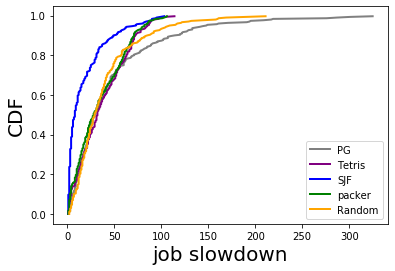

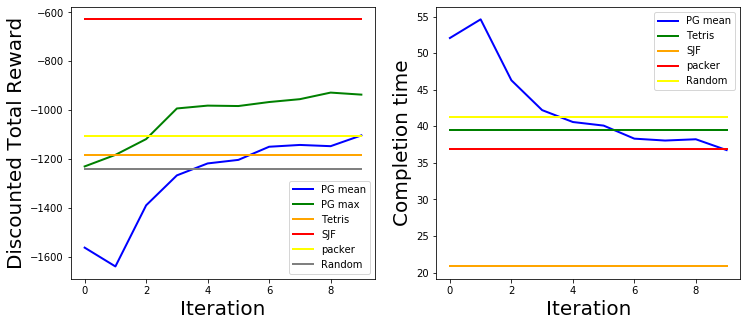

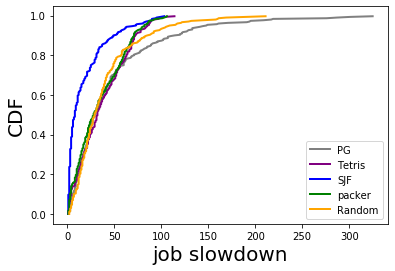

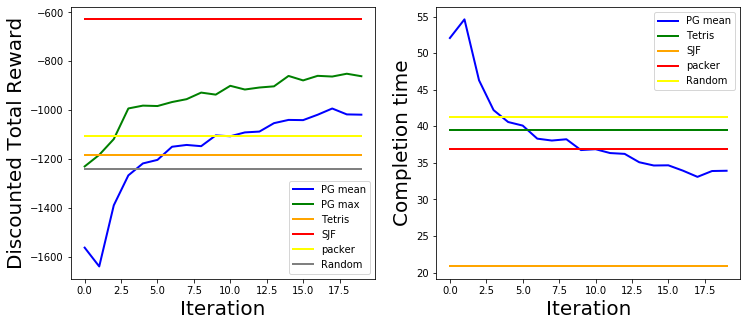

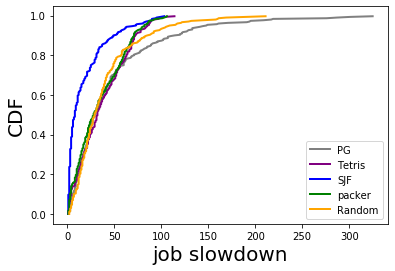

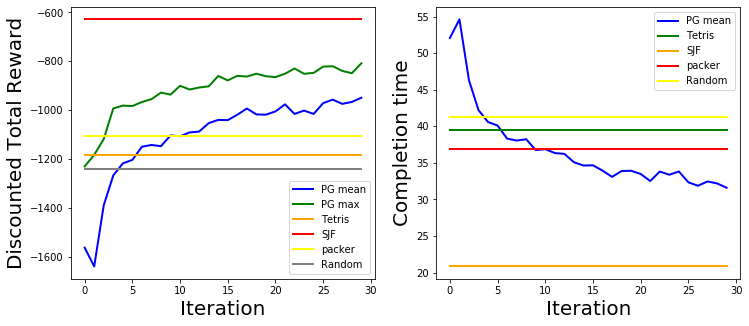

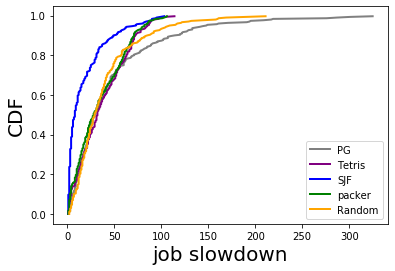

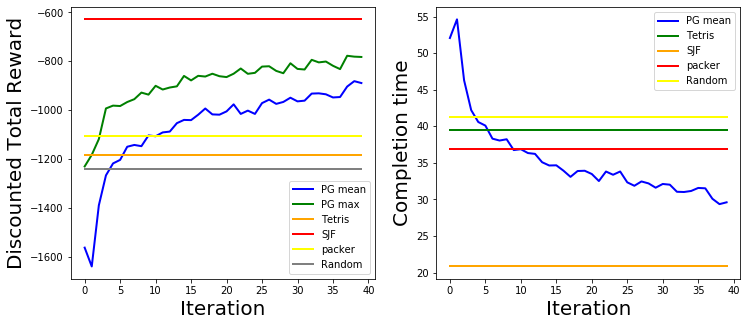

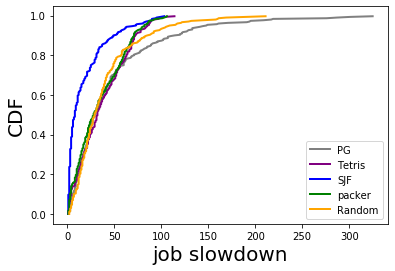

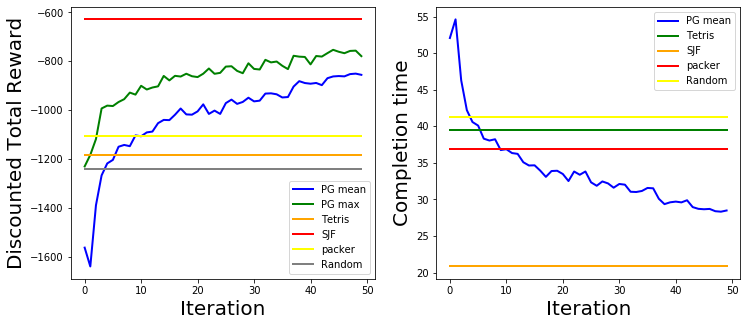

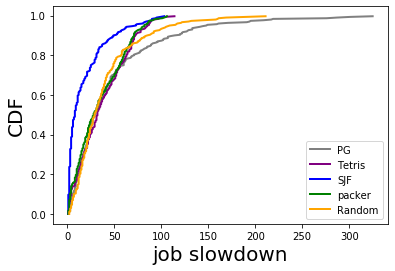

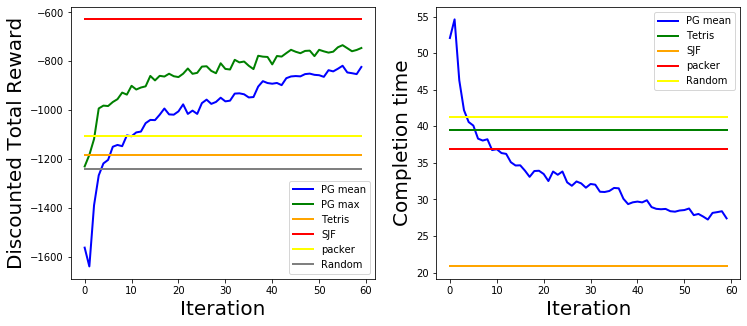

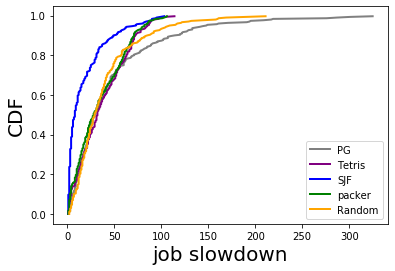

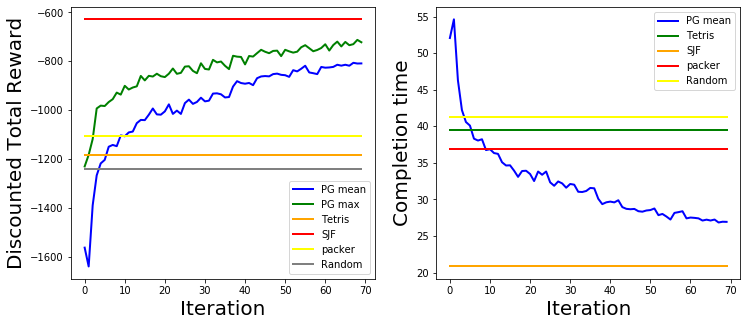

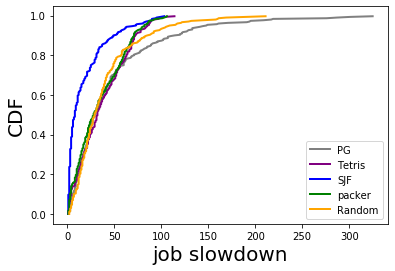

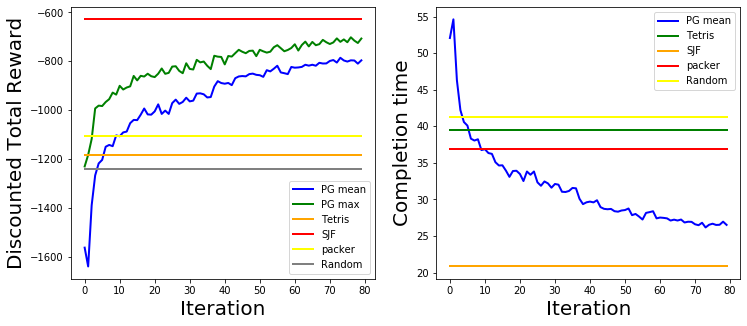

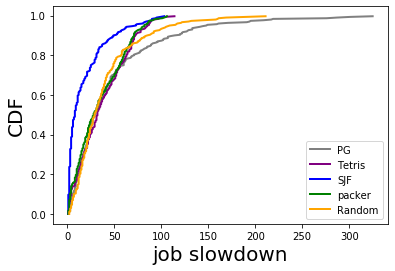

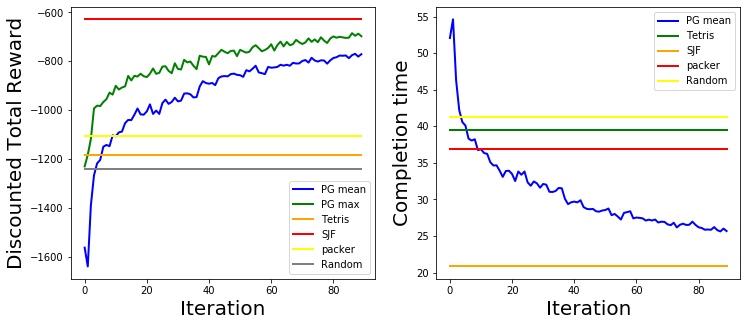

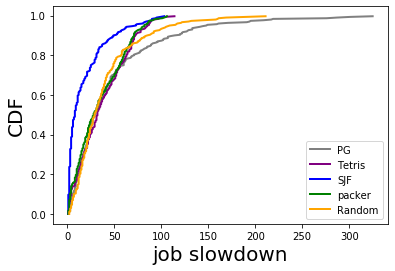

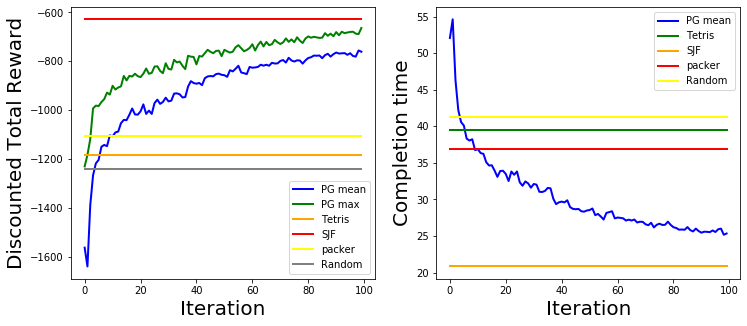

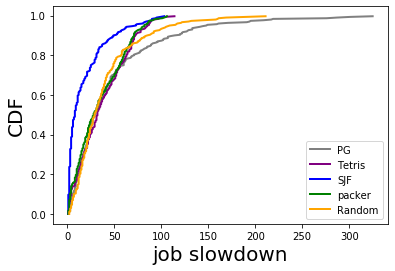

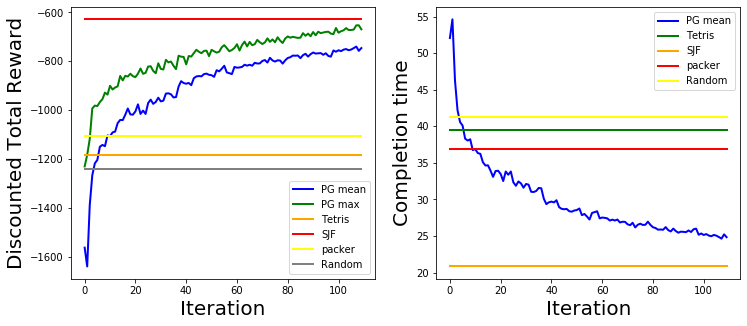

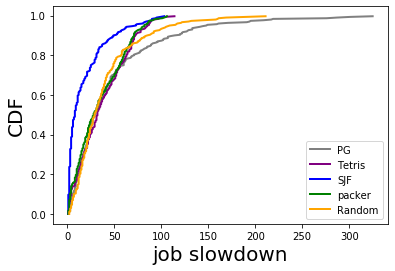

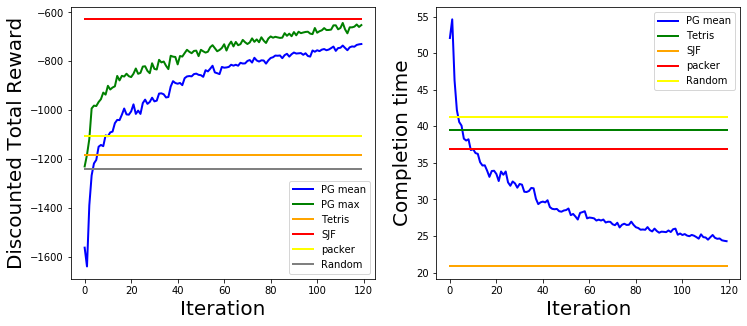

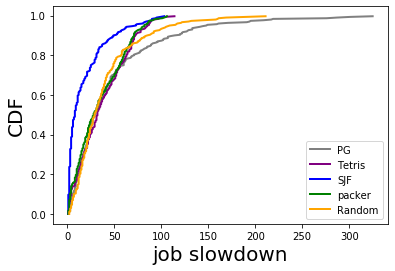

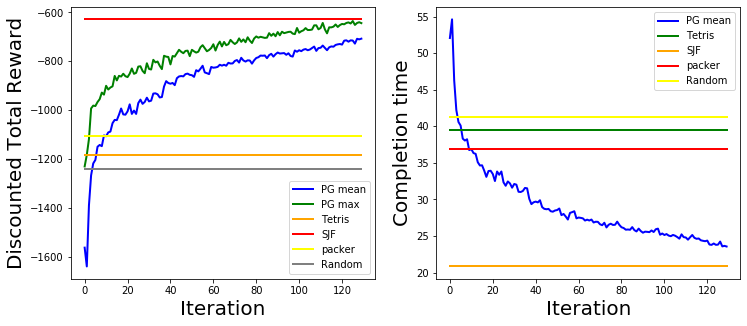

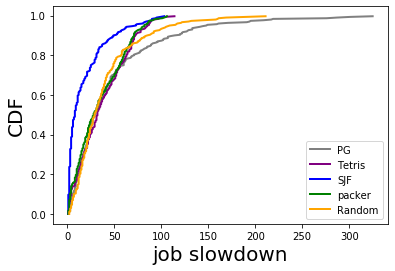

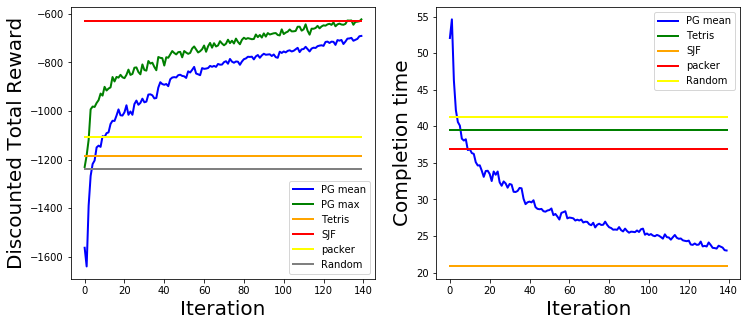

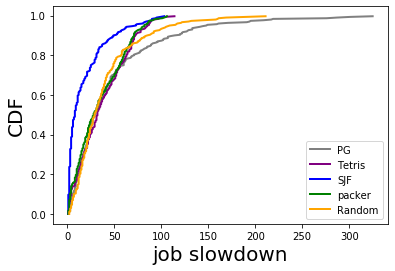

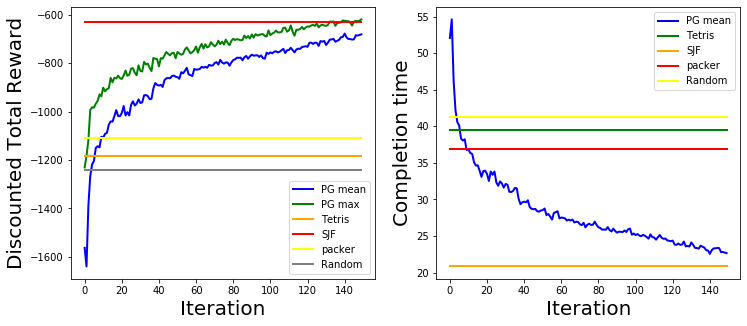

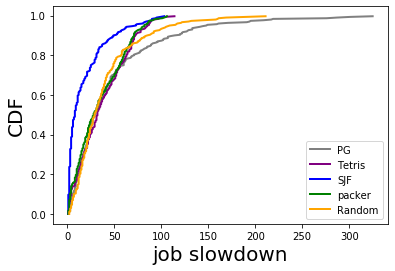

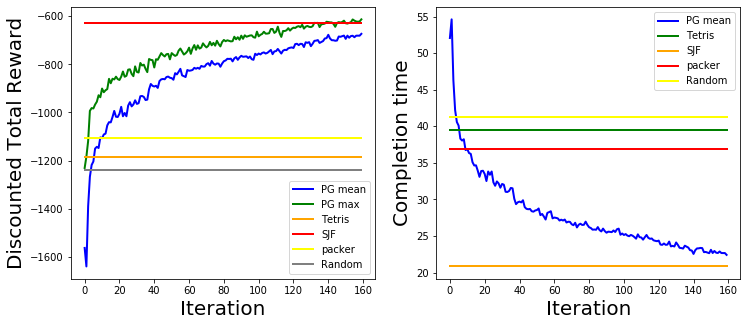

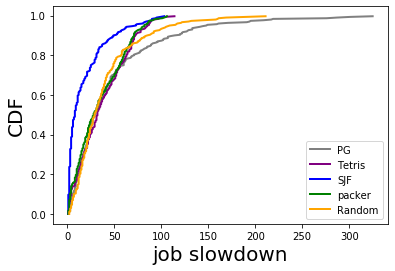

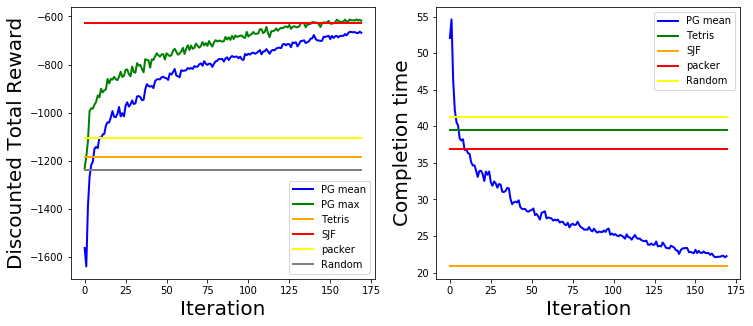

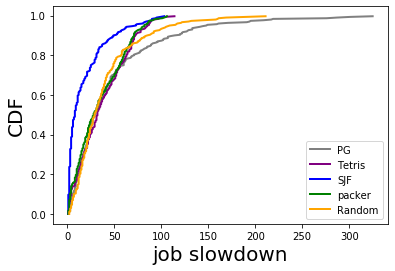

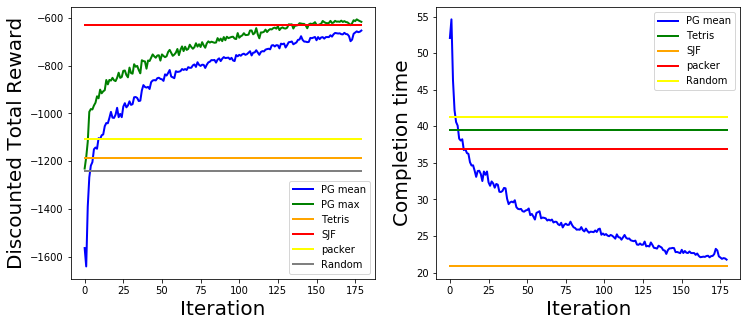

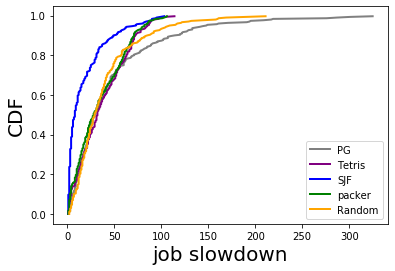

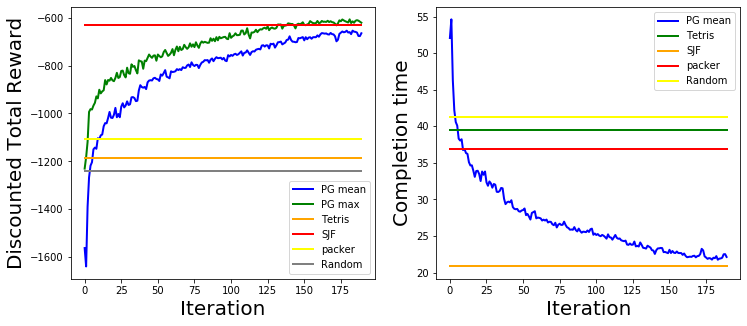

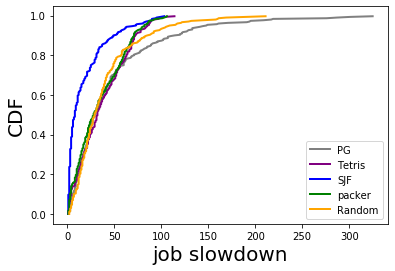

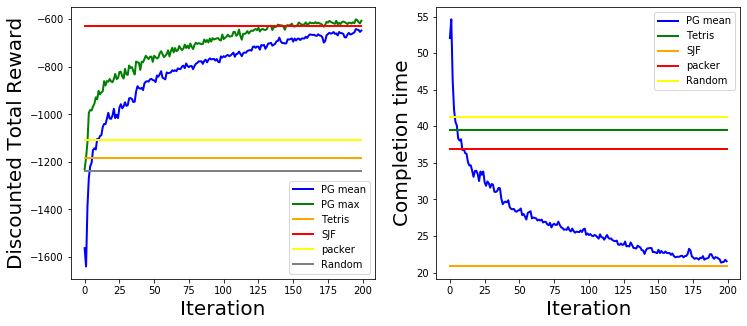

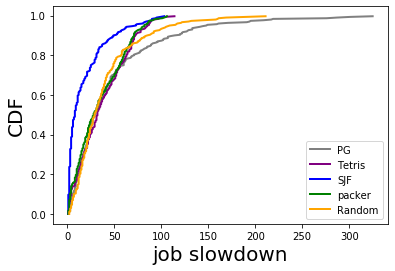

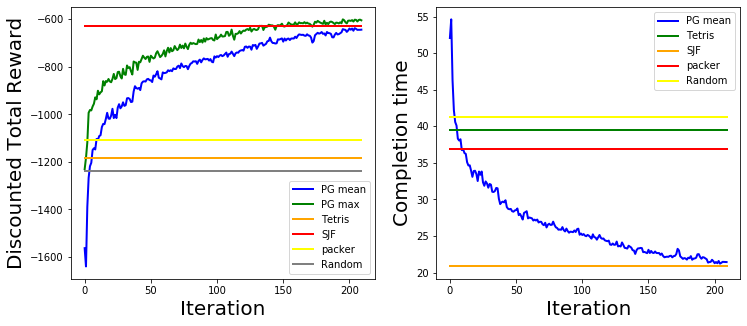

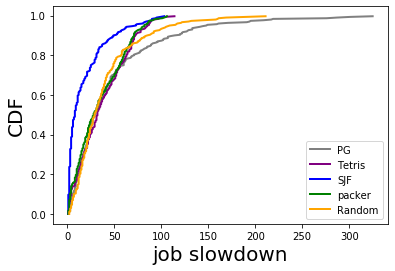

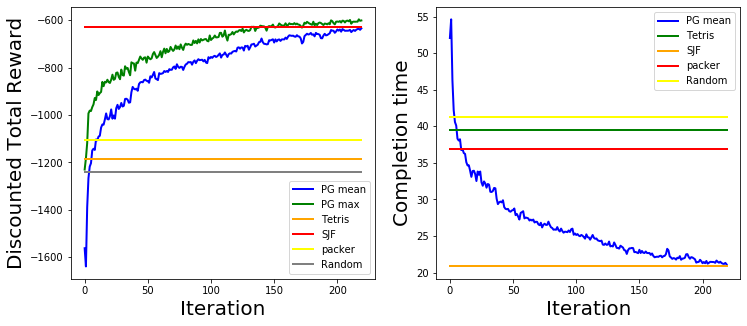

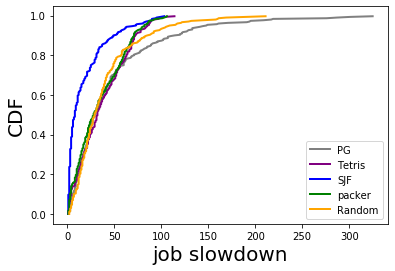

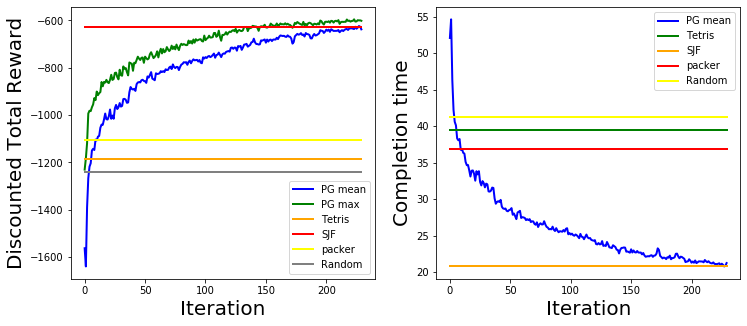

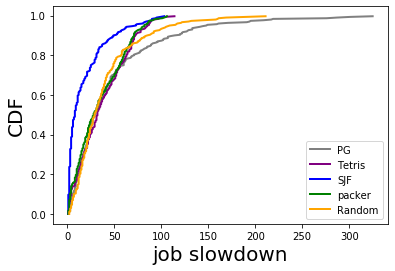

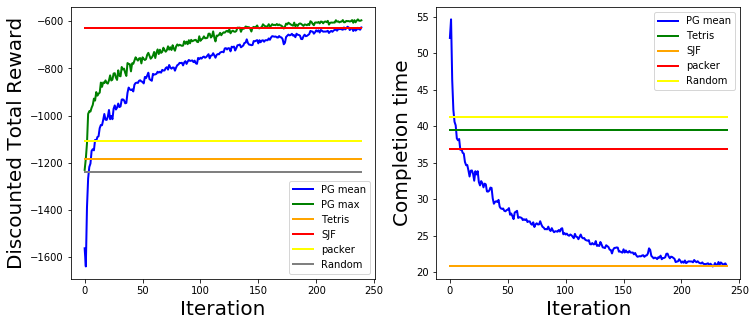

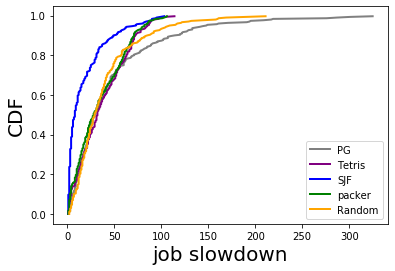

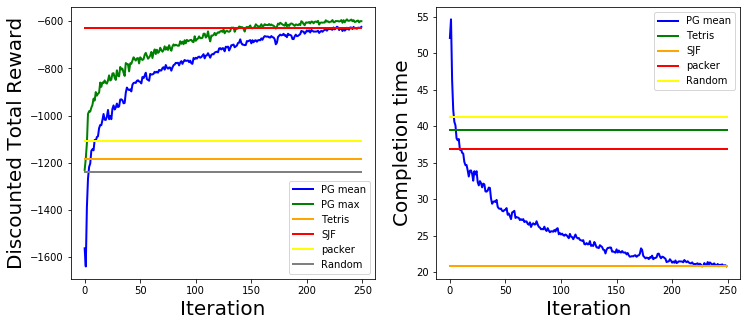

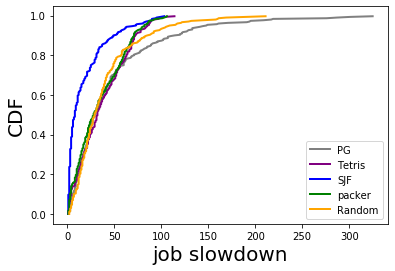

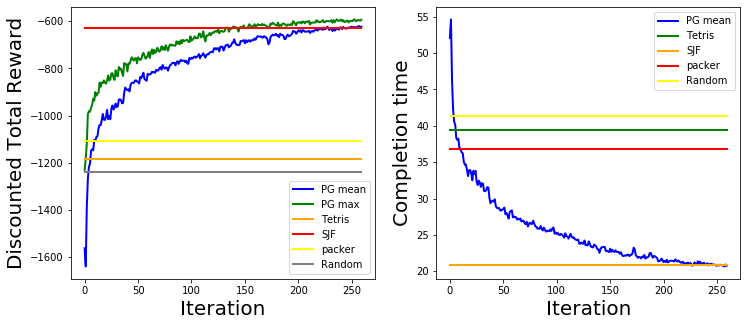

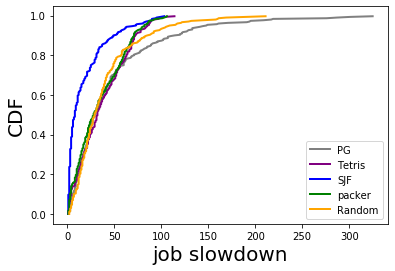

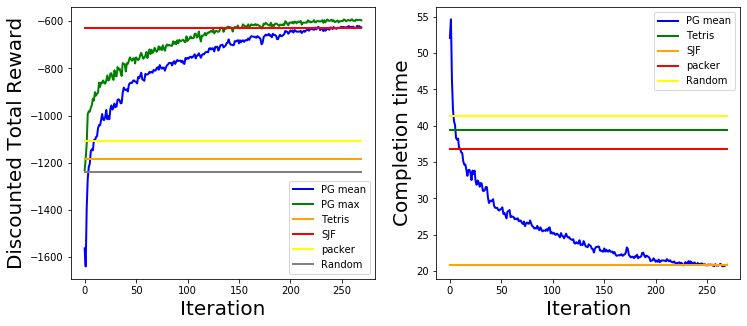

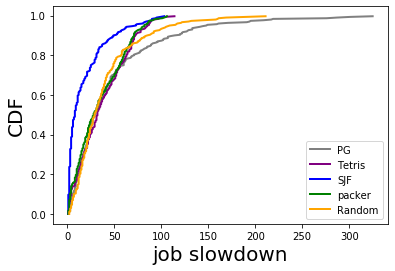

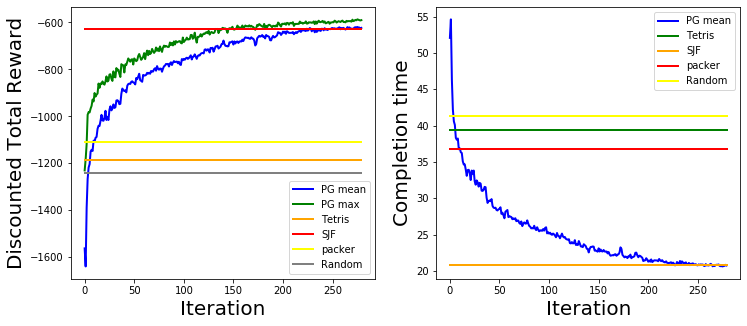

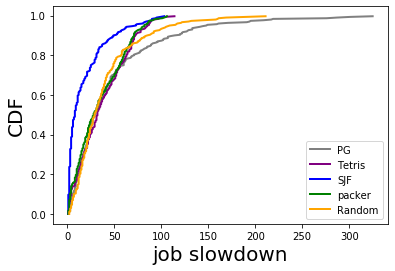

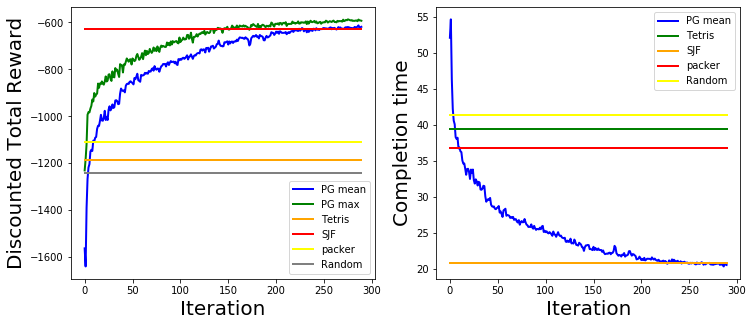

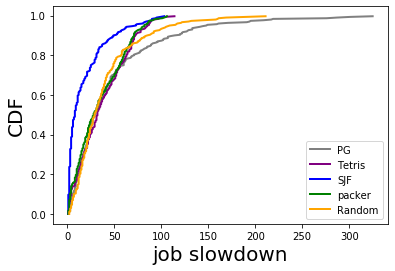

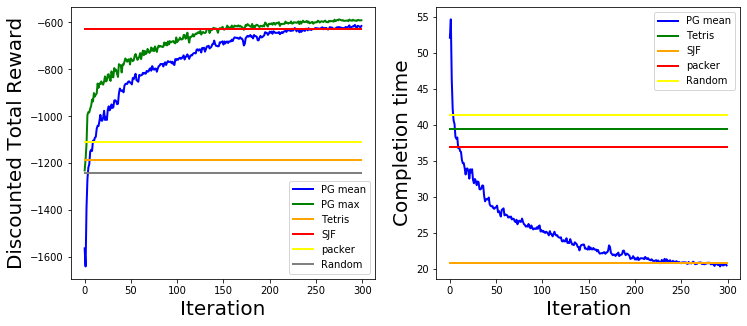

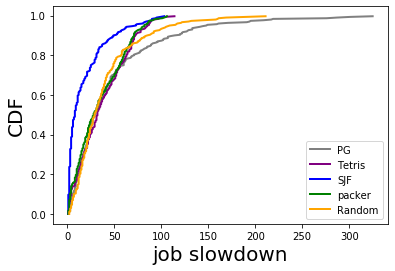

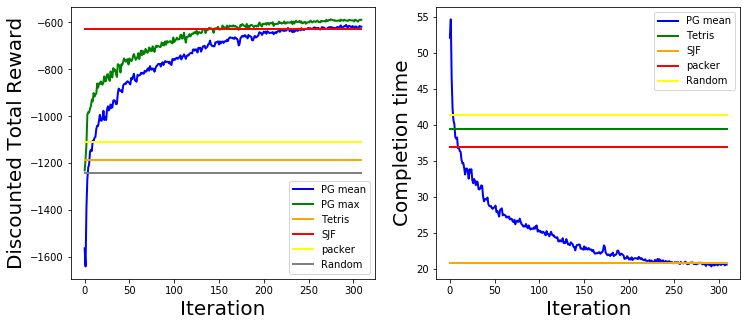

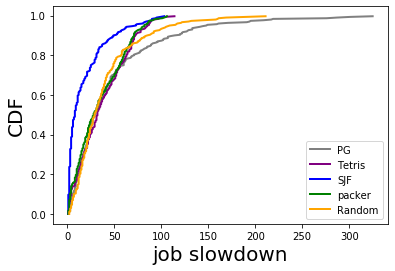

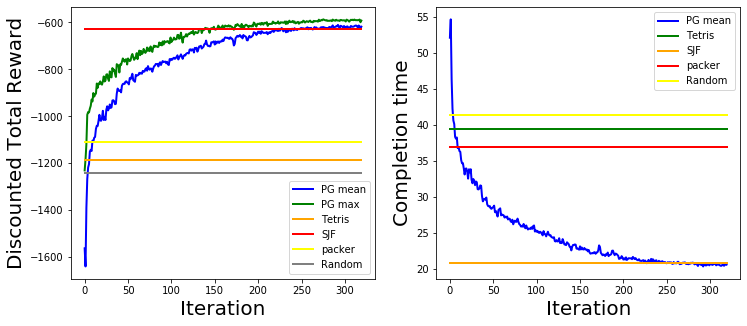

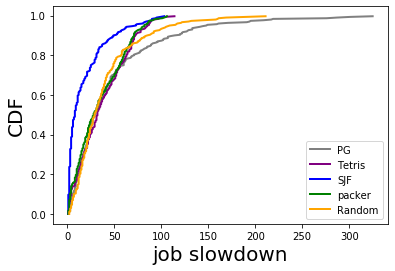

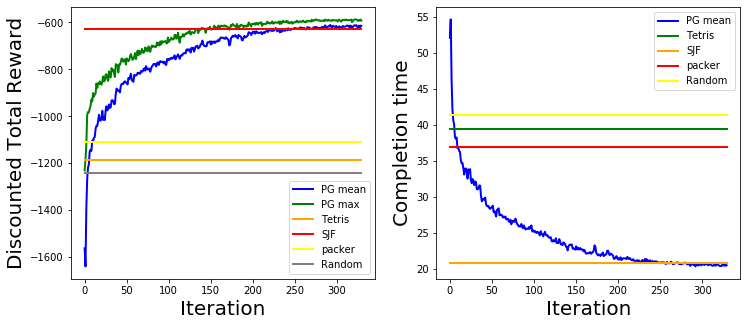

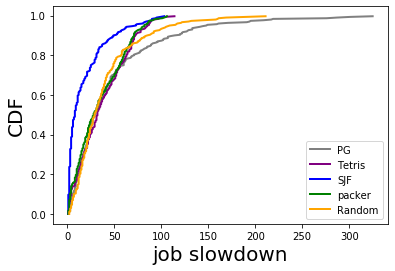

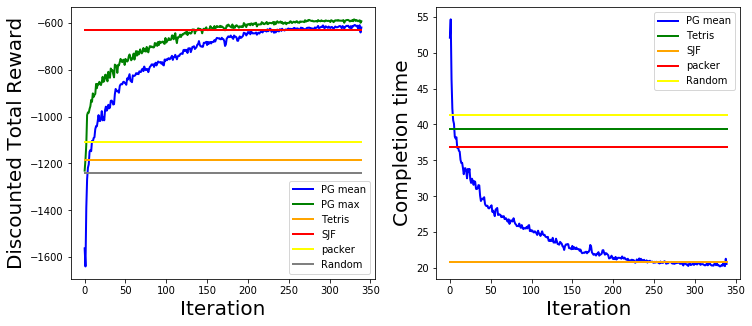

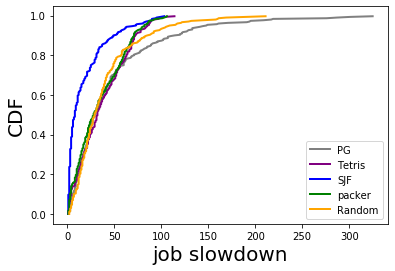

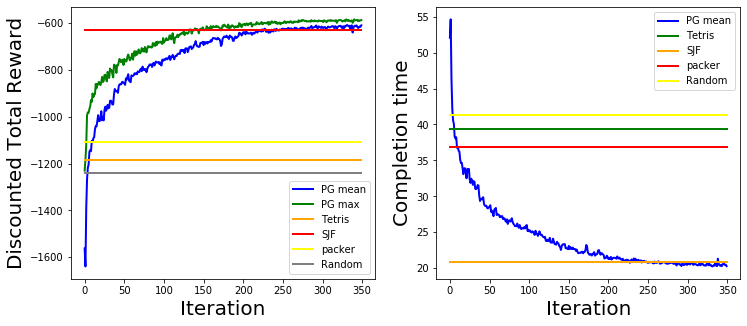

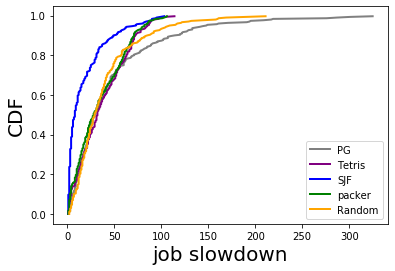

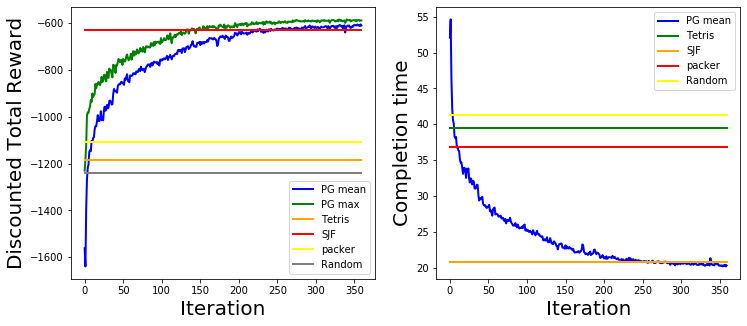

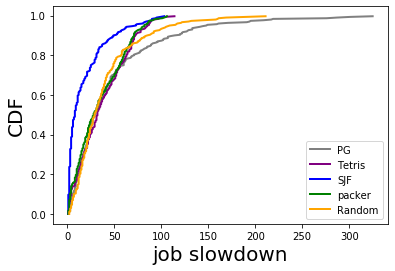

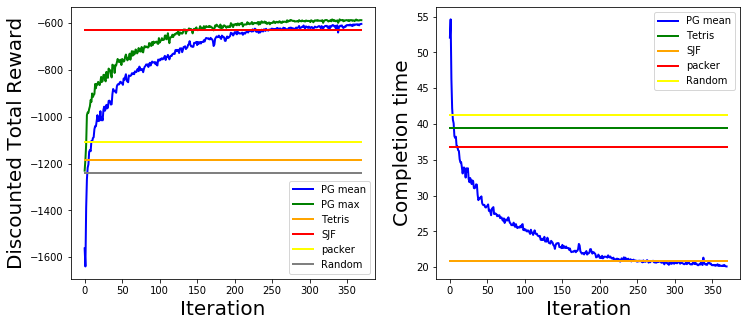

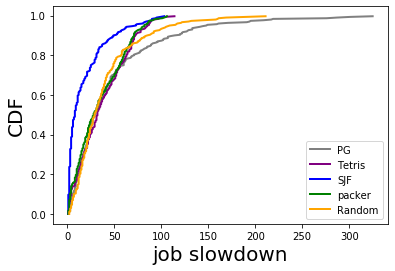

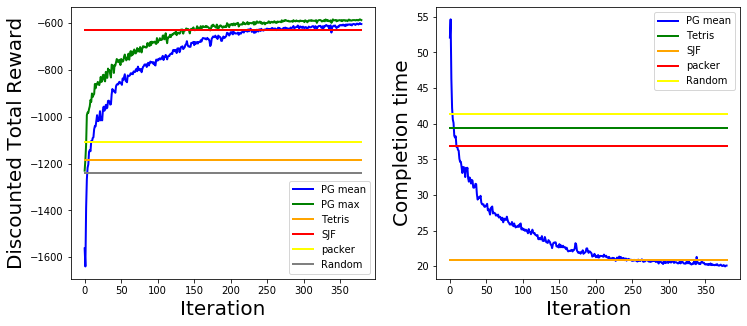

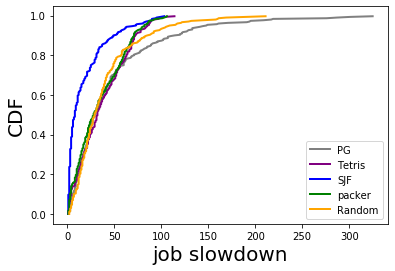

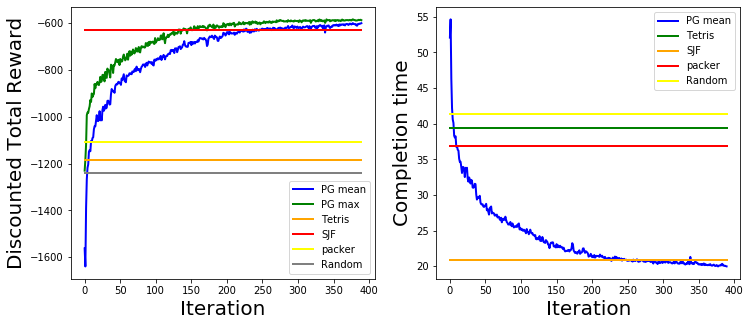

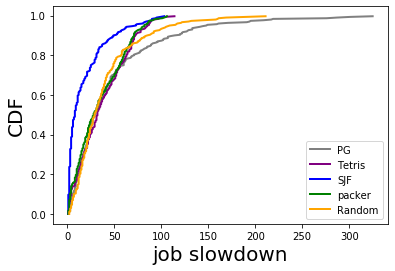

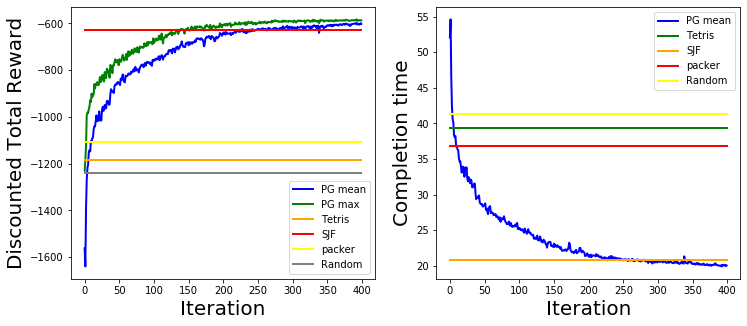

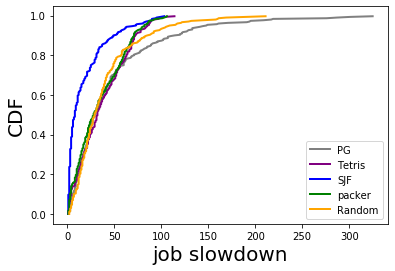

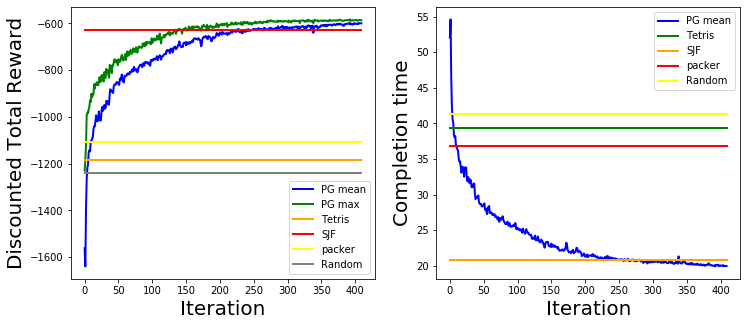

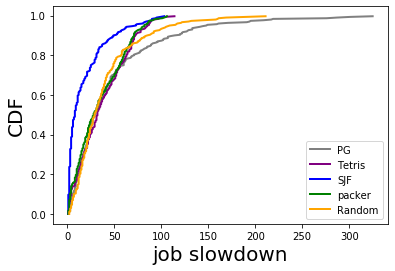

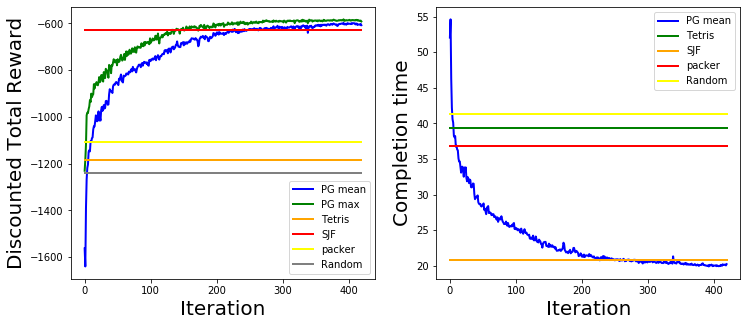

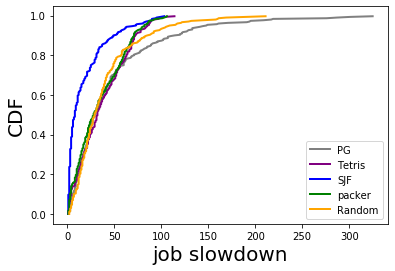

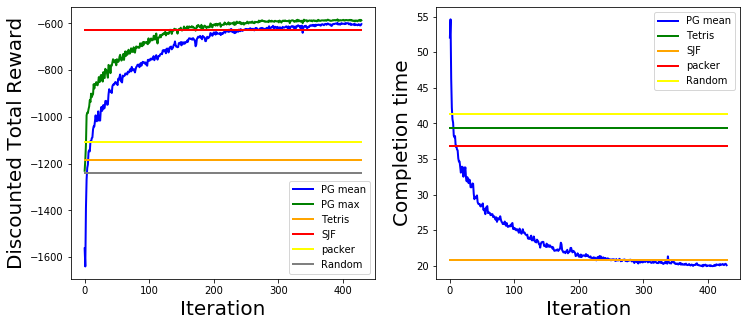

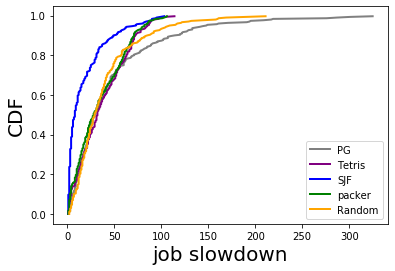

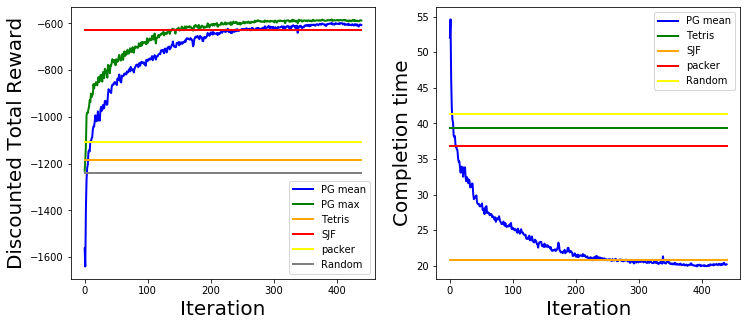

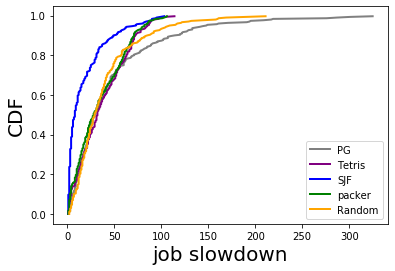

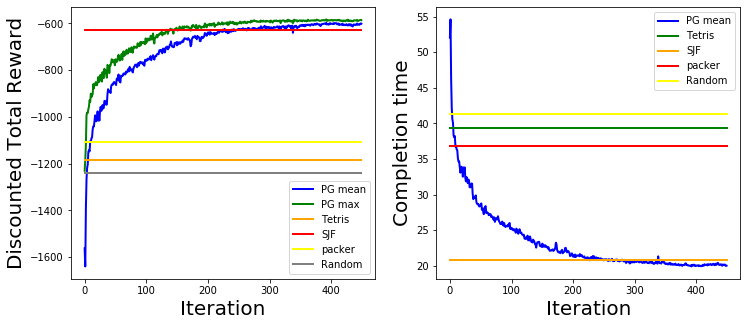

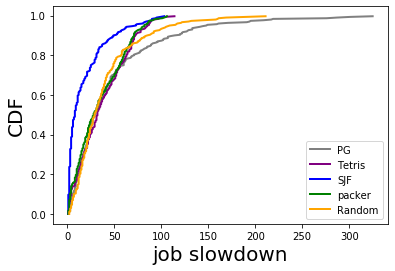

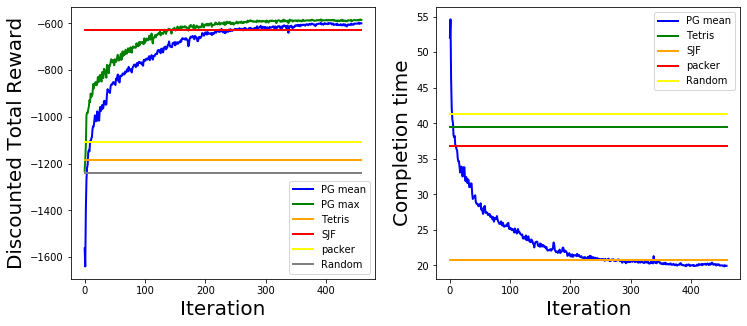

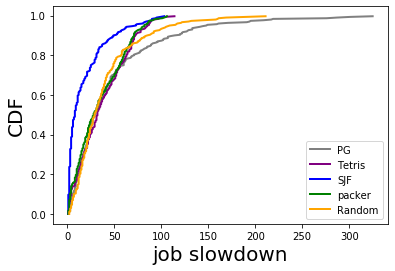

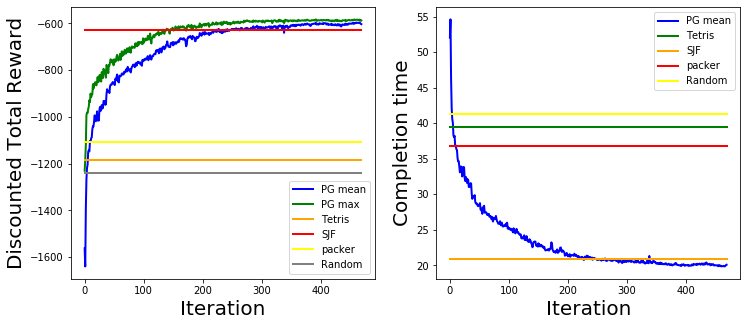

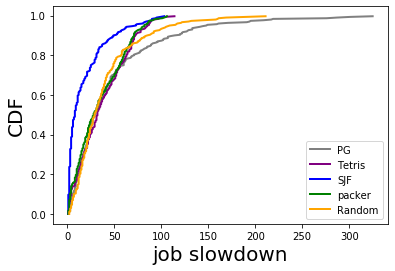

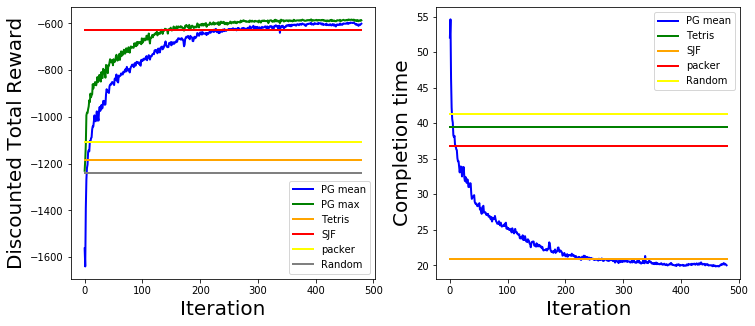

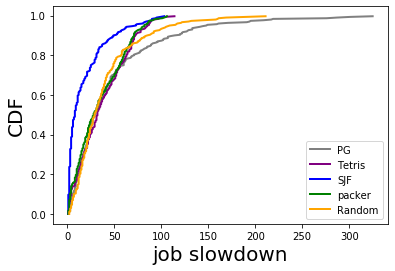

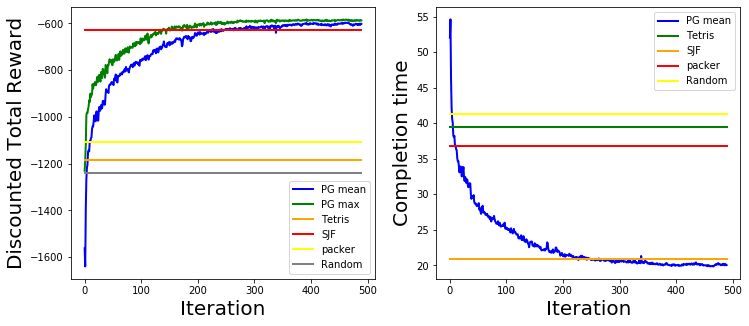

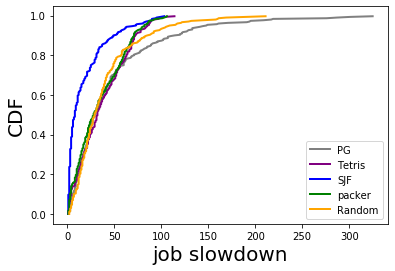

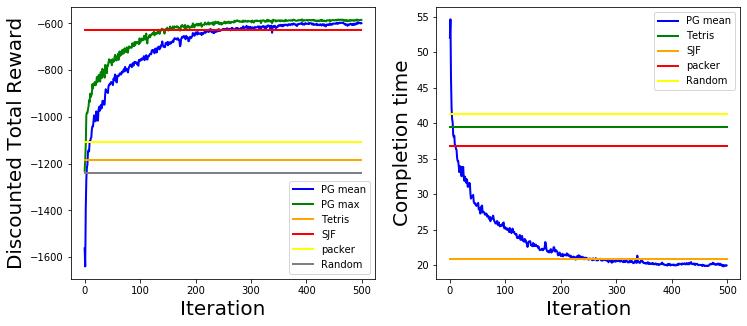

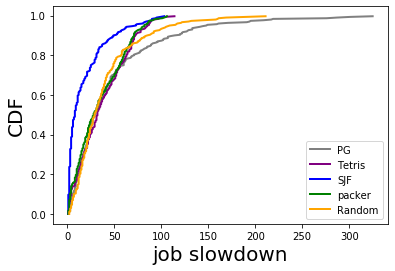

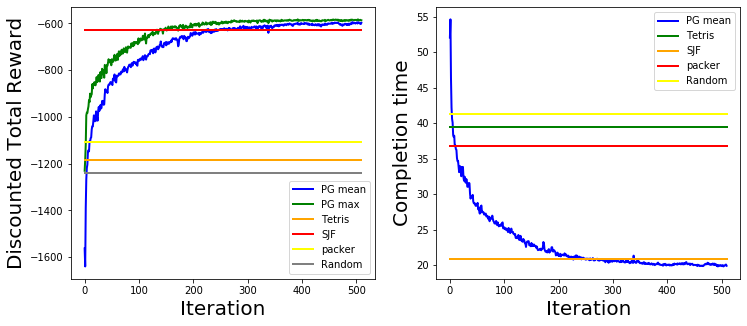

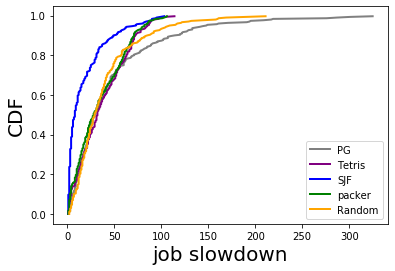

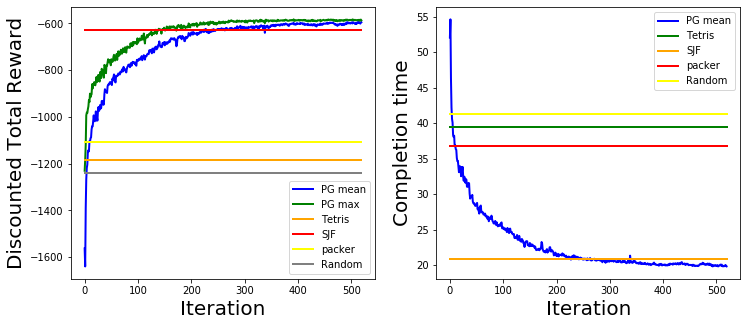

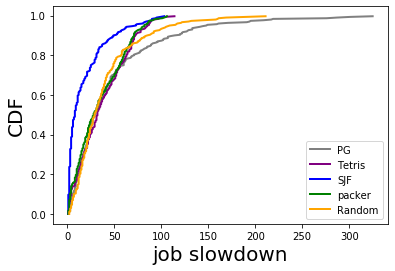

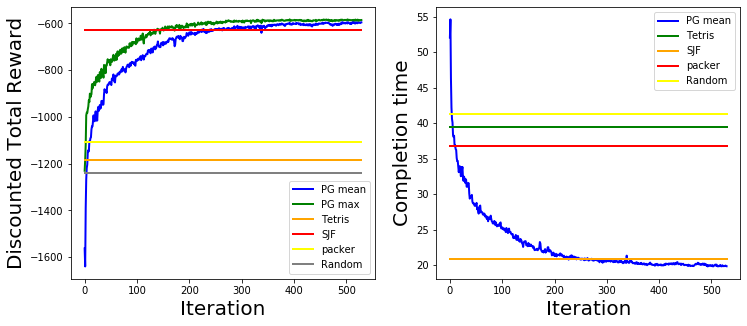

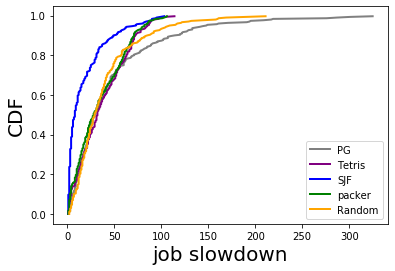

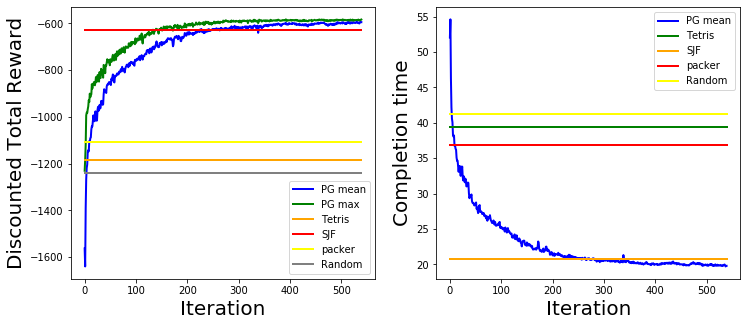

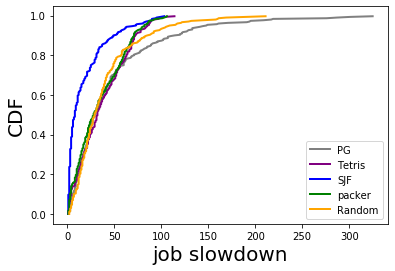

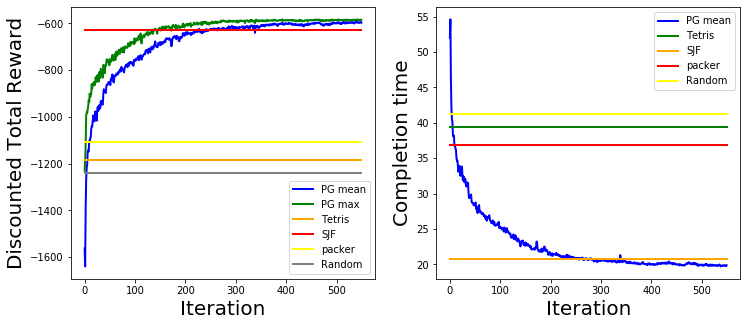

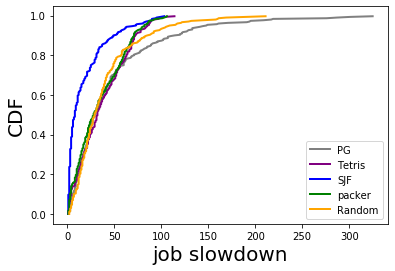

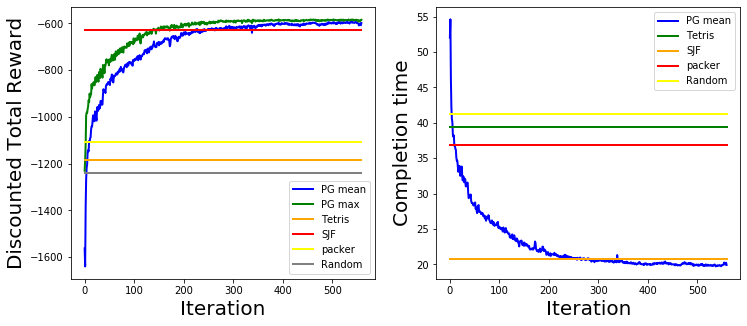

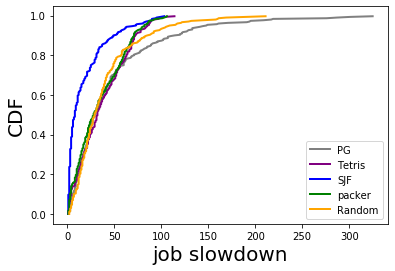

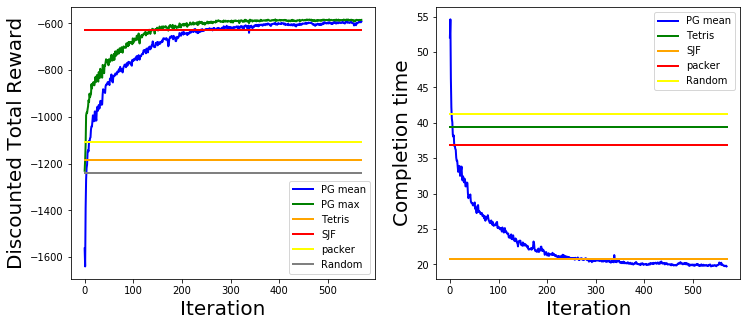

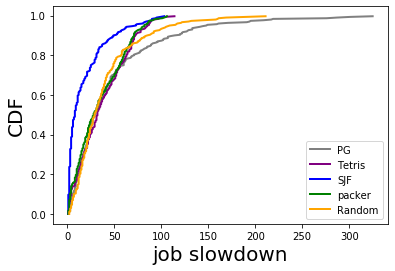

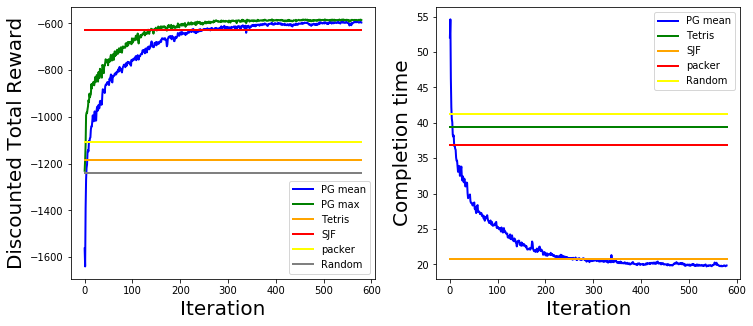

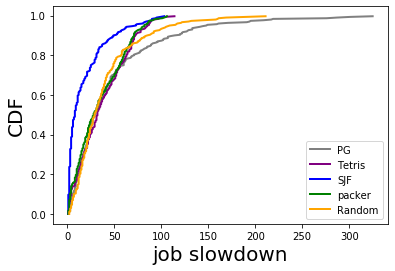

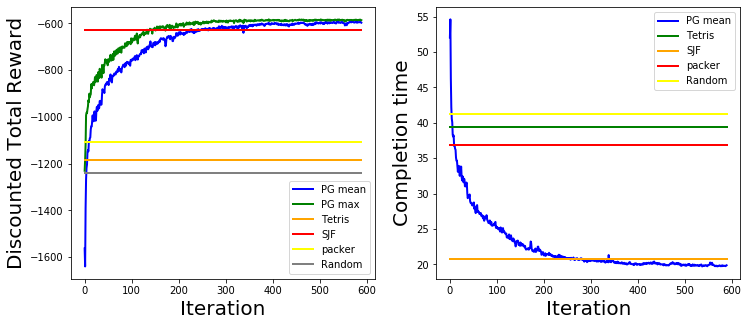

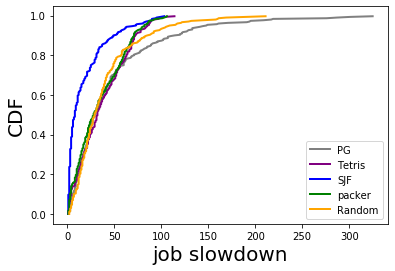

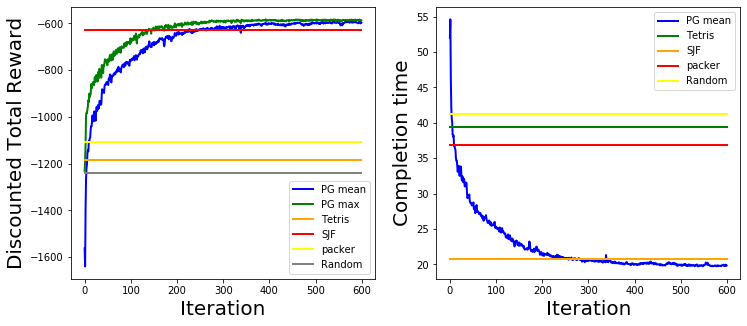

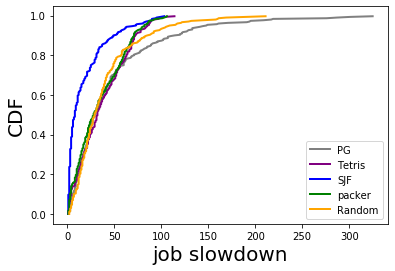

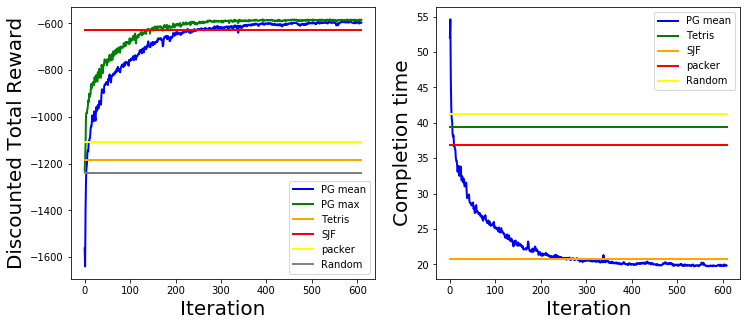

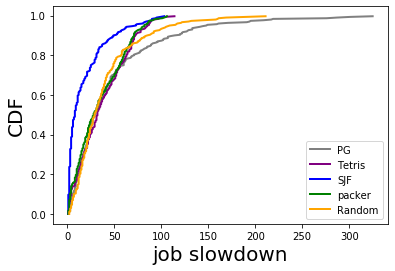

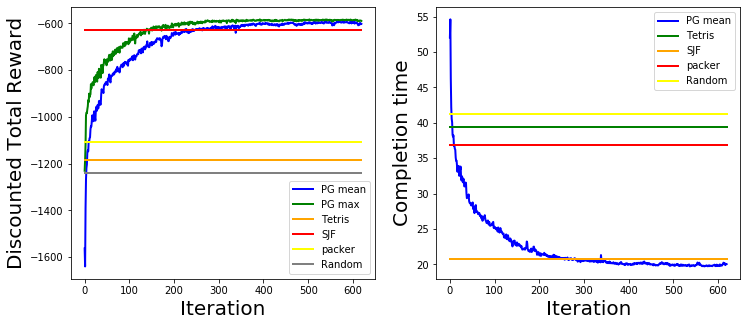

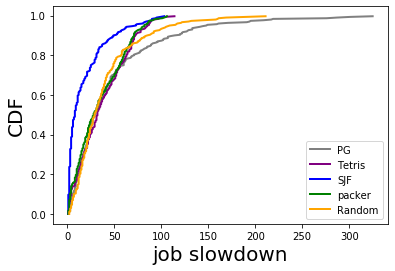

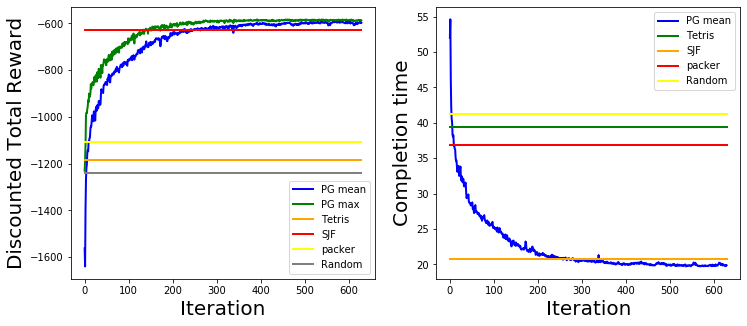

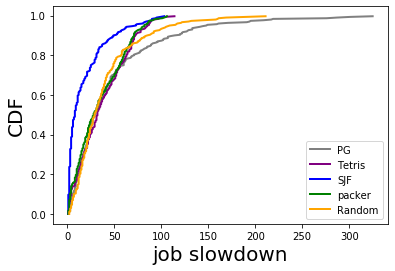

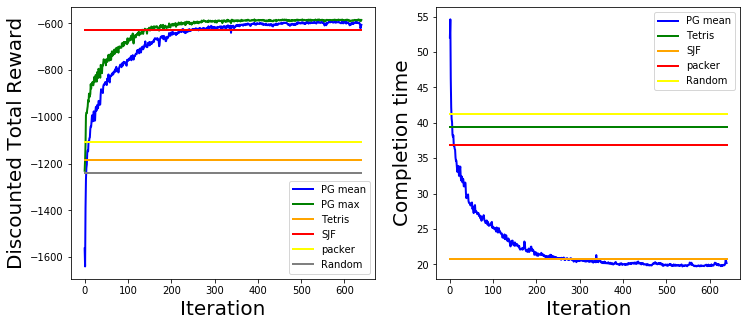

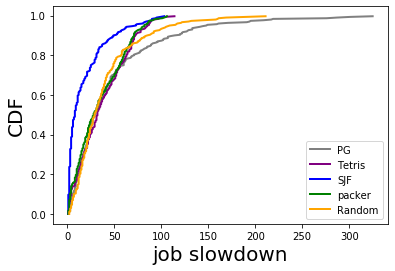

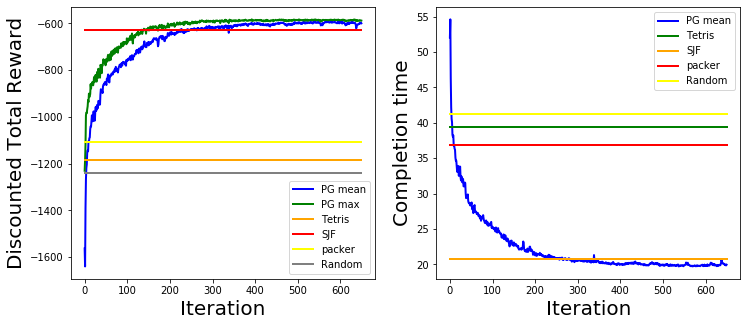

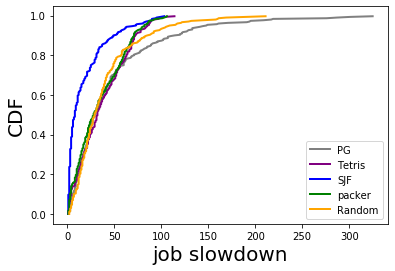

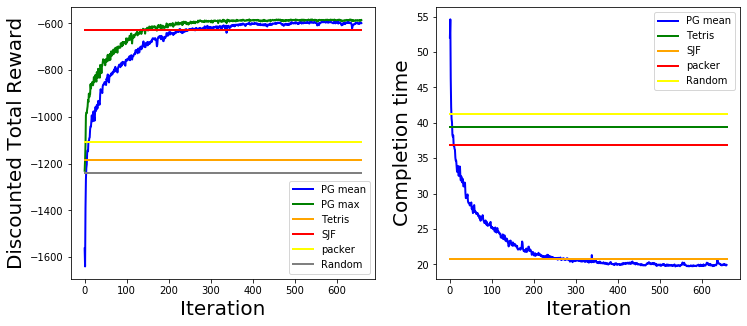

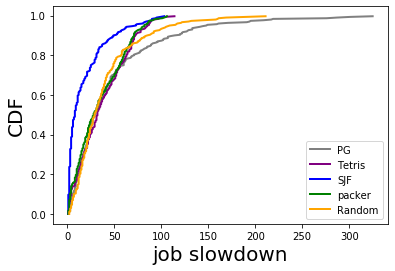

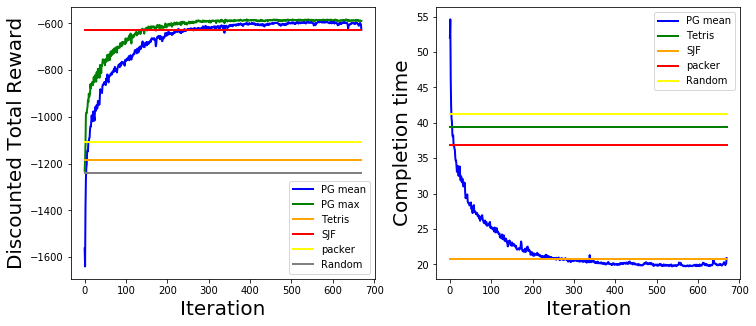

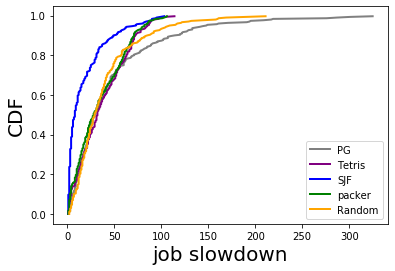

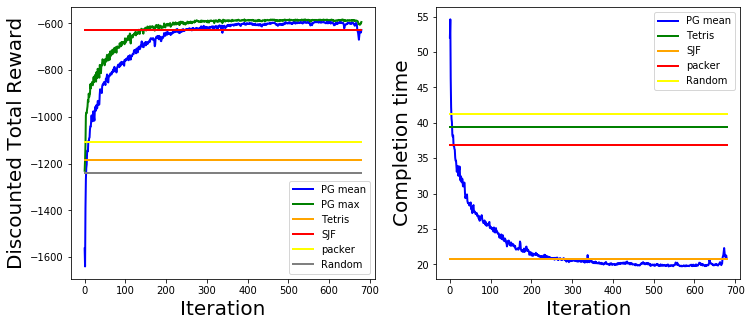

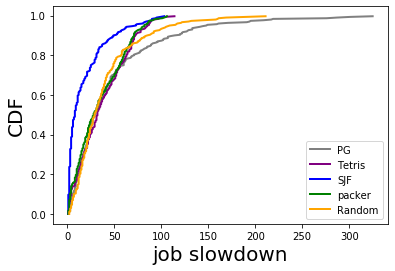

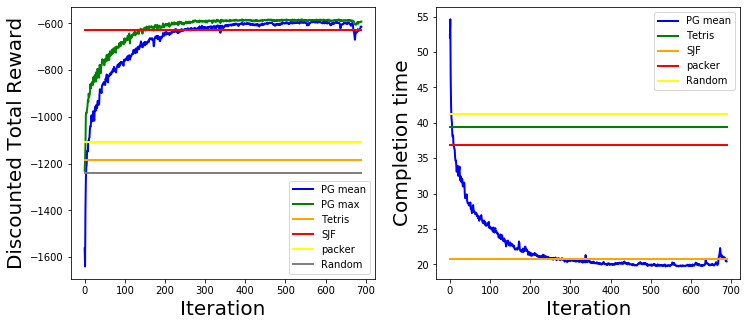

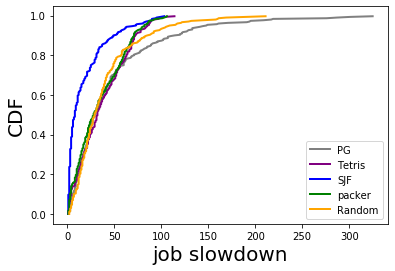

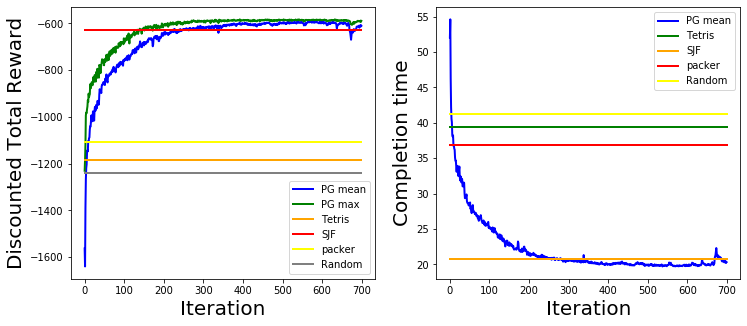

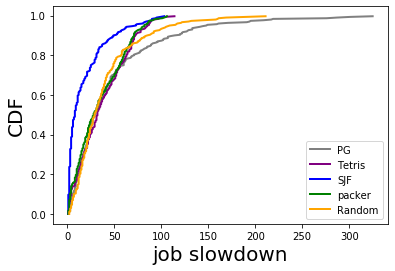

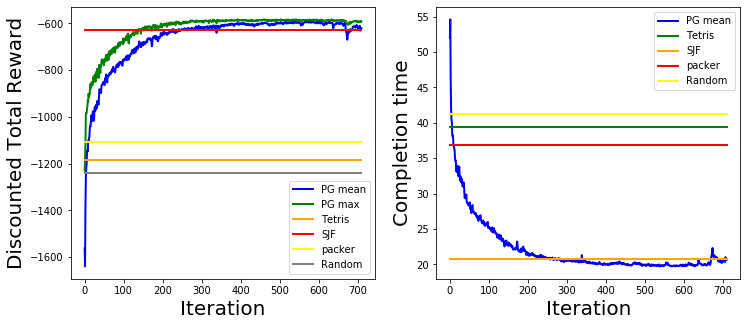

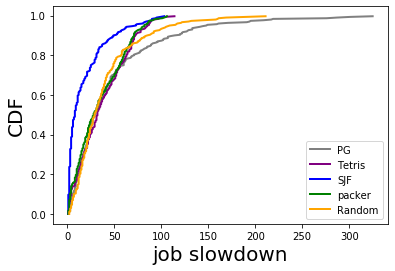

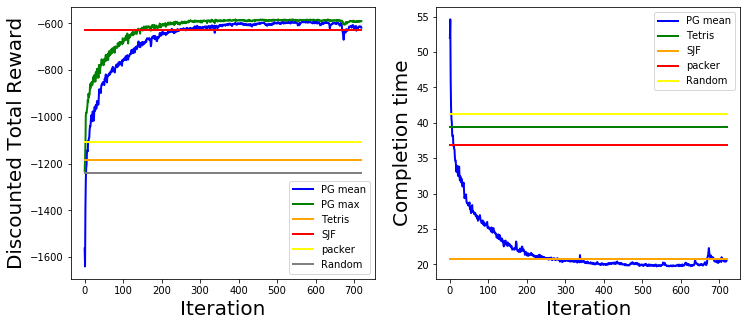

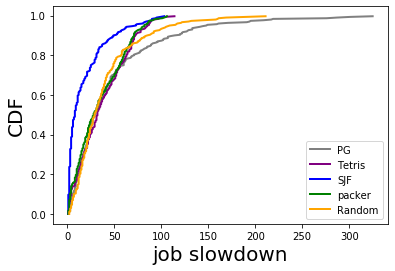

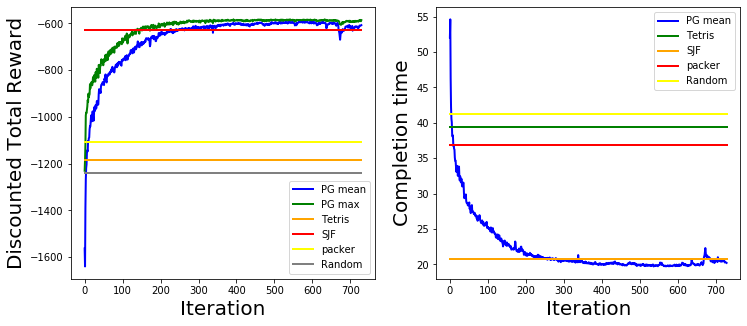

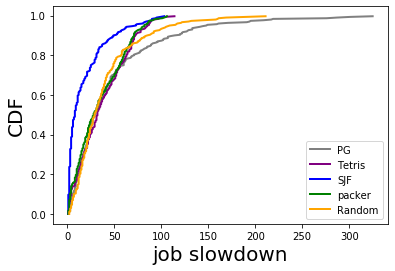

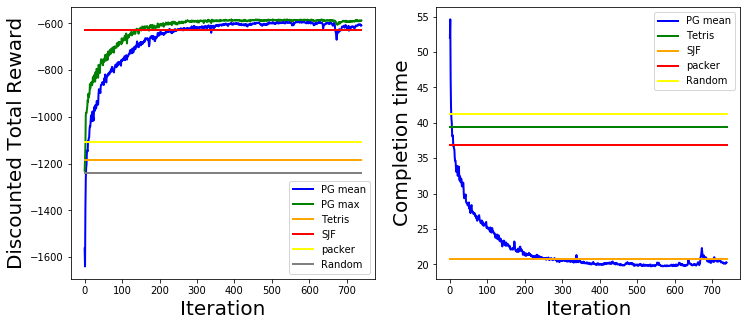

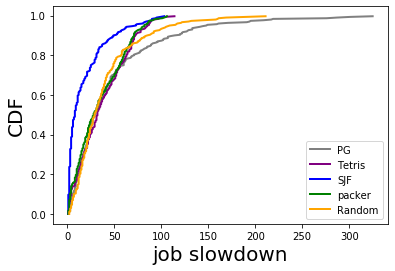

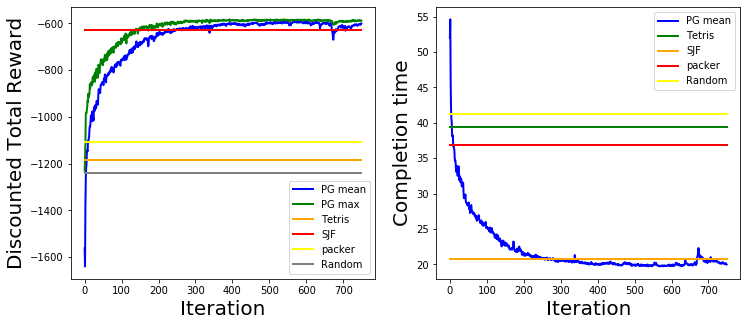

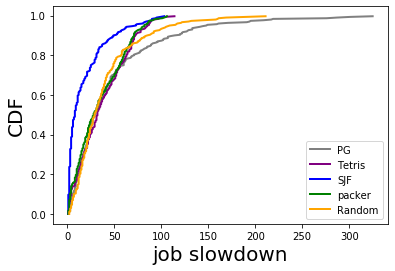

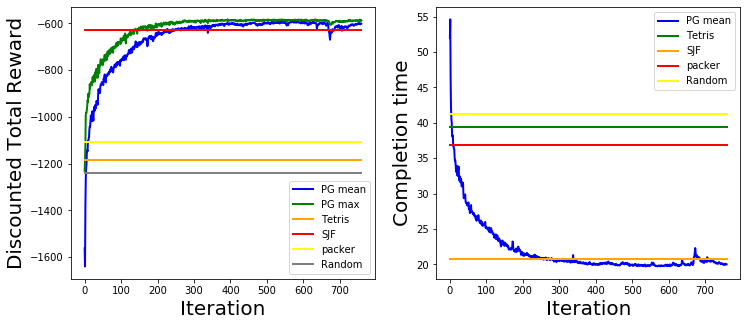

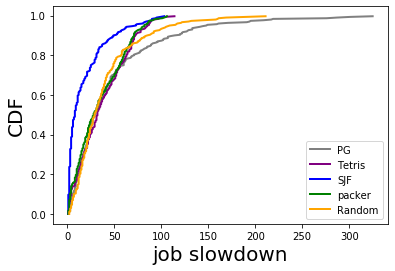

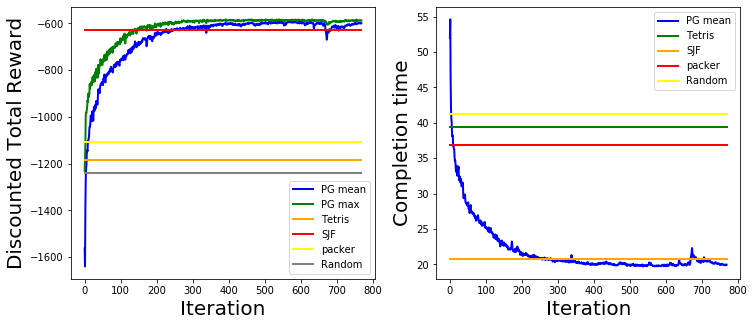

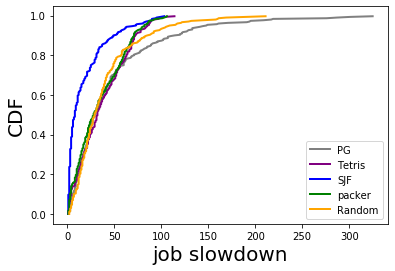

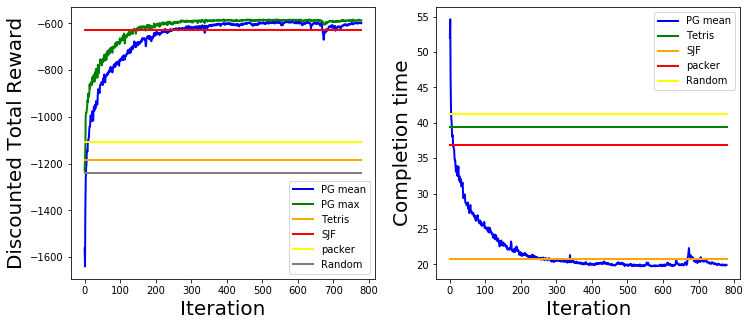

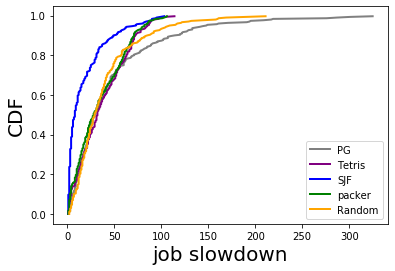

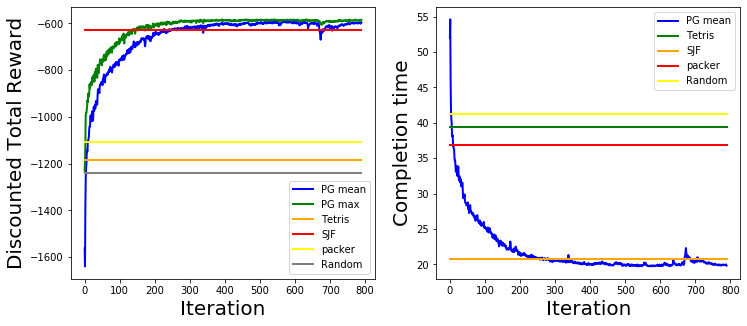

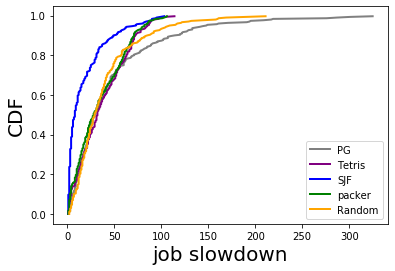

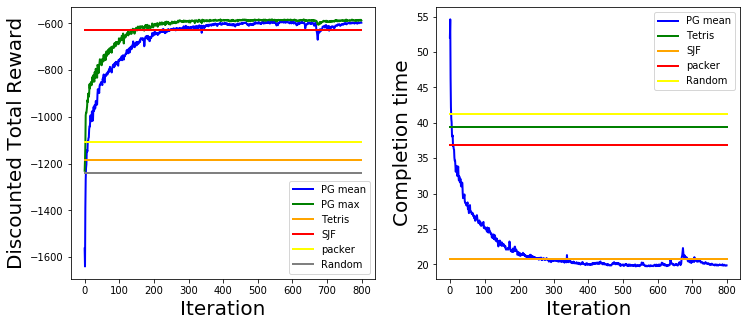

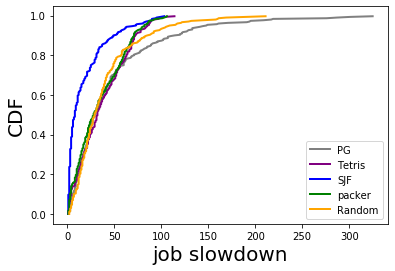

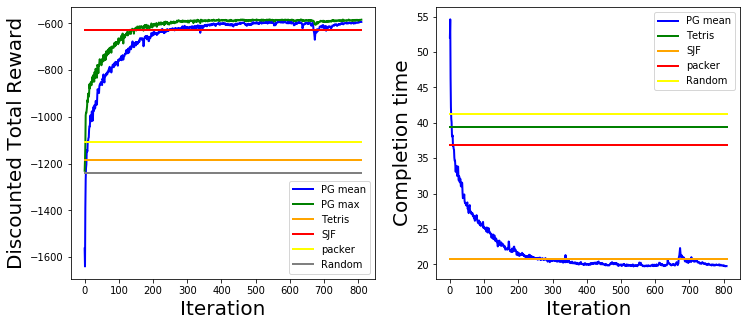

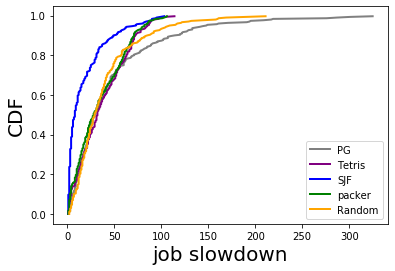

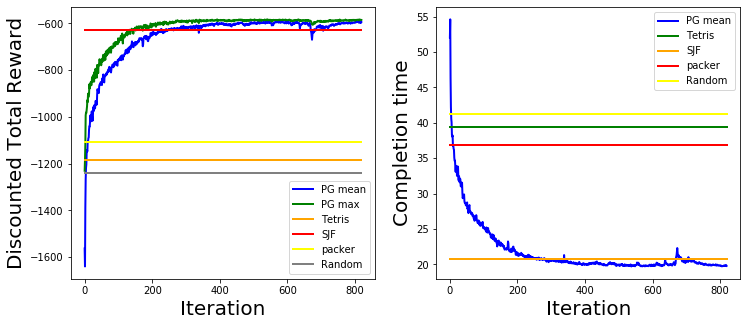

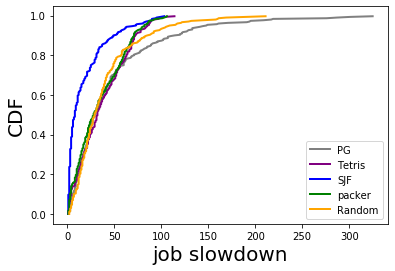

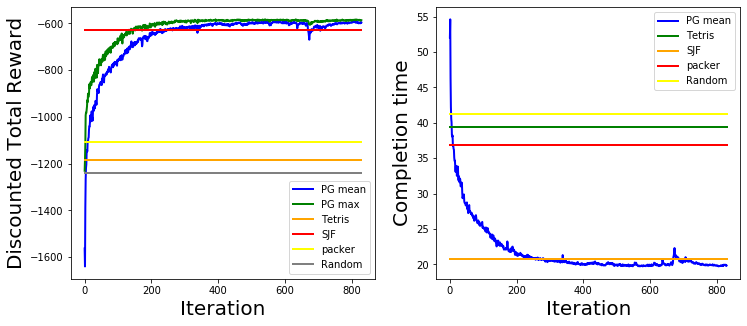

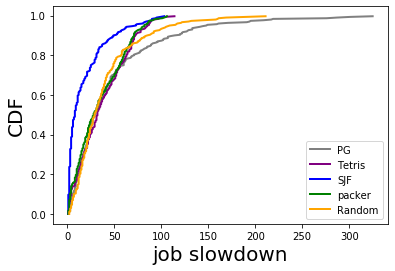

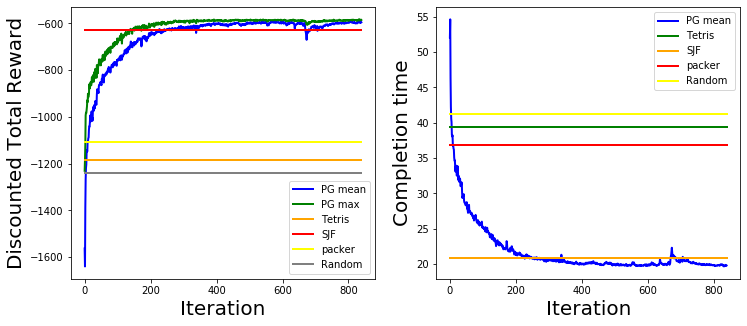

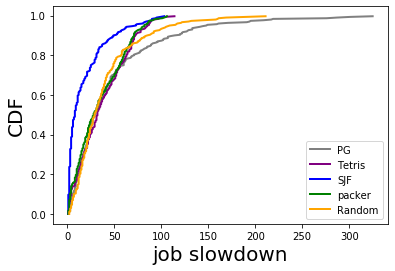

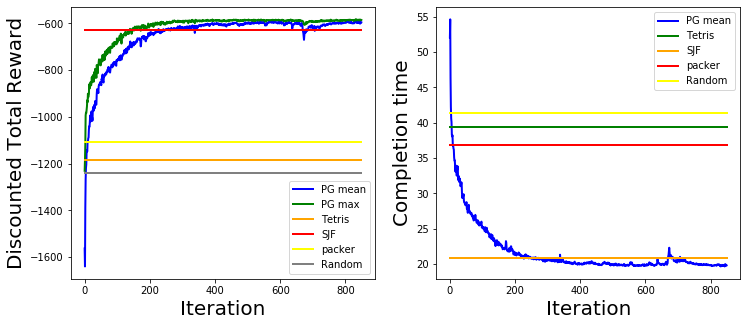

In [10]:
def launch(pa, pg_resume=None, render=False, repre='image', end='no_new_job'):

    # ----------------------------
    print("Preparing for workers...")
    # ----------------------------

    pg_learners = []
    envs = []

    nw_len_seqs, nw_size_seqs = job_distribution.generate_sequence_work(pa, seed=42)#生成一序列的任务，其中包括num_ex个task

    for ex in range(pa.num_ex):#对于每个task

        print("-prepare for env-", ex)

        env = environment.Env(pa, nw_len_seqs=nw_len_seqs, nw_size_seqs=nw_size_seqs,
                              render=False, repre=repre, end=end)#初始化一个环境
        env.seq_no = ex
        envs.append(env)

    print("-prepare for worker-")

    rl = RL_brain.PolicyGradient(n_actions=pa.network_output_dim,
                                 network_input_height=pa.network_input_height,
                                 network_input_width=pa.network_input_width,
                                 n_features=pa.network_input_height*pa.network_input_width,
                                 learning_rate=0.002)


    if pg_resume is not None:
        rl.load_data(pg_resume)


    # --------------------------------------
    print("Preparing for reference data...")
    # --------------------------------------

    ref_discount_rews, ref_slow_down = slow_down_cdf.launch(pa, pg_resume=None,render=True,
                                                            plot=False, repre=repre, end=end)
    mean_rew_lr_curve = []
    max_rew_lr_curve = []
    slow_down_lr_curve = []

    # --------------------------------------
    print("Start training...")
    # --------------------------------------

    timer_start = time.time()
    
    ref_lr_gurobi=[]

    for iteration in range(1, pa.num_epochs):#进行每一次迭代
    #for iteration in range(1, 2):

        ex_indices = list(range(pa.num_ex))
        np.random.shuffle(ex_indices)#打乱每一次的所有task

        all_eprews = []#所有迭代次数的rewards
        eprews = []#每次迭代的总rewards
        eplens = []#每次迭代完成所有任务的总时长
        all_slowdown = []#所有迭代的总slowdown

        eprewlist = []
        eplenlist =[]
        slowdownlist =[]
        losslist = []
        

        ex_counter = 0
        for ex in range(pa.num_ex):

            ex_idx = ex_indices[ex]

            eprew, eplen, completion_time, all_ob, all_action, all_adv = get_traj_worker(rl, envs[ex_idx], pa)
            eprewlist.append(eprew)
            eplenlist.append(eplen)
            slowdownlist.append(completion_time)
            
            
            loss = rl.learn(all_ob, all_action, all_adv)
            losslist.append(loss)

            ex_counter += 1

            if ex_counter >= pa.batch_size or ex == pa.num_ex - 1:

                print("\n\n")

                ex_counter = 0

               

        timer_end = time.time()

        print("-----------------")
        print("Iteration: \t %i" % iteration)
        print("NumTrajs: \t %i" % len(eprewlist))
        print("NumTimesteps: \t %i" % np.sum(eplenlist))
        print("Loss:     \t %s" % np.mean(losslist))
        print("MaxRew: \t %s" % np.average([np.max(rew) for rew in eprewlist]))
        print("MeanRew: \t %s +- %s" % (np.mean(eprewlist), np.std(eprewlist)))
        print("MeanSlowdown: \t %s" % np.mean([np.mean(sd) for sd in slowdownlist]))
        print("MeanLen: \t %s +- %s" % (np.mean(eplenlist), np.std(eplenlist)))
        print("Elapsed time\t %s" % (timer_end - timer_start), "seconds")
        print("-----------------")

        timer_start = time.time()

        max_rew_lr_curve.append(np.average([np.max(rew) for rew in eprewlist]))
        mean_rew_lr_curve.append(np.mean(eprewlist))
        slow_down_lr_curve.append(np.mean([np.mean(sd) for sd in slowdownlist]))
        
        #slowdown_gurobi=ref_gurobi(pa)
        #ref_lr_gurobi.append(slowdown_gurobi)
        
        
        if iteration % pa.output_freq == 0:

            rl.save_data(pa.output_filename + '_' + str(iteration))

            pa.unseen = True
            slow_down_cdf.launch(pa, pa.output_filename + '_' + str(iteration) + '.ckpt',render=False, plot=True, repre=repre, end=end)
            pa.unseen = False
            #print(slow_down_lr_curve)
            #mean_lr_gurobi=np.mean(ref_lr_gurobi)
            #for i in range(len(ref_lr_gurobi)):
                #ref_lr_gurobi[i]=mean_lr_gurobi

            plot_lr_curve(pa.output_filename,
                          max_rew_lr_curve, mean_rew_lr_curve, slow_down_lr_curve,
                          ref_discount_rews, ref_slow_down,ref_lr_gurobi)

def ref_gurobi(pa):
        
    nw_len_lst=np.zeros(pa.simu_len, dtype=int)
    nw_res_lst=np.zeros((pa.simu_len,pa.num_res), dtype=int)
    for i in range(pa.simu_len):
        if np.random.rand() < pa.new_job_rate:  # a new job comes，在每个工作的位置上随机生成一个数字，如果小于新工作率，则在当前位置新生成一个任务
            dist=job_distribution.Dist(pa.num_res,pa.max_job_size,pa.max_job_len)
            nw_len_lst[i], nw_res_lst[i, :] = dist.bi_model_dist()

    T=[]
    T_period=pa.max_job_len*pa.simu_len
    for i in range(T_period):
        T.append(i)

    arrval_time_lst=np.zeros(pa.simu_len,dtype=int)

    jobs=[]
    for i in range(pa.simu_len):
        jobs.append(str(i+1))

    dauer_dict={}
    arrval_dict={}
    res_dict={}
    i=0
    for job in jobs:
        dauer_dict[job]=nw_len_lst[i]
        arrval_dict[job]=arrval_time_lst[i]
        res_dict[job]=nw_res_lst[i]
        i=i+1
    
    m=Model()
    m.Params.OutputFlag=0
    x=m.addVars(jobs,T,name='start_time_bool',vtype=GRB.BINARY)
    omiga=m.addVars(jobs,lb=0,ub=T_period,name='end_time',vtype=GRB.INTEGER)
    alpha=m.addVars(jobs,lb=0,ub=T_period,name='start_time',vtype=GRB.INTEGER)
    y=m.addVars(jobs,T,name='dauer_time_bool',vtype=GRB.BINARY)
    slowdown=m.addVars(jobs,lb=0,name='slow_down',vtype=GRB.INTEGER)
        
    for job in jobs:
        if dauer_dict[job]==0:
            m.addConstr(slowdown[job]==1)
        else:
            m.addConstr(slowdown[job]==(omiga[job]-arrval_dict[job]))
            
    m.addConstrs((alpha[job]==omiga[job]-dauer_dict[job] for job in jobs))
        
    for i in range(pa.simu_len):
        m.addConstrs(alpha[job]>=arrval_dict[job] for job in jobs)
            
    for job in jobs:
        m.addConstr(quicksum(x[(job),time] for time in T)==1)
        m.addConstr(quicksum(y[(job),time] for time in T)==dauer_dict[job])
        m.addConstr(quicksum(x[(job),time]*time for time in T)==alpha[job]) 
        for timee in T[:T_period-max(dauer_dict.values())]:
            m.addGenConstrIndicator(x[job,timee],True,quicksum(y[job,timee+timeee] for timeee in range(dauer_dict[job])),GRB.EQUAL,dauer_dict[job])
        
    for i in range(len(T)):
        for j in range(pa.num_res):
            m.addConstr(quicksum(y[(job),T[i]]*res_dict[job][j] for job in jobs)<=pa.res_slot)
                
    m.setObjective(1/pa.simu_len*quicksum(slowdown[job] for job in jobs),GRB.MINIMIZE)
        
    m.optimize()

    
    return m.ObjVal
        


    
    
        
    
    
    
    
def main():

    import parameters

    pa = parameters.Parameters()

    pa.simu_len = 30  # 1000
    pa.num_ex = 10  #50 # 100
    pa.num_nw = pa.simu_len
    pa.num_seq_per_batch = 10 #20
    pa.output_freq = 10 #50
    pa.batch_size = 10

    # pa.max_nw_size = 5
    # pa.job_len = 5
    pa.new_job_rate = 1
    

    pa.episode_max_length = 2000  # 2000

    pa.compute_dependent_parameters()

    pg_resume = None
    # pg_resume = 'data/tmp_450.pkl'

    render = False

    launch(pa, pg_resume, render, repre='image', end='all_done')


if __name__ == '__main__':
    main()
